# Input loading

In [2]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy, csv, math
import matplotlib.pyplot as plt


dat = np.load(f'dataset/ETT_size-outliers3.npz')
#df = pickle.load(open('dataset/df-outliers3', 'rb'))
x, y = dat['x'], dat['y']
y_old  = dat['y_old']

# training set의 뒤쪽 20%를 test set 으로 사용 (이미 shuffle된 상태)
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')

x_train: (24764, 5), x_test: (6190, 5)


In [3]:
# input: age, weight, height, cuff
x_train = np.concatenate((x_train[:,0:1], x_train[:,2:5]),axis=-1)
x_test = np.concatenate((x_test[:,0:1], x_test[:,2:5]),axis=-1)

print(f'x_train: {x_train.shape}, x_test: {x_test.shape}')

x_train: (24764, 4), x_test: (6190, 4)


# Traditional age-based formula

In [46]:
print('--------------')
print('old model(traditional) = age/4+4 (uncuffed) or age/4+3.5 (cuffeD)')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')
# accuracy
acc1 = np.mean(y_test_old==y_test)
acc3 = np.mean((y_test_old >= y_test-0.5) & (y_test_old <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
old model(traditional) = age/4+4 (uncuffed) or age/4+3.5 (cuffeD)
--------------
explained_variance_score: 0.847
mean_squared_errors: 0.297
mean_absolute_errors: 0.437
r2_score: 0.688
acc: 0.279
acc(+-0.5mm): 0.853


In [47]:
cuff_mask = x_test[:,3]==1

print('--------------')
print('old model(Duracher) =  age/4+3.5 (cuffed)')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test[cuff_mask], y_test_old[cuff_mask]):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test[cuff_mask], y_test_old[cuff_mask]):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test[cuff_mask], y_test_old[cuff_mask]):.3f}')
print(f'r2_score: {r2_score(y_test[cuff_mask], y_test_old[cuff_mask]):.3f}')
# accuracy
acc1 = np.mean(y_test_old[cuff_mask]==y_test[cuff_mask])
acc3 = np.mean((y_test_old[cuff_mask] >= y_test[cuff_mask]-0.5) & (y_test_old[cuff_mask] <= y_test[cuff_mask]+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
old model(Duracher) =  age/4+3.5 (cuffed)
--------------
explained_variance_score: 0.901
mean_squared_errors: 0.285
mean_absolute_errors: 0.420
r2_score: 0.742
acc: 0.294
acc(+-0.5mm): 0.883


In [26]:
y_test_old1 = y_test_old + 0.5
cuff_mask = x_test[:,3]==1

print('--------------')
print('old model(Cole) = age/4+4 (cuffed)')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test[cuff_mask], y_test_old1[cuff_mask]):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test[cuff_mask], y_test_old1[cuff_mask]):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test[cuff_mask], y_test_old1[cuff_mask]):.3f}')
print(f'r2_score: {r2_score(y_test[cuff_mask], y_test_old1[cuff_mask]):.3f}')
# accuracy
acc1 = np.mean(y_test_old1[cuff_mask]==y_test[cuff_mask])
acc3 = np.mean((y_test_old1[cuff_mask] >= y_test[cuff_mask]-0.5) & (y_test_old1[cuff_mask] <= y_test[cuff_mask]+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
old model(Cole) = age/4+4 (cuffed)
--------------
explained_variance_score: 0.901
mean_squared_errors: 0.115
mean_absolute_errors: 0.214
r2_score: 0.896
acc: 0.589
acc(+-0.5mm): 0.983


In [48]:
cuff_mask = x_test[:,3]==0

print('--------------')
print('old model(Cole) = age/4+4 (uncuffed)')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test[cuff_mask], y_test_old[cuff_mask]):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test[cuff_mask], y_test_old[cuff_mask]):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test[cuff_mask], y_test_old[cuff_mask]):.3f}')
print(f'r2_score: {r2_score(y_test[cuff_mask], y_test_old[cuff_mask]):.3f}')
# accuracy
acc1 = np.mean(y_test_old[cuff_mask]==y_test[cuff_mask])
acc3 = np.mean((y_test_old[cuff_mask] >= y_test[cuff_mask]-0.5) & (y_test_old[cuff_mask] <= y_test[cuff_mask]+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
old model(Cole) = age/4+4 (uncuffed)
--------------
explained_variance_score: 0.819
mean_squared_errors: 0.302
mean_absolute_errors: 0.444
r2_score: 0.660
acc: 0.273
acc(+-0.5mm): 0.840


In [27]:
y_test_old1 = y_test_old + 0.5
cuff_mask = x_test[:,3]==0

print('--------------')
print('old model(Penlington) = age/4+4.5 (uncuffed)')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test[cuff_mask], y_test_old1[cuff_mask]):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test[cuff_mask], y_test_old1[cuff_mask]):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test[cuff_mask], y_test_old1[cuff_mask]):.3f}')
print(f'r2_score: {r2_score(y_test[cuff_mask], y_test_old1[cuff_mask]):.3f}')
# accuracy
acc1 = np.mean(y_test_old1[cuff_mask]==y_test[cuff_mask])
acc3 = np.mean((y_test_old1[cuff_mask] >= y_test[cuff_mask]-0.5) & (y_test_old1[cuff_mask] <= y_test[cuff_mask]+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
old model(Penlington) = age/4+4.5 (uncuffed)
--------------
explained_variance_score: 0.819
mean_squared_errors: 0.175
mean_absolute_errors: 0.283
r2_score: 0.802
acc: 0.500
acc(+-0.5mm): 0.933


In [56]:
cuff_mask = x_test[:,3]==0

y1_trads, y2_trads = [], []

print('--------------')
print('old model(Cole) = age/4+4 (uncuffed)')
print('--------------')

for i in range(200):
    mask = np.array([random.randint(0,1)==1 for j in range(len(x_test[cuff_mask]))])
    X_test = (x_test[cuff_mask])[mask]
    Y_test = (y_test[cuff_mask])[mask]
    
    y_trad = (y_test_old[cuff_mask])[mask]
    y_trad = np.round(y_trad * 2) / 2
    y1_trads.append(np.mean(y_trad == Y_test))
    y2_trads.append(np.mean((y_trad >= Y_test-0.5) & (y_trad <= Y_test+0.5)))
    
    
print(f'acc: {np.mean(y1_trads):.3f}+-{1.96*np.std(y1_trads):.3f} -> {np.mean(y1_trads)-1.96*np.std(y1_trads):.3f} ~ {np.mean(y1_trads)+1.96*np.std(y1_trads):.3f}')
print(f'acc(+-0.5mm): {np.mean(y2_trads):.3f}+-{1.96*np.std(y2_trads):.3f} -> {np.mean(y2_trads)-1.96*np.std(y2_trads):.3f} ~ {np.mean(y2_trads)+1.96*np.std(y2_trads):.3f} ')

--------------
old model(Cole) = age/4+4 (uncuffed)
--------------
acc: 0.273+-0.013 -> 0.260 ~ 0.285
acc(+-0.5mm): 0.841+-0.011 -> 0.830 ~ 0.852 


In [33]:
cuff_mask = x_test[:,3]==1

y1_trads, y2_trads = [], []

print('--------------')
print('old model(Duracher) = age/4+3.5 (cuffed)')
print('--------------')

for i in range(200):
    mask = np.array([random.randint(0,1)==1 for j in range(len(x_test[cuff_mask]))])
    X_test = (x_test[cuff_mask])[mask]
    Y_test = (y_test[cuff_mask])[mask]
    
    y_trad = (y_test_old[cuff_mask])[mask]
    y_trad = np.round(y_trad * 2) / 2
    y1_trads.append(np.mean(y_trad == Y_test))
    y2_trads.append(np.mean((y_trad >= Y_test-0.5) & (y_trad <= Y_test+0.5)))
    
    
print(f'acc: {np.mean(y1_trads):.3f}+-{1.96*np.std(y1_trads):.3f} -> {np.mean(y1_trads)-1.96*np.std(y1_trads):.3f} ~ {np.mean(y1_trads)+1.96*np.std(y1_trads):.3f}')
print(f'acc(+-0.5mm): {np.mean(y2_trads):.3f}+-{1.96*np.std(y2_trads):.3f} -> {np.mean(y2_trads)-1.96*np.std(y2_trads):.3f} ~ {np.mean(y2_trads)+1.96*np.std(y2_trads):.3f} ')

--------------
old model(Duracher) = age/4+3.5 (cuffed)
--------------
acc: 0.294+-0.022 -> 0.272 ~ 0.316
acc(+-0.5mm): 0.883+-0.014 -> 0.869 ~ 0.898 


In [28]:
cuff_mask = x_test[:,3]==0
y_test_old1 = y_test_old + 0.5

y1_trads, y2_trads = [], []

print('--------------')
print('old model(Penlington) = age/4+4.5 (uncuffed)')
print('--------------')

for i in range(200):
    mask = np.array([random.randint(0,1)==1 for j in range(len(x_test[cuff_mask]))])
    X_test = (x_test[cuff_mask])[mask]
    Y_test = (y_test[cuff_mask])[mask]
    
    y_trad = (y_test_old1[cuff_mask])[mask]
    y_trad = np.round(y_trad * 2) / 2
    y1_trads.append(np.mean(y_trad == Y_test))
    y2_trads.append(np.mean((y_trad >= Y_test-0.5) & (y_trad <= Y_test+0.5)))
    
    
print(f'acc: {np.mean(y1_trads):.3f}+-{1.96*np.std(y1_trads):.3f} -> {np.mean(y1_trads)-1.96*np.std(y1_trads):.3f} ~ {np.mean(y1_trads)+1.96*np.std(y1_trads):.3f}')
print(f'acc(+-0.5mm): {np.mean(y2_trads):.3f}+-{1.96*np.std(y2_trads):.3f} -> {np.mean(y2_trads)-1.96*np.std(y2_trads):.3f} ~ {np.mean(y2_trads)+1.96*np.std(y2_trads):.3f} ')

--------------
old model(Penlington) = age/4+4.5 (uncuffed)
--------------
acc: 0.501+-0.015 -> 0.486 ~ 0.516
acc(+-0.5mm): 0.933+-0.008 -> 0.925 ~ 0.940 


In [34]:
cuff_mask = x_test[:,3]==1
y_test_old1 = y_test_old + 0.5

y1_trads, y2_trads = [], []

print('--------------')
print('old model() = age/4+4 (cuffed)')
print('--------------')

for i in range(200):
    mask = np.array([random.randint(0,1)==1 for j in range(len(x_test[cuff_mask]))])
    X_test = (x_test[cuff_mask])[mask]
    Y_test = (y_test[cuff_mask])[mask]
    
    y_trad = (y_test_old1[cuff_mask])[mask]
    y_trad = np.round(y_trad * 2) / 2
    y1_trads.append(np.mean(y_trad == Y_test))
    y2_trads.append(np.mean((y_trad >= Y_test-0.5) & (y_trad <= Y_test+0.5)))
    
    
print(f'acc: {np.mean(y1_trads):.3f}+-{1.96*np.std(y1_trads):.3f} -> {np.mean(y1_trads)-1.96*np.std(y1_trads):.3f} ~ {np.mean(y1_trads)+1.96*np.std(y1_trads):.3f}')
print(f'acc(+-0.5mm): {np.mean(y2_trads):.3f}+-{1.96*np.std(y2_trads):.3f} -> {np.mean(y2_trads)-1.96*np.std(y2_trads):.3f} ~ {np.mean(y2_trads)+1.96*np.std(y2_trads):.3f} ')

--------------
old model() = age/4+4 (cuffed)
--------------
acc: 0.590+-0.026 -> 0.565 ~ 0.616
acc(+-0.5mm): 0.983+-0.006 -> 0.977 ~ 0.989 


In [43]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

# Broselow tape : body length / 30 + 2
y_bros = x_test_imputed[:,3] / 30 + 2
y_bros = np.round(y_bros * 2) / 2

print('--------------')
print('old model(length-based) = height/30+2')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_bros):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_bros):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_bros):.3f}')
print(f'r2_score: {r2_score(y_test, y_bros):.3f}')
# accuracy
acc1 = np.mean(y_bros==y_test)
acc3 = np.mean((y_bros >= y_test-0.5) & (y_bros <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
old model(length-based) = height/30+2
--------------
explained_variance_score: 0.819
mean_squared_errors: 0.292
mean_absolute_errors: 0.416
r2_score: 0.693
acc: 0.333
acc(+-0.5mm): 0.840


In [12]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

# Broselow tape : weight / 10 + 3.5
y_bros = x_test_imputed[:,2] / 10 + 3.5
y_bros = np.round(y_bros * 2) / 2

print('--------------')
print('old model(weight) = weight/10 + 3.5')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_bros):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_bros):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_bros):.3f}')
print(f'r2_score: {r2_score(y_test, y_bros):.3f}')
# accuracy
acc1 = np.mean(y_bros==y_test)
acc3 = np.mean((y_bros >= y_test-0.5) & (y_bros <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
old model(weight) = weight/10 + 3.5
--------------
explained_variance_score: 0.704
mean_squared_errors: 0.358
mean_absolute_errors: 0.452
r2_score: 0.624
acc: 0.322
acc(+-0.5mm): 0.805


# Linear regression

In [22]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

print(f'x_train: {x_train_imputed.shape}, x_test: {x_test_imputed.shape}')

x_train: (24764, 4), x_test: (6190, 4)


In [28]:
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
lin_model.fit(x_train_imputed, y_train)
y_pred = lin_model.predict(x_test_imputed)
y_pred = np.round(y_pred * 2) / 2

print(f'선형회귀 모델: 기울기 {lin_model.coef_}, 절편 {lin_model.intercept_:.3f}')
print('--------------')
print('linear regression model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

선형회귀 모델: 기울기 [ 0.07771479 -0.00735902  0.03077772 -0.47774297], 절편 1.872
--------------
new model
--------------
explained_variance_score: 0.871
mean_squared_errors: 0.123
mean_absolute_errors: 0.219
r2_score: 0.871
acc: 0.588
acc(+-0.5mm): 0.974


In [29]:
# save model
odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_LR_4inputs_{nfold}fold'
odir = f'result/outliers+w+h/size/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)

# 모델에 대한 정보 txt로 저장
pickle.dump(lin_model, open(f'{odir}/model', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'classification model')
f.write(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
f.write(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
f.write(f'r2_score: {r2_score(y_test, y_pred):.3f}')
f.close()

### test validation

In [50]:
# LR model
lr = pickle.load(open(f'result/outliers+w+h/size/acc1-0.588_acc3-0.974_LR_4inputs/model','rb'))

y1_lrs, y2_lrs = [], []
for i in range(200):
    
    mask = np.array([random.randint(0,1)==1 for j in range(len(x_test_imputed))])
    X_test = x_test_imputed[mask]
    Y_test = y_test[mask]
    
    y_lr = lr.predict(X_test)
    y_lr = np.round(y_lr * 2) / 2
    y1_lrs.append(np.mean(y_lr == Y_test))
    y2_lrs.append(np.mean((y_lr >= Y_test-0.5) & (y_lr <= Y_test+0.5)))
    
print(f'acc: {np.mean(y1_lrs):.3f}+-{1.96*np.std(y1_lrs):.3f} -> {np.mean(y1_lrs)-1.96*np.std(y1_lrs):.3f} ~ {np.mean(y1_lrs)+1.96*np.std(y1_lrs):.3f}')
print(f'acc(+-0.5mm): {np.mean(y2_lrs):.3f}+-{1.96*np.std(y2_lrs):.3f} -> {np.mean(y2_lrs)-1.96*np.std(y2_lrs):.3f} ~ {np.mean(y2_lrs)+1.96*np.std(y2_lrs):.3f} ')

acc: 0.587+-0.013 -> 0.575 ~ 0.600
acc(+-0.5mm): 0.974+-0.004 -> 0.970 ~ 0.978 


# XGBoost

In [12]:
# input: age, weight, height, cuff
x_train = np.concatenate((x_train[:,0:1], x_train[:,2:5]),axis=-1)
x_test = np.concatenate((x_test[:,0:1], x_test[:,2:5]),axis=-1)

print(f'x_train: {x_train.shape}, x_test: {x_test.shape}')

x_train: (24764, 3), x_test: (6190, 3)


In [65]:
# age (일단위)
param_dict = {
                #'learning_rate': [ 0.01, 0.03, 0.05, 0.07] #, #[0.01, 0.03, 0.05],
                'max_depth': [3, 4, 5, 7],#[3,4,5],
                'n_estimators': [25, 50, 75, 100, 300],
                'subsample': [0.5, 0.8, 1], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8, 1], #[0.8, 1],
                'gamma': [0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [1, 10, 30, 100]
            }
nfold = 10
gs = GridSearchCV(estimator=xgb.sklearn.XGBRegressor(),
                n_jobs=-1,
                verbose=3,
                param_grid=param_dict, cv=nfold)
gs.fit(x_train, y_train)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = model.predict(x_test).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 10 folds for each of 2880 candidates, totalling 28800 fits

========= found hyperparameter =========
{'colsample_bytree': 1, 'gamma': 0.7, 'max_depth': 7, 'n_estimators': 50, 'scale_pos_weight': 1, 'subsample': 1}
0.9054475963493276
--------------
new model
--------------
explained_variance_score: 0.886
mean_squared_errors: 0.109
mean_absolute_errors: 0.199
r2_score: 0.886
acc: 0.620
acc(+-0.5mm): 0.983


In [10]:
# age (일단위)
param_dict = {
                #'learning_rate': [ 0.01, 0.03, 0.05, 0.07] #, #[0.01, 0.03, 0.05],
                'max_depth': [3, 4, 5, 7],#[3,4,5],
                'n_estimators': [25, 50, 75, 100, 300],
                'subsample': [0.5, 0.8, 1], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8, 1], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 10
gs = GridSearchCV(estimator=xgb.sklearn.XGBRegressor(),
                n_jobs=-1,
                verbose=3,
                param_grid=param_dict, cv=nfold)
gs.fit(x_train, y_train)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = model.predict(x_test).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 10 folds for each of 180 candidates, totalling 1800 fits

========= found hyperparameter =========
{'colsample_bytree': 1, 'max_depth': 5, 'n_estimators': 25, 'subsample': 1}
0.905165370784901
--------------
new model
--------------
explained_variance_score: 0.886
mean_squared_errors: 0.109
mean_absolute_errors: 0.199
r2_score: 0.886
acc: 0.622
acc(+-0.5mm): 0.981


In [66]:
# save model
odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_XGBR_4inputs_{nfold}fold'
odir = f'result/outliers+w+h/size/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)
model.save_model(f'{odir}/model.model')

# 모델에 대한 정보 txt로 저장
pickle.dump(param_dict, open(f'{odir}/param_dict', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'classification model')
f.write(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
f.write(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
f.write(f'r2_score: {r2_score(y_test, y_pred):.3f}')
f.close()

### test validation

In [47]:
# xgbr model
xgbr = xgb.XGBRegressor()
xgbr.load_model('result/outliers+w+h/size/acc1-0.622_acc3-0.981_XGBR_4inputs_10fold/model.model')

y1_xgbrs, y2_xgbrs = [], []
for i in range(200):
    
    mask = np.array([random.randint(0,1)==1 for j in range(len(x_test))])
    X_test = x_test[mask]
    Y_test = y_test[mask]
    
    y_xgbr = xgbr.predict(X_test)
    y_xgbr = np.round(y_xgbr * 2) / 2
    y1_xgbrs.append(np.mean(y_xgbr == Y_test))
    y2_xgbrs.append(np.mean((y_xgbr >= Y_test-0.5) & (y_xgbr <= Y_test+0.5)))
    
print(f'acc: {np.mean(y1_xgbrs):.3f}+-{1.96*np.std(y1_xgbrs):.3f} -> {np.mean(y1_xgbrs)-1.96*np.std(y1_xgbrs):.3f} ~ {np.mean(y1_xgbrs)+1.96*np.std(y1_xgbrs):.3f}')
print(f'acc(+-0.5mm): {np.mean(y2_xgbrs):.3f}+-{1.96*np.std(y2_xgbrs):.3f} -> {np.mean(y2_xgbrs)-1.96*np.std(y2_xgbrs):.3f} ~ {np.mean(y2_xgbrs)+1.96*np.std(y2_xgbrs):.3f} ')

acc: 0.622+-0.012 -> 0.610 ~ 0.634
acc(+-0.5mm): 0.982+-0.003 -> 0.978 ~ 0.985 


# Random Forest

In [15]:
# input: age, weight, height, cuff
x_train = np.concatenate((x_train[:,0:1], x_train[:,2:5]),axis=-1)
x_test = np.concatenate((x_test[:,0:1], x_test[:,2:5]),axis=-1)

print(f'x_train: {x_train.shape}, x_test: {x_test.shape}')

x_train: (24764, 3), x_test: (6190, 3)


In [43]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

print(f'x_train: {x_train_imputed.shape}, x_test: {x_test_imputed.shape}')

x_train: (24764, 4), x_test: (6190, 4)


In [31]:
from sklearn.ensemble import RandomForestRegressor

SEED = 98
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'n_estimators': [50, 100, 200, 300],
                'max_features': ['auto', 'sqrt', 'log2'],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'min_samples_split': [2,3,5],
                'min_samples_leaf': [1,2,3],
               'bootstrap': [True, False]
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 10
gs = GridSearchCV(estimator=RandomForestRegressor(random_state = SEED),
                    n_jobs=-1,
                    verbose=3,
                    param_grid=param_dict, cv=nfold)
gs.fit(x_train_imputed, y_train)
#model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test_imputed).flatten()
y_pred = np.round(y_pred * 2) / 2

print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
[CV 8/10] END bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.893 total time=  14.7s
[CV 1/10] END bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.898 total time=   3.7s
[CV 4/10] END bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.898 total time=   7.3s
[CV 3/10] END bootstrap=True, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.893 total time=   4.5s
[CV 7/10] END bootstrap=True, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.899 total time=   7.1s
[CV 3/10] END bootstrap=True, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=50;, score=0.893 total time=   3.5s
[CV 3/10] END bootstrap=True, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estima

In [32]:
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")
print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')


# save model
odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_RF_4inputs_{nfold}fold'
odir = f'result/outliers+w+h/size/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)
#model.save_model(f'{odir}/model.model')
pickle.dump(gs, open(f'{odir}/gridSearch','wb'))

# 모델에 대한 정보 txt로 저장
pickle.dump(param_dict, open(f'{odir}/param_dict', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'classification model')
f.write(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
f.write(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
f.write(f'r2_score: {r2_score(y_test, y_pred):.3f}')
f.close()

========= found hyperparameter =========
{'bootstrap': True, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}
0.9004637795018378
--------------
new model
--------------
explained_variance_score: 0.880
mean_squared_errors: 0.114
mean_absolute_errors: 0.207
r2_score: 0.880
acc: 0.606
acc(+-0.5mm): 0.980


### test validation

In [44]:
# rfr model
rfr = pickle.load(open(f'result/outliers+w+h/size/acc1-0.606_acc3-0.980_RF_4inputs_10fold/gridSearch','rb'))

y1_rfrs, y2_rfrs = [], []
for i in range(200):
    mask = np.array([random.randint(0,1)==1 for j in range(len(x_test_imputed))])
    X_test = x_test_imputed[mask]
    Y_test = y_test[mask]
    
    y_rfr = rfr.predict(X_test).flatten()
    y_rfr = np.round(y_rfr * 2) / 2
    y1_rfrs.append(np.mean(y_rfr == Y_test))
    y2_rfrs.append(np.mean((y_rfr >= Y_test-0.5) & (y_rfr <= Y_test+0.5)))
    
    
print(f'acc: {np.mean(y1_rfrs):.3f}+-{1.96*np.std(y1_rfrs):.3f} -> {np.mean(y1_rfrs)-1.96*np.std(y1_rfrs):.3f} ~ {np.mean(y1_rfrs)+1.96*np.std(y1_rfrs):.3f}')
print(f'acc(+-0.5mm): {np.mean(y2_rfrs):.3f}+-{1.96*np.std(y2_rfrs):.3f} -> {np.mean(y2_rfrs)-1.96*np.std(y2_rfrs):.3f} ~ {np.mean(y2_rfrs)+1.96*np.std(y2_rfrs):.3f} ')

acc: 0.605+-0.012 -> 0.593 ~ 0.618
acc(+-0.5mm): 0.980+-0.003 -> 0.977 ~ 0.984 


In [29]:
import scipy.stats as stats

y1_rfrs = np.array(y1_rfrs)
t_stat_x1, p_val_x1 = stats.kstest(y1_rfrs, 'norm', args=(y1_rfrs.mean(), y1_rfrs.var()**0.5))
print('[rfr]  t-statistics:', t_stat_x1, '  p-value:', p_val_x1)

[rfr]  t-statistics: 0.04146207029951987   p-value: 0.8674149373727178


In [33]:
import scipy.stats as stats

# 등분산 가정 검정
var_test_stat_x1x2, var_test_p_val_x1x2 = stats.bartlett(y1_xgbrs, y1_rfrs)

print('[xgbr vs. rfr]', 'statistic:', var_test_stat_x1x2, '  p-value:', var_test_p_val_x1x2)


# two sample t-test
t_stat, p_val = stats.ttest_ind(y1_xgbrs, y1_rfrs, 
                                #alternative='two-sided', #‘less’, ‘greater’
                                equal_var=True)

print('t-statistic:', t_stat, '   p-value:', p_val)

[xgbr vs. rfr] statistic: 0.003252140858499127   p-value: 0.9545232533147272
t-statistic: 25.77364827511988    p-value: 7.212965704872177e-87


# DNN

In [35]:
# from keras import losses, metrics
from keras.models import Sequential, Model, load_model, model_from_json
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, Dropout, Activation, Input
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, concatenate, Add
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
import itertools as it
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats, interp
import os, sys, pickle, shutil
import pandas as pd
import numpy as np
import random, datetime, time
from sklearn.model_selection import KFold


# tensorflow 사용 시 seed 고정
def seed_everything(seed: int = 98):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    
SEED = 98
os.environ["CUDA_VISIBLE_DEVICES"]= "3"

In [38]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(pd.DataFrame(x_train))
x_test = sc.transform(pd.DataFrame(x_test))


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

In [51]:
# folder
nfold = 10  # 각각의 hyperparameter에 대해 k-fold 를 시행하고 평균을 구한다.
ntest = 500
rootdir = f"result/outliers+w+h/size/DNN_size_4inputs"

if not os.path.exists(rootdir):
    os.mkdir(rootdir)

# 모델에 대한 정보 txt로 저장
f = open(f'{rootdir}/README.txt', 'w')
f.write(f'model: DNN 2 layers, regression')
f.write(f'input: age, height, weight, cuffed 유무  output: tube size')
f.close()
    

# test_settings
layer_settings, test_settings = [], []


# hyperparamters pool
dropout_opts  = [0, 0.1, 0.2, 0.3, 0.4, 0.5] # dropout rate
dense_opts = [16, 32, 64, 128, 256, 512]
BATCH_SIZE = [32, 64, 128, 256, 512]
lr_opts = [0.001, 0.002, 0.0005]

print('start making test settings...', end='', flush=True)
# test settings
dnodes, dropouts = [], []
for i in range(2):
    dnodes.append(0)
    dropouts.append(0)


for dnode1 in dense_opts:
    for dropout1 in dropout_opts:
        for dnode2 in dense_opts:
            for dropout2 in dropout_opts:
                for batch_size in BATCH_SIZE:
                    for learning_rate in lr_opts:
                        test_settings.append([dnode1, dropout1, dnode2, dropout2, batch_size, learning_rate])                                   

                        
print('done')
print(datetime.datetime.now())

start making test settings...done
2023-03-06 17:08:55.189576


In [52]:
from keras import metrics

seed_everything(SEED)

# random search for hyperparameter
ntrial = ntest
train_errs, val_errs = [] ,[]
test_acc, test_roc, test_prc = [], [], []
#test_rmse, test_mae, test_auc = [], [], []
random_settings = []


for itrial in range(ntrial):
    # grid search
    # test_setting = test_settings[itrial]

    # random search
    print('random search {}/{}'.format(itrial, ntrial))
    
    # total conv layers of the model
    nlayer = random.choice([1,2]) 
    # test settings
    dnodes[0], dropouts[0], dnodes[1], dropouts[1], batch_size, learning_rate = random.choice(test_settings)
    

    # 이번 옵션에 대한 결과 디렉토리
    odir_f = f'batch{batch_size},'
    for i in range(nlayer):
        odir_f += f'dnodes{dnodes[i]}_dropout{dropouts[i]},'
    odir_f += f'lr{learning_rate}'
    random_settings.append(odir_f)
    
    odir = rootdir + '/' + odir_f
    if not os.path.exists(odir):
        os.mkdir(odir)


    # build a model
    inp = Input(shape=(x_train.shape[1],))
    out = inp

    
    for i in range(nlayer):      
        out = Dense(dnodes[i], activation='relu')(out)
        out = Dropout(dropouts[i])(out)
    
    out = Dense(1)(out)


    model = Model(inputs=[inp], outputs=[out])
    model.save_weights(f'{odir}/initial_weights.hdf5')
        

    # 4-fold cv
    kfold = KFold(nfold)
    acc1s, acc3s, maes = [], [], []

    switch = 0
    for fold, (train_mask, test_mask) in enumerate(kfold.split(y_train)):
        X_train = x_train_imputed[train_mask]
        X_test = x_train_imputed[test_mask] 
        
        Y_train = y_train[train_mask] 
        Y_test = y_train[test_mask]


        # model 학습
        try:
            weightcache = f"{odir}/weights_{fold}.hdf5"
            model.compile(loss='mse', optimizer=Adam(lr=learning_rate), metrics=[])
            hist = model.fit(X_train, Y_train, validation_split=0.2, epochs=100, batch_size=batch_size, #class_weight={0:1, 1:3}, 
                                    callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weightcache, verbose=1, save_best_only=True),
                                                EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')])

            model.load_weights(weightcache)
            y_pred = model.predict(X_test).flatten() 
            y_pred = np.round(y_pred * 2) / 2
            
            acc1 = np.mean(y_pred==Y_test)
            acc3 = np.mean((y_pred >= Y_test-0.5) & (y_pred <= Y_test+0.5))
            mae = mean_absolute_error(Y_test, y_pred)           
            
            acc1s.append(acc1)
            acc3s.append(acc3)
            maes.append(mae)

            print(f' ###{fold} fold : val acc1 {acc1:.3f}, acc3 {acc3:.3f}, mae {mae:.3f}###')
            tf.keras.backend.clear_session()
            model.load_weights(f'{odir}/initial_weights.hdf5')

        except Exception as e:
            print(e)
            switch = 1
            shutil.rmtree(odir)
            itrial -= 1
            break

    if switch:
        switch = 0
        continue
    

    print(f'acc1{np.mean(acc1s):.3f}_acc3{np.mean(acc3s):.3f}')
    open(odir+"/model.json", "wt").write(model.to_json())

    os.rename(odir, rootdir+f'/acc1-{np.mean(acc1s):.3f}_acc3-{np.mean(acc3s):.3f}_{odir_f}')
    tf.keras.backend.clear_session()

random search 0/500
Epoch 1/100
546/558 [============================>.] - ETA: 0s - loss: 0.5654
Epoch 00001: val_loss improved from inf to 0.12913, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_0.hdf5
558/558 [==============================] - 3s 4ms/step - loss: 0.5583 - val_loss: 0.1291
Epoch 2/100
549/558 [============================>.] - ETA: 0s - loss: 0.2063
Epoch 00002: val_loss improved from 0.12913 to 0.10349, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_0.hdf5
558/558 [==============================] - 2s 4ms/step - loss: 0.2064 - val_loss: 0.1035
Epoch 3/100
546/558 [============================>.] - ETA: 0s - loss: 0.1834
Epoch 00003: val_loss improved from 0.10349 to 0.10009, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_0.hdf5
558/558 [==

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


556/558 [============================>.] - ETA: 0s - loss: 0.5714
Epoch 00001: val_loss improved from inf to 0.13505, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_1.hdf5
558/558 [==============================] - 3s 4ms/step - loss: 0.5707 - val_loss: 0.1350
Epoch 2/100
548/558 [============================>.] - ETA: 0s - loss: 0.2032
Epoch 00002: val_loss improved from 0.13505 to 0.10030, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_1.hdf5
558/558 [==============================] - 2s 4ms/step - loss: 0.2038 - val_loss: 0.1003
Epoch 3/100
545/558 [============================>.] - ETA: 0s - loss: 0.1861
Epoch 00003: val_loss did not improve from 0.10030
558/558 [==============================] - 2s 4ms/step - loss: 0.1862 - val_loss: 0.1008
Epoch 4/100
549/558 [============================>.] - ETA: 0s - loss: 0.1681
Epoch 00004:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


558/558 [==============================] - ETA: 0s - loss: 0.5759
Epoch 00001: val_loss improved from inf to 0.14101, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_2.hdf5
558/558 [==============================] - 3s 4ms/step - loss: 0.5759 - val_loss: 0.1410
Epoch 2/100
547/558 [============================>.] - ETA: 0s - loss: 0.2050
Epoch 00002: val_loss improved from 0.14101 to 0.10238, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_2.hdf5
558/558 [==============================] - 2s 4ms/step - loss: 0.2052 - val_loss: 0.1024
Epoch 3/100
548/558 [============================>.] - ETA: 0s - loss: 0.1877
Epoch 00003: val_loss improved from 0.10238 to 0.10028, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_2.hdf5
558/558 [==============================] - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


555/558 [============================>.] - ETA: 0s - loss: 0.5667
Epoch 00001: val_loss improved from inf to 0.11815, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_3.hdf5
558/558 [==============================] - 3s 4ms/step - loss: 0.5654 - val_loss: 0.1182
Epoch 2/100
549/558 [============================>.] - ETA: 0s - loss: 0.2057
Epoch 00002: val_loss improved from 0.11815 to 0.10693, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_3.hdf5
558/558 [==============================] - 2s 4ms/step - loss: 0.2055 - val_loss: 0.1069
Epoch 3/100
549/558 [============================>.] - ETA: 0s - loss: 0.1833
Epoch 00003: val_loss improved from 0.10693 to 0.10168, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_3.hdf5
558/558 [==============================] - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


546/558 [============================>.] - ETA: 0s - loss: 0.5783
Epoch 00001: val_loss improved from inf to 0.12856, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_4.hdf5
558/558 [==============================] - 3s 4ms/step - loss: 0.5713 - val_loss: 0.1286
Epoch 2/100
557/558 [============================>.] - ETA: 0s - loss: 0.2006
Epoch 00002: val_loss improved from 0.12856 to 0.10688, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_4.hdf5
558/558 [==============================] - 2s 4ms/step - loss: 0.2006 - val_loss: 0.1069
Epoch 3/100
556/558 [============================>.] - ETA: 0s - loss: 0.1859
Epoch 00003: val_loss did not improve from 0.10688
558/558 [==============================] - 2s 4ms/step - loss: 0.1858 - val_loss: 0.1178
Epoch 4/100
546/558 [============================>.] - ETA: 0s - loss: 0.1671
Epoch 00004:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


555/558 [============================>.] - ETA: 0s - loss: 0.5649
Epoch 00001: val_loss improved from inf to 0.11882, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_5.hdf5
558/558 [==============================] - 3s 4ms/step - loss: 0.5637 - val_loss: 0.1188
Epoch 2/100
547/558 [============================>.] - ETA: 0s - loss: 0.2030
Epoch 00002: val_loss improved from 0.11882 to 0.11542, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_5.hdf5
558/558 [==============================] - 2s 4ms/step - loss: 0.2028 - val_loss: 0.1154
Epoch 3/100
558/558 [==============================] - ETA: 0s - loss: 0.1849
Epoch 00003: val_loss did not improve from 0.11542
558/558 [==============================] - 2s 4ms/step - loss: 0.1849 - val_loss: 0.1173
Epoch 4/100
552/558 [============================>.] - ETA: 0s - loss: 0.1692
Epoch 00004:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


551/558 [============================>.] - ETA: 0s - loss: 0.5613
Epoch 00001: val_loss improved from inf to 0.11560, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_6.hdf5
558/558 [==============================] - 3s 4ms/step - loss: 0.5578 - val_loss: 0.1156
Epoch 2/100
556/558 [============================>.] - ETA: 0s - loss: 0.2016
Epoch 00002: val_loss did not improve from 0.11560
558/558 [==============================] - 2s 4ms/step - loss: 0.2017 - val_loss: 0.1259
Epoch 3/100
550/558 [============================>.] - ETA: 0s - loss: 0.1853
Epoch 00003: val_loss did not improve from 0.11560
558/558 [==============================] - 2s 4ms/step - loss: 0.1852 - val_loss: 0.1160
 ###6 fold : val acc1 0.559, acc3 0.974, mae 0.234###
Epoch 1/100


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


557/558 [============================>.] - ETA: 0s - loss: 0.5562
Epoch 00001: val_loss improved from inf to 0.12247, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_7.hdf5
558/558 [==============================] - 3s 4ms/step - loss: 0.5561 - val_loss: 0.1225
Epoch 2/100
555/558 [============================>.] - ETA: 0s - loss: 0.1998
Epoch 00002: val_loss did not improve from 0.12247
558/558 [==============================] - 2s 4ms/step - loss: 0.1995 - val_loss: 0.1270
Epoch 3/100
554/558 [============================>.] - ETA: 0s - loss: 0.1855
Epoch 00003: val_loss improved from 0.12247 to 0.12086, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_7.hdf5
558/558 [==============================] - 2s 4ms/step - loss: 0.1854 - val_loss: 0.1209
Epoch 4/100
548/558 [============================>.] - ETA: 0s - loss: 0.1693
Epoch 00004:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


553/558 [============================>.] - ETA: 0s - loss: 0.5590
Epoch 00001: val_loss improved from inf to 0.12474, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_8.hdf5
558/558 [==============================] - 3s 4ms/step - loss: 0.5568 - val_loss: 0.1247
Epoch 2/100
556/558 [============================>.] - ETA: 0s - loss: 0.2002
Epoch 00002: val_loss did not improve from 0.12474
558/558 [==============================] - 2s 4ms/step - loss: 0.2001 - val_loss: 0.1323
Epoch 3/100
557/558 [============================>.] - ETA: 0s - loss: 0.1839
Epoch 00003: val_loss improved from 0.12474 to 0.11340, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_8.hdf5
558/558 [==============================] - 2s 4ms/step - loss: 0.1839 - val_loss: 0.1134
Epoch 4/100
550/558 [============================>.] - ETA: 0s - loss: 0.1679
Epoch 00004:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


553/558 [============================>.] - ETA: 0s - loss: 0.5590
Epoch 00001: val_loss improved from inf to 0.12432, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_9.hdf5
558/558 [==============================] - 3s 4ms/step - loss: 0.5568 - val_loss: 0.1243
Epoch 2/100
558/558 [==============================] - ETA: 0s - loss: 0.2001
Epoch 00002: val_loss did not improve from 0.12432
558/558 [==============================] - 2s 4ms/step - loss: 0.2001 - val_loss: 0.1365
Epoch 3/100
553/558 [============================>.] - ETA: 0s - loss: 0.1840
Epoch 00003: val_loss improved from 0.12432 to 0.11772, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_9.hdf5
558/558 [==============================] - 2s 4ms/step - loss: 0.1839 - val_loss: 0.1177
Epoch 4/100
557/558 [============================>.] - ETA: 0s - loss: 0.1681
Epoch 00004:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


61/70 [=========================>....] - ETA: 0s - loss: 20.1293
Epoch 00001: val_loss improved from inf to 14.76830, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 19.5308 - val_loss: 14.7683
Epoch 2/100
61/70 [=========================>....] - ETA: 0s - loss: 11.6837
Epoch 00002: val_loss improved from 14.76830 to 7.79814, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 11.2877 - val_loss: 7.7981
Epoch 3/100
58/70 [=======================>......] - ETA: 0s - loss: 6.1747
Epoch 00003: val_loss improved from 7.79814 to 4.02375, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 5.8759 - val_loss: 4.0237
Epoch 4/100
57/7

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


62/70 [=========================>....] - ETA: 0s - loss: 20.0618
Epoch 00001: val_loss improved from inf to 14.77433, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 19.5226 - val_loss: 14.7743
Epoch 2/100
64/70 [==========================>...] - ETA: 0s - loss: 11.5233
Epoch 00002: val_loss improved from 14.77433 to 7.80976, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 11.2926 - val_loss: 7.8098
Epoch 3/100
61/70 [=========================>....] - ETA: 0s - loss: 6.0928
Epoch 00003: val_loss improved from 7.80976 to 4.02898, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 5.8845 - val_loss: 4.0290
Epoch 4/100
57/7

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


65/70 [==========================>...] - ETA: 0s - loss: 19.7954
Epoch 00001: val_loss improved from inf to 14.76719, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 19.4920 - val_loss: 14.7672
Epoch 2/100
63/70 [==========================>...] - ETA: 0s - loss: 11.5513
Epoch 00002: val_loss improved from 14.76719 to 7.80270, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 11.2729 - val_loss: 7.8027
Epoch 3/100
65/70 [==========================>...] - ETA: 0s - loss: 5.9716
Epoch 00003: val_loss improved from 7.80270 to 4.02861, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 5.8753 - val_loss: 4.0286
Epoch 4/100
62/7

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


66/70 [===========================>..] - ETA: 0s - loss: 19.7786
Epoch 00001: val_loss improved from inf to 14.74422, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 19.5467 - val_loss: 14.7442
Epoch 2/100
66/70 [===========================>..] - ETA: 0s - loss: 11.4699
Epoch 00002: val_loss improved from 14.74422 to 7.77596, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 11.3081 - val_loss: 7.7760
Epoch 3/100
63/70 [==========================>...] - ETA: 0s - loss: 6.0396
Epoch 00003: val_loss improved from 7.77596 to 4.01202, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 5.8900 - val_loss: 4.0120
Epoch 4/100
65/7

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/70 [===========================>..] - ETA: 0s - loss: 19.5999
Epoch 00001: val_loss improved from inf to 14.68888, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 19.4336 - val_loss: 14.6889
Epoch 2/100
67/70 [===========================>..] - ETA: 0s - loss: 11.3631
Epoch 00002: val_loss improved from 14.68888 to 7.73999, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 11.2236 - val_loss: 7.7400
Epoch 3/100
69/70 [============================>.] - ETA: 0s - loss: 5.8627
Epoch 00003: val_loss improved from 7.73999 to 4.01041, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 5.8467 - val_loss: 4.0104
Epoch 4/100
66/7

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


61/70 [=========================>....] - ETA: 0s - loss: 19.9958
Epoch 00001: val_loss improved from inf to 14.68806, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 19.4542 - val_loss: 14.6881
Epoch 2/100
68/70 [============================>.] - ETA: 0s - loss: 11.3242
Epoch 00002: val_loss improved from 14.68806 to 7.72973, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 11.2427 - val_loss: 7.7297
Epoch 3/100
61/70 [=========================>....] - ETA: 0s - loss: 6.0535
Epoch 00003: val_loss improved from 7.72973 to 4.00091, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 5.8592 - val_loss: 4.0009
Epoch 4/100
58/7

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



123/140 [=========================>....] - ETA: 0s - loss: 0.1074
Epoch 00010: val_loss improved from 0.10745 to 0.10568, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_5.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.1072 - val_loss: 0.1057
Epoch 11/100
127/140 [==========================>...] - ETA: 0s - loss: 0.1061
Epoch 00011: val_loss improved from 0.10568 to 0.10395, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_5.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.1055 - val_loss: 0.1039
Epoch 12/100
123/140 [=========================>....] - ETA: 0s - loss: 0.1040
Epoch 00012: val_loss improved from 0.10395 to 0.10256, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_5.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.1041 - val_loss: 0.1026
Epoch 13/10

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/140 [============================>.] - ETA: 0s - loss: 12.4454
Epoch 00001: val_loss improved from inf to 3.80905, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_6.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 12.3040 - val_loss: 3.8091
Epoch 2/100
137/140 [============================>.] - ETA: 0s - loss: 2.1017
Epoch 00002: val_loss improved from 3.80905 to 0.98244, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_6.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 2.0842 - val_loss: 0.9824
Epoch 3/100
126/140 [==========================>...] - ETA: 0s - loss: 0.5740
Epoch 00003: val_loss improved from 0.98244 to 0.25666, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_6.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.5449 - val_loss: 0.2567
Epoch 4/100
126

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


138/140 [============================>.] - ETA: 0s - loss: 12.3750
Epoch 00001: val_loss improved from inf to 3.81036, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_7.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 12.2977 - val_loss: 3.8104
Epoch 2/100
126/140 [==========================>...] - ETA: 0s - loss: 2.1873
Epoch 00002: val_loss improved from 3.81036 to 0.98345, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_7.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 2.0804 - val_loss: 0.9835
Epoch 3/100
137/140 [============================>.] - ETA: 0s - loss: 0.5480
Epoch 00003: val_loss improved from 0.98345 to 0.25532, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_7.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.5428 - val_loss: 0.2553
Epoch 4/100
135

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


127/140 [==========================>...] - ETA: 0s - loss: 13.0937
Epoch 00001: val_loss improved from inf to 3.79089, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_8.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 12.3257 - val_loss: 3.7909
Epoch 2/100
125/140 [=========================>....] - ETA: 0s - loss: 2.1955
Epoch 00002: val_loss improved from 3.79089 to 0.98759, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_8.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 2.0809 - val_loss: 0.9876
Epoch 3/100
124/140 [=========================>....] - ETA: 0s - loss: 0.5785
Epoch 00003: val_loss improved from 0.98759 to 0.26455, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_8.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.5452 - val_loss: 0.2646
Epoch 4/100
122

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


123/140 [=========================>....] - ETA: 0s - loss: 13.3686
Epoch 00001: val_loss improved from inf to 3.79770, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_9.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 12.3257 - val_loss: 3.7977
Epoch 2/100
126/140 [==========================>...] - ETA: 0s - loss: 2.1869
Epoch 00002: val_loss improved from 3.79770 to 0.99221, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_9.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 2.0809 - val_loss: 0.9922
Epoch 3/100
140/140 [==============================] - ETA: 0s - loss: 0.5452
Epoch 00003: val_loss improved from 0.99221 to 0.26793, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0,lr0.0005/weights_9.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.5452 - val_loss: 0.2679
Epoch 4/100
129

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


139/140 [============================>.] - ETA: 0s - loss: 14.2787
Epoch 00001: val_loss improved from inf to 6.82232, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 14.2642 - val_loss: 6.8223
Epoch 2/100
140/140 [==============================] - ETA: 0s - loss: 4.0548
Epoch 00002: val_loss improved from 6.82232 to 2.19396, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 4.0548 - val_loss: 2.1940
Epoch 3/100
140/140 [==============================] - ETA: 0s - loss: 1.6658
Epoch 00003: val_loss improved from 2.19396 to 0.83800, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 1.6658 - val_loss: 0.8380
Epoch 4/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


128/140 [==========================>...] - ETA: 0s - loss: 14.8663
Epoch 00001: val_loss improved from inf to 6.82258, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 14.2568 - val_loss: 6.8226
Epoch 2/100
132/140 [===========================>..] - ETA: 0s - loss: 4.1342
Epoch 00002: val_loss improved from 6.82258 to 2.19358, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 4.0555 - val_loss: 2.1936
Epoch 3/100
123/140 [=========================>....] - ETA: 0s - loss: 1.7381
Epoch 00003: val_loss improved from 2.19358 to 0.83428, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 1.6680 - val_loss: 0.8343
Epoch 4/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


126/140 [==========================>...] - ETA: 0s - loss: 14.9334
Epoch 00001: val_loss improved from inf to 6.82199, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 14.2359 - val_loss: 6.8220
Epoch 2/100
134/140 [===========================>..] - ETA: 0s - loss: 4.0912
Epoch 00002: val_loss improved from 6.82199 to 2.18185, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 4.0328 - val_loss: 2.1818
Epoch 3/100
130/140 [==========================>...] - ETA: 0s - loss: 1.6985
Epoch 00003: val_loss improved from 2.18185 to 0.83222, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 1.6615 - val_loss: 0.8322
Epoch 4/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


126/140 [==========================>...] - ETA: 0s - loss: 14.9628
Epoch 00001: val_loss improved from inf to 6.78477, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 14.2604 - val_loss: 6.7848
Epoch 2/100
125/140 [=========================>....] - ETA: 0s - loss: 4.1978
Epoch 00002: val_loss improved from 6.78477 to 2.17138, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 4.0337 - val_loss: 2.1714
Epoch 3/100
129/140 [==========================>...] - ETA: 0s - loss: 1.7035
Epoch 00003: val_loss improved from 2.17138 to 0.83523, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
140/140 [==============================] - 0s 4ms/step - loss: 1.6619 - val_loss: 0.8352
Epoch 4/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


125/140 [=========================>....] - ETA: 0s - loss: 14.8713
Epoch 00001: val_loss improved from inf to 6.75522, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 14.1300 - val_loss: 6.7552
Epoch 2/100
139/140 [============================>.] - ETA: 0s - loss: 4.0447
Epoch 00002: val_loss improved from 6.75522 to 2.19120, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 4.0435 - val_loss: 2.1912
Epoch 3/100
136/140 [============================>.] - ETA: 0s - loss: 1.7063
Epoch 00003: val_loss improved from 2.19120 to 0.82798, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 1.6906 - val_loss: 0.8280
Epoch 4/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


131/140 [===========================>..] - ETA: 0s - loss: 14.5952
Epoch 00001: val_loss improved from inf to 6.74868, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 14.1651 - val_loss: 6.7487
Epoch 2/100
138/140 [============================>.] - ETA: 0s - loss: 4.0606
Epoch 00002: val_loss improved from 6.74868 to 2.18411, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 4.0465 - val_loss: 2.1841
Epoch 3/100
136/140 [============================>.] - ETA: 0s - loss: 1.6926
Epoch 00003: val_loss improved from 2.18411 to 0.82790, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 1.6770 - val_loss: 0.8279
Epoch 4/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


130/140 [==========================>...] - ETA: 0s - loss: 14.6619
Epoch 00001: val_loss improved from inf to 6.77078, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 14.1877 - val_loss: 6.7708
Epoch 2/100
132/140 [===========================>..] - ETA: 0s - loss: 4.1223
Epoch 00002: val_loss improved from 6.77078 to 2.17896, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 4.0389 - val_loss: 2.1790
Epoch 3/100
125/140 [=========================>....] - ETA: 0s - loss: 1.7413
Epoch 00003: val_loss improved from 2.17896 to 0.82015, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 1.6733 - val_loss: 0.8202
Epoch 4/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/140 [============================>.] - ETA: 0s - loss: 14.2965
Epoch 00001: val_loss improved from inf to 6.78750, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 14.1856 - val_loss: 6.7875
Epoch 2/100
127/140 [==========================>...] - ETA: 0s - loss: 4.1843
Epoch 00002: val_loss improved from 6.78750 to 2.17073, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 4.0413 - val_loss: 2.1707
Epoch 3/100
139/140 [============================>.] - ETA: 0s - loss: 1.6755
Epoch 00003: val_loss improved from 2.17073 to 0.82498, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 1.6737 - val_loss: 0.8250
Epoch 4/1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



552/558 [============================>.] - ETA: 0s - loss: 1.0888
Epoch 00001: val_loss improved from inf to 0.11301, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes256_dropout0,lr0.002/weights_9.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 1.0798 - val_loss: 0.1130
Epoch 2/100
549/558 [============================>.] - ETA: 0s - loss: 0.1027
Epoch 00002: val_loss did not improve from 0.11301
558/558 [==============================] - 2s 3ms/step - loss: 0.1025 - val_loss: 0.1169
Epoch 3/100
541/558 [============================>.] - ETA: 0s - loss: 0.1007
Epoch 00003: val_loss improved from 0.11301 to 0.10514, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes256_dropout0,lr0.002/weights_9.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1007 - val_loss: 0.1051
Epoch 4/100
557/558 [============================>.] - ETA: 0s - loss: 0.0995
Epoch 00004: val_loss did not improve from 0.10514
558/558

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


268/279 [===========================>..] - ETA: 0s - loss: 1.6621
Epoch 00001: val_loss improved from inf to 0.11364, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_0.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 1.6074 - val_loss: 0.1136
Epoch 2/100
272/279 [============================>.] - ETA: 0s - loss: 0.1959
Epoch 00002: val_loss improved from 0.11364 to 0.10056, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_0.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1956 - val_loss: 0.1006
Epoch 3/100
278/279 [============================>.] - ETA: 0s - loss: 0.1791
Epoch 00003: val_loss improved from 0.10056 to 0.09873, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_0.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1790 - val_loss: 0.0987
Epoch 4/100
268/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


262/279 [===========================>..] - ETA: 0s - loss: 1.6997
Epoch 00001: val_loss improved from inf to 0.11194, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_1.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 1.6127 - val_loss: 0.1119
Epoch 2/100
270/279 [============================>.] - ETA: 0s - loss: 0.1964
Epoch 00002: val_loss improved from 0.11194 to 0.10224, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_1.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1964 - val_loss: 0.1022
Epoch 3/100
279/279 [==============================] - ETA: 0s - loss: 0.1794
Epoch 00003: val_loss improved from 0.10224 to 0.10151, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_1.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1794 - val_loss: 0.1015
Epoch 4/100
271/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


276/279 [============================>.] - ETA: 0s - loss: 1.6242
Epoch 00001: val_loss improved from inf to 0.11257, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_2.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 1.6115 - val_loss: 0.1126
Epoch 2/100
263/279 [===========================>..] - ETA: 0s - loss: 0.1974
Epoch 00002: val_loss improved from 0.11257 to 0.10206, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_2.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1969 - val_loss: 0.1021
Epoch 3/100
278/279 [============================>.] - ETA: 0s - loss: 0.1800
Epoch 00003: val_loss improved from 0.10206 to 0.10156, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_2.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1799 - val_loss: 0.1016
Epoch 4/100
273/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


268/279 [===========================>..] - ETA: 0s - loss: 1.6565
Epoch 00001: val_loss improved from inf to 0.11379, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_3.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 1.6020 - val_loss: 0.1138
Epoch 2/100
275/279 [============================>.] - ETA: 0s - loss: 0.1975
Epoch 00002: val_loss improved from 0.11379 to 0.10302, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_3.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1974 - val_loss: 0.1030
Epoch 3/100
278/279 [============================>.] - ETA: 0s - loss: 0.1791
Epoch 00003: val_loss improved from 0.10302 to 0.09829, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_3.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1790 - val_loss: 0.0983
Epoch 4/100
279/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


275/279 [============================>.] - ETA: 0s - loss: 1.5992
Epoch 00001: val_loss improved from inf to 0.11882, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_4.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 1.5817 - val_loss: 0.1188
Epoch 2/100
264/279 [===========================>..] - ETA: 0s - loss: 0.1985
Epoch 00002: val_loss improved from 0.11882 to 0.10350, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_4.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1972 - val_loss: 0.1035
Epoch 3/100
274/279 [============================>.] - ETA: 0s - loss: 0.1792
Epoch 00003: val_loss improved from 0.10350 to 0.10029, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_4.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1791 - val_loss: 0.1003
Epoch 4/100
273/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


269/279 [===========================>..] - ETA: 0s - loss: 1.6237
Epoch 00001: val_loss improved from inf to 0.11718, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_5.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 1.5750 - val_loss: 0.1172
Epoch 2/100
264/279 [===========================>..] - ETA: 0s - loss: 0.1984
Epoch 00002: val_loss improved from 0.11718 to 0.10483, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_5.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1971 - val_loss: 0.1048
Epoch 3/100
272/279 [============================>.] - ETA: 0s - loss: 0.1790
Epoch 00003: val_loss improved from 0.10483 to 0.09764, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_5.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1790 - val_loss: 0.0976
Epoch 4/100
274/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


264/279 [===========================>..] - ETA: 0s - loss: 1.6487
Epoch 00001: val_loss improved from inf to 0.11385, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_6.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 1.5730 - val_loss: 0.1138
Epoch 2/100
263/279 [===========================>..] - ETA: 0s - loss: 0.1998
Epoch 00002: val_loss improved from 0.11385 to 0.10535, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_6.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1981 - val_loss: 0.1054
Epoch 3/100
270/279 [============================>.] - ETA: 0s - loss: 0.1785
Epoch 00003: val_loss improved from 0.10535 to 0.10106, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_6.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1783 - val_loss: 0.1011
Epoch 4/100
263/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


273/279 [============================>.] - ETA: 0s - loss: 1.5981
Epoch 00001: val_loss improved from inf to 0.11125, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_7.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 1.5701 - val_loss: 0.1112
Epoch 2/100
269/279 [===========================>..] - ETA: 0s - loss: 0.1971
Epoch 00002: val_loss improved from 0.11125 to 0.10458, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_7.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1958 - val_loss: 0.1046
Epoch 3/100
275/279 [============================>.] - ETA: 0s - loss: 0.1782
Epoch 00003: val_loss improved from 0.10458 to 0.10102, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_7.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1778 - val_loss: 0.1010
Epoch 4/100
273/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


277/279 [============================>.] - ETA: 0s - loss: 1.5859
Epoch 00001: val_loss improved from inf to 0.11632, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_8.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 1.5782 - val_loss: 0.1163
Epoch 2/100
273/279 [============================>.] - ETA: 0s - loss: 0.1958
Epoch 00002: val_loss improved from 0.11632 to 0.10789, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_8.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1952 - val_loss: 0.1079
Epoch 3/100
279/279 [==============================] - ETA: 0s - loss: 0.1772
Epoch 00003: val_loss improved from 0.10789 to 0.10732, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_8.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1772 - val_loss: 0.1073
Epoch 4/100
267/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


268/279 [===========================>..] - ETA: 0s - loss: 1.6327
Epoch 00001: val_loss improved from inf to 0.11954, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_9.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 1.5782 - val_loss: 0.1195
Epoch 2/100
269/279 [===========================>..] - ETA: 0s - loss: 0.1965
Epoch 00002: val_loss improved from 0.11954 to 0.11125, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_9.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1952 - val_loss: 0.1113
Epoch 3/100
277/279 [============================>.] - ETA: 0s - loss: 0.1773
Epoch 00003: val_loss improved from 0.11125 to 0.10748, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.4,lr0.002/weights_9.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1772 - val_loss: 0.1075
Epoch 4/100
271/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


70/70 [==============================] - ETA: 0s - loss: 17.4893
Epoch 00001: val_loss improved from inf to 11.82022, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_0.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 17.4893 - val_loss: 11.8202
Epoch 2/100
49/70 [====================>.........] - ETA: 0s - loss: 9.2573 
Epoch 00002: val_loss improved from 11.82022 to 4.43066, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_0.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 8.2111 - val_loss: 4.4307
Epoch 3/100
67/70 [===========================>..] - ETA: 0s - loss: 3.6583
Epoch 00003: val_loss improved from 4.43066 to 1.87693, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_0.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 3.6201 - val_loss: 1.8769
Epoch 4/100
69/70 [====

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


61/70 [=========================>....] - ETA: 0s - loss: 18.1604
Epoch 00001: val_loss improved from inf to 11.83857, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_1.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 17.4838 - val_loss: 11.8386
Epoch 2/100
62/70 [=========================>....] - ETA: 0s - loss: 8.5671
Epoch 00002: val_loss improved from 11.83857 to 4.44680, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_1.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 8.2254 - val_loss: 4.4468
Epoch 3/100
61/70 [=========================>....] - ETA: 0s - loss: 3.7524
Epoch 00003: val_loss improved from 4.44680 to 1.87347, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_1.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 3.6315 - val_loss: 1.8735
Epoch 4/100
70/70 [=====

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


61/70 [=========================>....] - ETA: 0s - loss: 18.1263
Epoch 00001: val_loss improved from inf to 11.81740, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_2.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 17.4641 - val_loss: 11.8174
Epoch 2/100
64/70 [==========================>...] - ETA: 0s - loss: 8.4354
Epoch 00002: val_loss improved from 11.81740 to 4.44203, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_2.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 8.1964 - val_loss: 4.4420
Epoch 3/100
60/70 [========================>.....] - ETA: 0s - loss: 3.7652
Epoch 00003: val_loss improved from 4.44203 to 1.88009, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_2.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 3.6284 - val_loss: 1.8801
Epoch 4/100
59/70 [=====

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


68/70 [============================>.] - ETA: 0s - loss: 17.6468
Epoch 00001: val_loss improved from inf to 11.79941, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_3.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 17.5215 - val_loss: 11.7994
Epoch 2/100
66/70 [===========================>..] - ETA: 0s - loss: 8.4104
Epoch 00002: val_loss improved from 11.79941 to 4.43499, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_3.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 8.2449 - val_loss: 4.4350
Epoch 3/100
70/70 [==============================] - ETA: 0s - loss: 3.6423
Epoch 00003: val_loss improved from 4.43499 to 1.87216, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_3.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 3.6423 - val_loss: 1.8722
Epoch 4/100
69/70 [=====

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


60/70 [========================>.....] - ETA: 0s - loss: 18.1190
Epoch 00001: val_loss improved from inf to 11.81501, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_4.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 17.4213 - val_loss: 11.8150
Epoch 2/100
61/70 [=========================>....] - ETA: 0s - loss: 8.6303
Epoch 00002: val_loss improved from 11.81501 to 4.42779, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_4.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 8.2325 - val_loss: 4.4278
Epoch 3/100
58/70 [=======================>......] - ETA: 0s - loss: 3.7745
Epoch 00003: val_loss improved from 4.42779 to 1.86622, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_4.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 3.6062 - val_loss: 1.8662
Epoch 4/100
60/70 [=====

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


61/70 [=========================>....] - ETA: 0s - loss: 18.0551
Epoch 00001: val_loss improved from inf to 11.82180, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_5.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 17.4403 - val_loss: 11.8218
Epoch 2/100
62/70 [=========================>....] - ETA: 0s - loss: 8.6067
Epoch 00002: val_loss improved from 11.82180 to 4.43230, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_5.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 8.2519 - val_loss: 4.4323
Epoch 3/100
64/70 [==========================>...] - ETA: 0s - loss: 3.6768
Epoch 00003: val_loss improved from 4.43230 to 1.86548, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_5.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 3.6005 - val_loss: 1.8655
Epoch 4/100
61/70 [=====

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


50/70 [====================>.........] - ETA: 0s - loss: 18.9567
Epoch 00001: val_loss improved from inf to 11.83391, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_6.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 17.4513 - val_loss: 11.8339
Epoch 2/100
48/70 [===================>..........] - ETA: 0s - loss: 9.3352 
Epoch 00002: val_loss improved from 11.83391 to 4.43689, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_6.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 8.2705 - val_loss: 4.4369
Epoch 3/100
67/70 [===========================>..] - ETA: 0s - loss: 3.6567
Epoch 00003: val_loss improved from 4.43689 to 1.86307, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_6.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 3.6263 - val_loss: 1.8631
Epoch 4/100
62/70 [====

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


68/70 [============================>.] - ETA: 0s - loss: 17.5779
Epoch 00001: val_loss improved from inf to 11.83411, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_7.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 17.4627 - val_loss: 11.8341
Epoch 2/100
69/70 [============================>.] - ETA: 0s - loss: 8.3100
Epoch 00002: val_loss improved from 11.83411 to 4.44271, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_7.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 8.2780 - val_loss: 4.4427
Epoch 3/100
67/70 [===========================>..] - ETA: 0s - loss: 3.6673
Epoch 00003: val_loss improved from 4.44271 to 1.86141, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_7.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 3.6347 - val_loss: 1.8614
Epoch 4/100
66/70 [=====

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


64/70 [==========================>...] - ETA: 0s - loss: 17.8793
Epoch 00001: val_loss improved from inf to 11.81804, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_8.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 17.4956 - val_loss: 11.8180
Epoch 2/100
62/70 [=========================>....] - ETA: 0s - loss: 8.6079
Epoch 00002: val_loss improved from 11.81804 to 4.43125, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_8.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 8.2738 - val_loss: 4.4313
Epoch 3/100
59/70 [========================>.....] - ETA: 0s - loss: 3.7729
Epoch 00003: val_loss improved from 4.43125 to 1.87356, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_8.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 3.6220 - val_loss: 1.8736
Epoch 4/100
59/70 [=====

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


64/70 [==========================>...] - ETA: 0s - loss: 17.8793
Epoch 00001: val_loss improved from inf to 11.75536, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_9.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 17.4956 - val_loss: 11.7554
Epoch 2/100
68/70 [============================>.] - ETA: 0s - loss: 8.3463
Epoch 00002: val_loss improved from 11.75536 to 4.43084, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_9.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 8.2738 - val_loss: 4.4308
Epoch 3/100
68/70 [============================>.] - ETA: 0s - loss: 3.6394
Epoch 00003: val_loss improved from 4.43084 to 1.87221, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes64_dropout0.4,lr0.001/weights_9.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 3.6220 - val_loss: 1.8722
Epoch 4/100
64/70 [=====

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


555/558 [============================>.] - ETA: 0s - loss: 2.0679
Epoch 00001: val_loss improved from inf to 0.11806, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_0.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 2.0602 - val_loss: 0.1181
Epoch 2/100
548/558 [============================>.] - ETA: 0s - loss: 0.1111
Epoch 00002: val_loss improved from 0.11806 to 0.10446, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_0.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1114 - val_loss: 0.1045
Epoch 3/100
551/558 [============================>.] - ETA: 0s - loss: 0.1044
Epoch 00003: val_loss improved from 0.10446 to 0.10204, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes64_dropout0,lr0.002/weights_0.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1044 - val_loss: 0.1020
Epoch 4/100
547/558 [=====

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



542/558 [============================>.] - ETA: 0s - loss: 0.1138
Epoch 00007: val_loss did not improve from 0.10060
558/558 [==============================] - 2s 3ms/step - loss: 0.1134 - val_loss: 0.1052
Epoch 8/100
542/558 [============================>.] - ETA: 0s - loss: 0.1130
Epoch 00008: val_loss did not improve from 0.10060
558/558 [==============================] - 2s 3ms/step - loss: 0.1129 - val_loss: 0.1021
 ###8 fold : val acc1 0.573, acc3 0.984, mae 0.222###
Epoch 1/100


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


548/558 [============================>.] - ETA: 0s - loss: 0.8352
Epoch 00001: val_loss improved from inf to 0.10811, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes512_dropout0.1,lr0.002/weights_9.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.8234 - val_loss: 0.1081
Epoch 2/100
557/558 [============================>.] - ETA: 0s - loss: 0.1182
Epoch 00002: val_loss did not improve from 0.10811
558/558 [==============================] - 2s 3ms/step - loss: 0.1182 - val_loss: 0.1152
Epoch 3/100
546/558 [============================>.] - ETA: 0s - loss: 0.1173
Epoch 00003: val_loss improved from 0.10811 to 0.10431, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes512_dropout0.1,lr0.002/weights_9.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1173 - val_loss: 0.1043
Epoch 4/100
551/558 [============================>.] - ETA: 0s - loss: 0.1161
Epoch 00004: val_loss did not improve from 0.10431
558

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


68/70 [============================>.] - ETA: 0s - loss: 21.6922
Epoch 00001: val_loss improved from inf to 16.53123, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_0.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 21.5650 - val_loss: 16.5312
Epoch 2/100
69/70 [============================>.] - ETA: 0s - loss: 12.9414
Epoch 00002: val_loss improved from 16.53123 to 9.13194, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_0.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 12.9159 - val_loss: 9.1319
Epoch 3/100
69/70 [============================>.] - ETA: 0s - loss: 7.0331
Epoch 00003: val_loss improved from 9.13194 to 4.65166, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_0.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 7.0139 - val_loss: 4.6517
Epoch 4/100
68/7

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


62/70 [=========================>....] - ETA: 0s - loss: 22.1131
Epoch 00001: val_loss improved from inf to 16.53717, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_1.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 21.5502 - val_loss: 16.5372
Epoch 2/100
64/70 [==========================>...] - ETA: 0s - loss: 13.1779
Epoch 00002: val_loss improved from 16.53717 to 9.14114, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_1.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 12.9267 - val_loss: 9.1411
Epoch 3/100
61/70 [=========================>....] - ETA: 0s - loss: 7.2850
Epoch 00003: val_loss improved from 9.14114 to 4.65242, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_1.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 7.0333 - val_loss: 4.6524
Epoch 4/100
56/7

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


63/70 [==========================>...] - ETA: 0s - loss: 22.0003
Epoch 00001: val_loss improved from inf to 16.52874, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_2.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 21.5354 - val_loss: 16.5287
Epoch 2/100
63/70 [==========================>...] - ETA: 0s - loss: 13.2032
Epoch 00002: val_loss improved from 16.52874 to 9.12880, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_2.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 12.9031 - val_loss: 9.1288
Epoch 3/100
60/70 [========================>.....] - ETA: 0s - loss: 7.2858
Epoch 00003: val_loss improved from 9.12880 to 4.64543, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_2.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 7.0037 - val_loss: 4.6454
Epoch 4/100
63/7

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


63/70 [==========================>...] - ETA: 0s - loss: 22.0364
Epoch 00001: val_loss improved from inf to 16.49442, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_3.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 21.5709 - val_loss: 16.4944
Epoch 2/100
65/70 [==========================>...] - ETA: 0s - loss: 13.1236
Epoch 00002: val_loss improved from 16.49442 to 9.09228, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_3.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 12.9115 - val_loss: 9.0923
Epoch 3/100
60/70 [========================>.....] - ETA: 0s - loss: 7.2933
Epoch 00003: val_loss improved from 9.09228 to 4.63080, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_3.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 7.0116 - val_loss: 4.6308
Epoch 4/100
58/7

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


62/70 [=========================>....] - ETA: 0s - loss: 21.9956
Epoch 00001: val_loss improved from inf to 16.45220, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_4.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 21.4818 - val_loss: 16.4522
Epoch 2/100
61/70 [=========================>....] - ETA: 0s - loss: 13.2984
Epoch 00002: val_loss improved from 16.45220 to 9.07478, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_4.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 12.8736 - val_loss: 9.0748
Epoch 3/100
60/70 [========================>.....] - ETA: 0s - loss: 7.2364
Epoch 00003: val_loss improved from 9.07478 to 4.62120, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_4.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 6.9927 - val_loss: 4.6212
Epoch 4/100
56/7

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


61/70 [=========================>....] - ETA: 0s - loss: 22.0859
Epoch 00001: val_loss improved from inf to 16.44853, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_5.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 21.5000 - val_loss: 16.4485
Epoch 2/100
61/70 [=========================>....] - ETA: 0s - loss: 13.3187
Epoch 00002: val_loss improved from 16.44853 to 9.06553, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_5.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 12.8850 - val_loss: 9.0655
Epoch 3/100
56/70 [=======================>......] - ETA: 0s - loss: 7.3849
Epoch 00003: val_loss improved from 9.06553 to 4.61265, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_5.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 6.9969 - val_loss: 4.6127
Epoch 4/100
68/7

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/70 [===========================>..] - ETA: 0s - loss: 21.6815
Epoch 00001: val_loss improved from inf to 16.46041, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_6.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 21.5068 - val_loss: 16.4604
Epoch 2/100
62/70 [=========================>....] - ETA: 0s - loss: 13.2541
Epoch 00002: val_loss improved from 16.46041 to 9.07392, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_6.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 12.8856 - val_loss: 9.0739
Epoch 3/100
64/70 [==========================>...] - ETA: 0s - loss: 7.1614
Epoch 00003: val_loss improved from 9.07392 to 4.62471, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_6.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 6.9934 - val_loss: 4.6247
Epoch 4/100
63/7

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


61/70 [=========================>....] - ETA: 0s - loss: 22.0976
Epoch 00001: val_loss improved from inf to 16.44644, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_7.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 21.5085 - val_loss: 16.4464
Epoch 2/100
61/70 [=========================>....] - ETA: 0s - loss: 13.2815
Epoch 00002: val_loss improved from 16.44644 to 9.06367, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_7.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 12.8811 - val_loss: 9.0637
Epoch 3/100
55/70 [======================>.......] - ETA: 0s - loss: 7.4233
Epoch 00003: val_loss improved from 9.06367 to 4.62435, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_7.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 6.9990 - val_loss: 4.6244
Epoch 4/100
55/7

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


58/70 [=======================>......] - ETA: 0s - loss: 22.3458
Epoch 00001: val_loss improved from inf to 16.43527, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_8.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 21.5429 - val_loss: 16.4353
Epoch 2/100
61/70 [=========================>....] - ETA: 0s - loss: 13.3064
Epoch 00002: val_loss improved from 16.43527 to 9.04237, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_8.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 12.9087 - val_loss: 9.0424
Epoch 3/100
61/70 [=========================>....] - ETA: 0s - loss: 7.2499
Epoch 00003: val_loss improved from 9.04237 to 4.60091, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_8.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 7.0091 - val_loss: 4.6009
Epoch 4/100
56/7

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


61/70 [=========================>....] - ETA: 0s - loss: 22.1373
Epoch 00001: val_loss improved from inf to 16.36841, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_9.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 21.5429 - val_loss: 16.3684
Epoch 2/100
61/70 [=========================>....] - ETA: 0s - loss: 13.3064
Epoch 00002: val_loss improved from 16.36841 to 9.02749, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_9.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 12.9087 - val_loss: 9.0275
Epoch 3/100
59/70 [========================>.....] - ETA: 0s - loss: 7.3134
Epoch 00003: val_loss improved from 9.02749 to 4.60343, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes128_dropout0.5,lr0.0005/weights_9.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 7.0091 - val_loss: 4.6034
Epoch 4/100
70/7

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/35 [=================>............] - ETA: 0s - loss: 19.7760 
Epoch 00001: val_loss improved from inf to 13.54592, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_0.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 18.1388 - val_loss: 13.5459
Epoch 2/100
22/35 [=================>............] - ETA: 0s - loss: 11.3868
Epoch 00002: val_loss improved from 13.54592 to 6.80058, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_0.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 10.1132 - val_loss: 6.8006
Epoch 3/100
22/35 [=================>............] - ETA: 0s - loss: 5.6321
Epoch 00003: val_loss improved from 6.80058 to 3.59274, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_0.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 5.0399 - val_loss: 3.5927
Epoch 4/100
21/35 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/35 [==================>...........] - ETA: 0s - loss: 19.6451 
Epoch 00001: val_loss improved from inf to 13.55329, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_1.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 18.1298 - val_loss: 13.5533
Epoch 2/100
23/35 [==================>...........] - ETA: 0s - loss: 11.2876
Epoch 00002: val_loss improved from 13.55329 to 6.79810, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_1.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 10.1240 - val_loss: 6.7981
Epoch 3/100
22/35 [=================>............] - ETA: 0s - loss: 5.6350
Epoch 00003: val_loss improved from 6.79810 to 3.58466, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_1.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 5.0389 - val_loss: 3.5847
Epoch 4/100
23/35 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/35 [=================>............] - ETA: 0s - loss: 19.7466 
Epoch 00001: val_loss improved from inf to 13.55177, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_2.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 18.1103 - val_loss: 13.5518
Epoch 2/100
21/35 [=================>............] - ETA: 0s - loss: 11.4627
Epoch 00002: val_loss improved from 13.55177 to 6.79584, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_2.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 10.1041 - val_loss: 6.7958
Epoch 3/100
21/35 [=================>............] - ETA: 0s - loss: 5.6650
Epoch 00003: val_loss improved from 6.79584 to 3.58350, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_2.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 5.0294 - val_loss: 3.5835
Epoch 4/100
22/35 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/35 [=================>............] - ETA: 0s - loss: 19.7923 
Epoch 00001: val_loss improved from inf to 13.54265, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_3.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 18.1652 - val_loss: 13.5426
Epoch 2/100
22/35 [=================>............] - ETA: 0s - loss: 11.3704
Epoch 00002: val_loss improved from 13.54265 to 6.78768, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_3.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 10.1435 - val_loss: 6.7877
Epoch 3/100
23/35 [==================>...........] - ETA: 0s - loss: 5.5892
Epoch 00003: val_loss improved from 6.78768 to 3.58275, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_3.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 5.0572 - val_loss: 3.5828
Epoch 4/100
22/35 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/35 [==================>...........] - ETA: 0s - loss: 19.5984 
Epoch 00001: val_loss improved from inf to 13.53100, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_4.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 18.0924 - val_loss: 13.5310
Epoch 2/100
23/35 [==================>...........] - ETA: 0s - loss: 11.2594
Epoch 00002: val_loss improved from 13.53100 to 6.79170, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_4.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 10.1178 - val_loss: 6.7917
Epoch 3/100
23/35 [==================>...........] - ETA: 0s - loss: 5.5591
Epoch 00003: val_loss improved from 6.79170 to 3.59325, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_4.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 5.0421 - val_loss: 3.5932
Epoch 4/100
22/35 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



543/558 [============================>.] - ETA: 0s - loss: 0.2384
Epoch 00002: val_loss improved from 0.11140 to 0.10310, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_6.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.2386 - val_loss: 0.1031
Epoch 3/100
556/558 [============================>.] - ETA: 0s - loss: 0.2084
Epoch 00003: val_loss improved from 0.10310 to 0.09890, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_6.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.2082 - val_loss: 0.0989
Epoch 4/100
547/558 [============================>.] - ETA: 0s - loss: 0.1970
Epoch 00004: val_loss improved from 0.09890 to 0.09803, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_6.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1970 - val_loss: 0.0980
Epoch 5/100
5

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


545/558 [============================>.] - ETA: 0s - loss: 2.4033
Epoch 00001: val_loss improved from inf to 0.11196, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_7.hdf5
558/558 [==============================] - 2s 4ms/step - loss: 2.3565 - val_loss: 0.1120
Epoch 2/100
542/558 [============================>.] - ETA: 0s - loss: 0.2366
Epoch 00002: val_loss improved from 0.11196 to 0.10297, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_7.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.2365 - val_loss: 0.1030
Epoch 3/100
550/558 [============================>.] - ETA: 0s - loss: 0.2086
Epoch 00003: val_loss improved from 0.10297 to 0.09800, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_7.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.2082 - val_loss: 0.0980
Epoch 4/100
555/5

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


543/558 [============================>.] - ETA: 0s - loss: 2.4223
Epoch 00001: val_loss improved from inf to 0.11659, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_8.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 2.3672 - val_loss: 0.1166
Epoch 2/100
558/558 [==============================] - ETA: 0s - loss: 0.2370
Epoch 00002: val_loss improved from 0.11659 to 0.10597, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_8.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.2370 - val_loss: 0.1060
Epoch 3/100
551/558 [============================>.] - ETA: 0s - loss: 0.2084
Epoch 00003: val_loss improved from 0.10597 to 0.10223, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_8.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.2080 - val_loss: 0.1022
Epoch 4/100
549/5

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


545/558 [============================>.] - ETA: 0s - loss: 2.4143
Epoch 00001: val_loss improved from inf to 0.11987, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_9.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 2.3672 - val_loss: 0.1199
Epoch 2/100
553/558 [============================>.] - ETA: 0s - loss: 0.2368
Epoch 00002: val_loss improved from 0.11987 to 0.10901, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_9.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.2370 - val_loss: 0.1090
Epoch 3/100
553/558 [============================>.] - ETA: 0s - loss: 0.2085
Epoch 00003: val_loss improved from 0.10901 to 0.10369, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes256_dropout0.3,lr0.001/weights_9.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.2080 - val_loss: 0.1037
Epoch 4/100
548/5

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


269/279 [===========================>..] - ETA: 0s - loss: 2.9719
Epoch 00001: val_loss improved from inf to 0.16402, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_0.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 2.8979 - val_loss: 0.1640
Epoch 2/100
270/279 [============================>.] - ETA: 0s - loss: 0.8388
Epoch 00002: val_loss did not improve from 0.16402
279/279 [==============================] - 1s 4ms/step - loss: 0.8387 - val_loss: 0.1648
Epoch 3/100
276/279 [============================>.] - ETA: 0s - loss: 0.8198
Epoch 00003: val_loss improved from 0.16402 to 0.12578, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_0.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.8206 - val_loss: 0.1258
Epoch 4/100
278/279 [============================>.] - ETA: 0s - loss: 0.8008
Epoch 00004: v

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


265/279 [===========================>..] - ETA: 0s - loss: 3.0177
Epoch 00001: val_loss improved from inf to 0.15403, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_1.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 2.9114 - val_loss: 0.1540
Epoch 2/100
264/279 [===========================>..] - ETA: 0s - loss: 0.8389
Epoch 00002: val_loss did not improve from 0.15403
279/279 [==============================] - 1s 4ms/step - loss: 0.8410 - val_loss: 0.1592
Epoch 3/100
273/279 [============================>.] - ETA: 0s - loss: 0.8194
Epoch 00003: val_loss improved from 0.15403 to 0.12098, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_1.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.8203 - val_loss: 0.1210
Epoch 4/100
275/279 [============================>.] - ETA: 0s - loss: 0.8019
Epoch 00004: v

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


279/279 [==============================] - ETA: 0s - loss: 2.9036
Epoch 00001: val_loss improved from inf to 0.16009, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_2.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 2.9036 - val_loss: 0.1601
Epoch 2/100
269/279 [===========================>..] - ETA: 0s - loss: 0.8405
Epoch 00002: val_loss improved from 0.16009 to 0.15079, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_2.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.8409 - val_loss: 0.1508
Epoch 3/100
277/279 [============================>.] - ETA: 0s - loss: 0.8185
Epoch 00003: val_loss improved from 0.15079 to 0.12175, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_2.hdf5
279/279 [==============================] - 1s 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


265/279 [===========================>..] - ETA: 0s - loss: 3.0096
Epoch 00001: val_loss improved from inf to 0.15552, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_3.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 2.9033 - val_loss: 0.1555
Epoch 2/100
271/279 [============================>.] - ETA: 0s - loss: 0.8448
Epoch 00002: val_loss improved from 0.15552 to 0.14708, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_3.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.8441 - val_loss: 0.1471
Epoch 3/100
276/279 [============================>.] - ETA: 0s - loss: 0.8192
Epoch 00003: val_loss improved from 0.14708 to 0.12131, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_3.hdf5
279/279 [==============================] - 1s 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


270/279 [============================>.] - ETA: 0s - loss: 2.9609
Epoch 00001: val_loss improved from inf to 0.15404, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_4.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 2.8933 - val_loss: 0.1540
Epoch 2/100
266/279 [===========================>..] - ETA: 0s - loss: 0.8599
Epoch 00002: val_loss improved from 0.15404 to 0.14741, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_4.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.8569 - val_loss: 0.1474
Epoch 3/100
274/279 [============================>.] - ETA: 0s - loss: 0.8083
Epoch 00003: val_loss improved from 0.14741 to 0.14031, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_4.hdf5
279/279 [==============================] - 1s 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


267/279 [===========================>..] - ETA: 0s - loss: 2.9844
Epoch 00001: val_loss improved from inf to 0.15809, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_5.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 2.8932 - val_loss: 0.1581
Epoch 2/100
268/279 [===========================>..] - ETA: 0s - loss: 0.8566
Epoch 00002: val_loss improved from 0.15809 to 0.15029, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_5.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.8539 - val_loss: 0.1503
Epoch 3/100
273/279 [============================>.] - ETA: 0s - loss: 0.8119
Epoch 00003: val_loss improved from 0.15029 to 0.12982, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_5.hdf5
279/279 [==============================] - 1s 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


271/279 [============================>.] - ETA: 0s - loss: 2.9480
Epoch 00001: val_loss improved from inf to 0.15601, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_6.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 2.8899 - val_loss: 0.1560
Epoch 2/100
276/279 [============================>.] - ETA: 0s - loss: 0.8574
Epoch 00002: val_loss improved from 0.15601 to 0.14254, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_6.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.8573 - val_loss: 0.1425
Epoch 3/100
279/279 [==============================] - ETA: 0s - loss: 0.8109
Epoch 00003: val_loss improved from 0.14254 to 0.13924, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_6.hdf5
279/279 [==============================] - 1s 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


267/279 [===========================>..] - ETA: 0s - loss: 2.9630
Epoch 00001: val_loss improved from inf to 0.15440, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_7.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 2.8726 - val_loss: 0.1544
Epoch 2/100
269/279 [===========================>..] - ETA: 0s - loss: 0.8571
Epoch 00002: val_loss improved from 0.15440 to 0.13842, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_7.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.8555 - val_loss: 0.1384
Epoch 3/100
272/279 [============================>.] - ETA: 0s - loss: 0.8090
Epoch 00003: val_loss did not improve from 0.13842
279/279 [==============================] - 1s 4ms/step - loss: 0.8116 - val_loss: 0.1417
Epoch 4/100
267/279 [===========================>..] - ETA: 0s - loss: 0.7818
Epoch 00004: v

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


267/279 [===========================>..] - ETA: 0s - loss: 2.9756
Epoch 00001: val_loss improved from inf to 0.16424, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_8.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 2.8845 - val_loss: 0.1642
Epoch 2/100
274/279 [============================>.] - ETA: 0s - loss: 0.8564
Epoch 00002: val_loss improved from 0.16424 to 0.14476, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_8.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.8553 - val_loss: 0.1448
Epoch 3/100
275/279 [============================>.] - ETA: 0s - loss: 0.8124
Epoch 00003: val_loss improved from 0.14476 to 0.13986, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_8.hdf5
279/279 [==============================] - 1s 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


268/279 [===========================>..] - ETA: 0s - loss: 2.9683
Epoch 00001: val_loss improved from inf to 0.16832, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_9.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 2.8845 - val_loss: 0.1683
Epoch 2/100
272/279 [============================>.] - ETA: 0s - loss: 0.8565
Epoch 00002: val_loss improved from 0.16832 to 0.14797, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_9.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.8553 - val_loss: 0.1480
Epoch 3/100
272/279 [============================>.] - ETA: 0s - loss: 0.8127
Epoch 00003: val_loss improved from 0.14797 to 0.14316, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_9.hdf5
279/279 [==============================] - 1s 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


275/279 [============================>.] - ETA: 0s - loss: 1.4172
Epoch 00001: val_loss improved from inf to 0.13235, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_0.hdf5
279/279 [==============================] - 2s 5ms/step - loss: 1.4024 - val_loss: 0.1324
Epoch 2/100
268/279 [===========================>..] - ETA: 0s - loss: 0.2838
Epoch 00002: val_loss improved from 0.13235 to 0.10734, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_0.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2844 - val_loss: 0.1073
Epoch 3/100
271/279 [============================>.] - ETA: 0s - loss: 0.2607
Epoch 00003: val_loss did not improve from 0.10734
279/279 [==============================] - 1s 4ms/step - loss: 0.2609 - val_loss: 0.1083
Epoch 4/100
270/279 [============================>.] - ETA: 0s - loss: 0.2610
Epoch 0000

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


274/279 [============================>.] - ETA: 0s - loss: 1.4329
Epoch 00001: val_loss improved from inf to 0.13264, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_1.hdf5
279/279 [==============================] - 2s 5ms/step - loss: 1.4144 - val_loss: 0.1326
Epoch 2/100
269/279 [===========================>..] - ETA: 0s - loss: 0.2831
Epoch 00002: val_loss improved from 0.13264 to 0.11111, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_1.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2838 - val_loss: 0.1111
Epoch 3/100
268/279 [===========================>..] - ETA: 0s - loss: 0.2612
Epoch 00003: val_loss did not improve from 0.11111
279/279 [==============================] - 1s 4ms/step - loss: 0.2608 - val_loss: 0.1133
Epoch 4/100
269/279 [===========================>..] - ETA: 0s - loss: 0.2592
Epoch 0000

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


276/279 [============================>.] - ETA: 0s - loss: 1.4183
Epoch 00001: val_loss improved from inf to 0.13175, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_2.hdf5
279/279 [==============================] - 2s 5ms/step - loss: 1.4079 - val_loss: 0.1318
Epoch 2/100
273/279 [============================>.] - ETA: 0s - loss: 0.2835
Epoch 00002: val_loss improved from 0.13175 to 0.11204, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_2.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2833 - val_loss: 0.1120
Epoch 3/100
274/279 [============================>.] - ETA: 0s - loss: 0.2637
Epoch 00003: val_loss improved from 0.11204 to 0.10858, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_2.hdf5
279/279 [==============================]

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


273/279 [============================>.] - ETA: 0s - loss: 1.4269
Epoch 00001: val_loss improved from inf to 0.13365, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_3.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 1.4047 - val_loss: 0.1337
Epoch 2/100
268/279 [===========================>..] - ETA: 0s - loss: 0.2855
Epoch 00002: val_loss improved from 0.13365 to 0.11697, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_3.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2846 - val_loss: 0.1170
Epoch 3/100
272/279 [============================>.] - ETA: 0s - loss: 0.2638
Epoch 00003: val_loss improved from 0.11697 to 0.10477, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_3.hdf5
279/279 [==============================]

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


272/279 [============================>.] - ETA: 0s - loss: 1.4108
Epoch 00001: val_loss improved from inf to 0.13226, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_4.hdf5
279/279 [==============================] - 2s 5ms/step - loss: 1.3844 - val_loss: 0.1323
Epoch 2/100
278/279 [============================>.] - ETA: 0s - loss: 0.2856
Epoch 00002: val_loss improved from 0.13226 to 0.10604, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_4.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2858 - val_loss: 0.1060
Epoch 3/100
266/279 [===========================>..] - ETA: 0s - loss: 0.2587
Epoch 00003: val_loss improved from 0.10604 to 0.10463, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_4.hdf5
279/279 [==============================]

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


270/279 [============================>.] - ETA: 0s - loss: 1.4050
Epoch 00001: val_loss improved from inf to 0.13704, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_5.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 1.3708 - val_loss: 0.1370
Epoch 2/100
279/279 [==============================] - ETA: 0s - loss: 0.2849
Epoch 00002: val_loss improved from 0.13704 to 0.10804, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_5.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2849 - val_loss: 0.1080
Epoch 3/100
276/279 [============================>.] - ETA: 0s - loss: 0.2576
Epoch 00003: val_loss improved from 0.10804 to 0.10153, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_5.hdf5
279/279 [==============================]

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


278/279 [============================>.] - ETA: 0s - loss: 1.3673
Epoch 00001: val_loss improved from inf to 0.12975, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_6.hdf5
279/279 [==============================] - 2s 5ms/step - loss: 1.3652 - val_loss: 0.1297
Epoch 2/100
268/279 [===========================>..] - ETA: 0s - loss: 0.2869
Epoch 00002: val_loss improved from 0.12975 to 0.11195, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_6.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2851 - val_loss: 0.1120
Epoch 3/100
269/279 [===========================>..] - ETA: 0s - loss: 0.2596
Epoch 00003: val_loss improved from 0.11195 to 0.10492, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_6.hdf5
279/279 [==============================]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 6/100
21/35 [=================>............] - ETA: 0s - loss: 1.1470
Epoch 00006: val_loss improved from 1.22101 to 0.71061, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_9.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 1.0325 - val_loss: 0.7106
Epoch 7/100
21/35 [=================>............] - ETA: 0s - loss: 0.6884
Epoch 00007: val_loss improved from 0.71061 to 0.41400, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_9.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 0.6237 - val_loss: 0.4140
Epoch 8/100
21/35 [=================>............] - ETA: 0s - loss: 0.4272
Epoch 00008: val_loss improved from 0.41400 to 0.26153, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes128_dropout0.1,lr0.001/weights_9.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 0.4006 - val_loss: 0.2615
Epoch 9/10

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


130/140 [==========================>...] - ETA: 0s - loss: 1.8580
Epoch 00001: val_loss improved from inf to 0.13355, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_0.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 1.7466 - val_loss: 0.1336
Epoch 2/100
128/140 [==========================>...] - ETA: 0s - loss: 0.1686
Epoch 00002: val_loss improved from 0.13355 to 0.10810, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_0.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.1685 - val_loss: 0.1081
Epoch 3/100
128/140 [==========================>...] - ETA: 0s - loss: 0.1544
Epoch 00003: val_loss improved from 0.10810 to 0.10452, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_0.hdf5
140/140 [==============================] - 1s 4ms

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


133/140 [===========================>..] - ETA: 0s - loss: 1.8156
Epoch 00001: val_loss improved from inf to 0.12841, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_1.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 1.7419 - val_loss: 0.1284
Epoch 2/100
130/140 [==========================>...] - ETA: 0s - loss: 0.1671
Epoch 00002: val_loss improved from 0.12841 to 0.10620, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_1.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.1669 - val_loss: 0.1062
Epoch 3/100
129/140 [==========================>...] - ETA: 0s - loss: 0.1537
Epoch 00003: val_loss improved from 0.10620 to 0.10124, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_1.hdf5
140/140 [==============================] - 1s 4ms

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


134/140 [===========================>..] - ETA: 0s - loss: 1.7985
Epoch 00001: val_loss improved from inf to 0.12574, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_2.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 1.7373 - val_loss: 0.1257
Epoch 2/100
133/140 [===========================>..] - ETA: 0s - loss: 0.1664
Epoch 00002: val_loss improved from 0.12574 to 0.10658, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_2.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.1661 - val_loss: 0.1066
Epoch 3/100
130/140 [==========================>...] - ETA: 0s - loss: 0.1548
Epoch 00003: val_loss improved from 0.10658 to 0.10253, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_2.hdf5
140/140 [==============================] - 1s 4ms

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


128/140 [==========================>...] - ETA: 0s - loss: 1.8618
Epoch 00001: val_loss improved from inf to 0.12288, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_3.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 1.7263 - val_loss: 0.1229
Epoch 2/100
138/140 [============================>.] - ETA: 0s - loss: 0.1662
Epoch 00002: val_loss improved from 0.12288 to 0.10562, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_3.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.1663 - val_loss: 0.1056
Epoch 3/100
136/140 [============================>.] - ETA: 0s - loss: 0.1536
Epoch 00003: val_loss improved from 0.10562 to 0.10257, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_3.hdf5
140/140 [==============================] - 1s 4ms

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


124/140 [=========================>....] - ETA: 0s - loss: 1.8486
Epoch 00001: val_loss improved from inf to 0.12080, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_4.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 1.6655 - val_loss: 0.1208
Epoch 2/100
130/140 [==========================>...] - ETA: 0s - loss: 0.1682
Epoch 00002: val_loss improved from 0.12080 to 0.10367, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_4.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.1673 - val_loss: 0.1037
Epoch 3/100
131/140 [===========================>..] - ETA: 0s - loss: 0.1519
Epoch 00003: val_loss improved from 0.10367 to 0.09913, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_4.hdf5
140/140 [==============================] - 1s 4ms

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


133/140 [===========================>..] - ETA: 0s - loss: 1.7373
Epoch 00001: val_loss improved from inf to 0.12290, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_5.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 1.6671 - val_loss: 0.1229
Epoch 2/100
139/140 [============================>.] - ETA: 0s - loss: 0.1678
Epoch 00002: val_loss improved from 0.12290 to 0.10589, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_5.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.1678 - val_loss: 0.1059
Epoch 3/100
131/140 [===========================>..] - ETA: 0s - loss: 0.1536
Epoch 00003: val_loss improved from 0.10589 to 0.10053, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_5.hdf5
140/140 [==============================] - 1s 4ms

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/140 [============================>.] - ETA: 0s - loss: 1.6866
Epoch 00001: val_loss improved from inf to 0.12155, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_6.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 1.6618 - val_loss: 0.1216
Epoch 2/100
138/140 [============================>.] - ETA: 0s - loss: 0.1672
Epoch 00002: val_loss improved from 0.12155 to 0.10489, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_6.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.1673 - val_loss: 0.1049
Epoch 3/100
137/140 [============================>.] - ETA: 0s - loss: 0.1533
Epoch 00003: val_loss improved from 0.10489 to 0.10238, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_6.hdf5
140/140 [==============================] - 1s 4ms

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


136/140 [============================>.] - ETA: 0s - loss: 1.7053
Epoch 00001: val_loss improved from inf to 0.12149, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_7.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 1.6694 - val_loss: 0.1215
Epoch 2/100
136/140 [============================>.] - ETA: 0s - loss: 0.1663
Epoch 00002: val_loss improved from 0.12149 to 0.10613, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_7.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.1659 - val_loss: 0.1061
Epoch 3/100
132/140 [===========================>..] - ETA: 0s - loss: 0.1525
Epoch 00003: val_loss improved from 0.10613 to 0.10256, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_7.hdf5
140/140 [==============================] - 1s 4ms

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


130/140 [==========================>...] - ETA: 0s - loss: 1.7816
Epoch 00001: val_loss improved from inf to 0.12646, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_8.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 1.6749 - val_loss: 0.1265
Epoch 2/100
137/140 [============================>.] - ETA: 0s - loss: 0.1661
Epoch 00002: val_loss improved from 0.12646 to 0.11041, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_8.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.1658 - val_loss: 0.1104
Epoch 3/100
139/140 [============================>.] - ETA: 0s - loss: 0.1518
Epoch 00003: val_loss improved from 0.11041 to 0.10829, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_8.hdf5
140/140 [==============================] - 1s 4ms

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


135/140 [===========================>..] - ETA: 0s - loss: 1.7222
Epoch 00001: val_loss improved from inf to 0.12809, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_9.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 1.6749 - val_loss: 0.1281
Epoch 2/100
128/140 [==========================>...] - ETA: 0s - loss: 0.1675
Epoch 00002: val_loss improved from 0.12809 to 0.11338, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_9.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.1658 - val_loss: 0.1134
Epoch 3/100
128/140 [==========================>...] - ETA: 0s - loss: 0.1527
Epoch 00003: val_loss improved from 0.11338 to 0.10903, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_9.hdf5
140/140 [==============================] - 1s 4ms

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


136/140 [============================>.] - ETA: 0s - loss: 11.6192
Epoch 00001: val_loss improved from inf to 2.66810, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 11.4295 - val_loss: 2.6681
Epoch 2/100
132/140 [===========================>..] - ETA: 0s - loss: 2.4457
Epoch 00002: val_loss improved from 2.66810 to 0.98076, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 2.4070 - val_loss: 0.9808
Epoch 3/100
124/140 [=========================>....] - ETA: 0s - loss: 1.2950
Epoch 00003: val_loss improved from 0.98076 to 0.38175, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
140/140 [=============================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


133/140 [===========================>..] - ETA: 0s - loss: 11.8217
Epoch 00001: val_loss improved from inf to 2.66501, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 11.4399 - val_loss: 2.6650
Epoch 2/100
126/140 [==========================>...] - ETA: 0s - loss: 2.4709
Epoch 00002: val_loss improved from 2.66501 to 0.96632, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 2.3991 - val_loss: 0.9663
Epoch 3/100
139/140 [============================>.] - ETA: 0s - loss: 1.2499
Epoch 00003: val_loss improved from 0.96632 to 0.38177, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
140/140 [=============================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/140 [============================>.] - ETA: 0s - loss: 11.5538
Epoch 00001: val_loss improved from inf to 2.66085, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 11.4211 - val_loss: 2.6609
Epoch 2/100
140/140 [==============================] - ETA: 0s - loss: 2.4146
Epoch 00002: val_loss improved from 2.66085 to 0.96031, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 2.4146 - val_loss: 0.9603
Epoch 3/100
133/140 [===========================>..] - ETA: 0s - loss: 1.2611
Epoch 00003: val_loss improved from 0.96031 to 0.38461, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
140/140 [=============================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


131/140 [===========================>..] - ETA: 0s - loss: 11.9468
Epoch 00001: val_loss improved from inf to 2.66365, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 11.4340 - val_loss: 2.6637
Epoch 2/100
134/140 [===========================>..] - ETA: 0s - loss: 2.4549
Epoch 00002: val_loss improved from 2.66365 to 0.96490, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 2.4216 - val_loss: 0.9649
Epoch 3/100
137/140 [============================>.] - ETA: 0s - loss: 1.2662
Epoch 00003: val_loss improved from 0.96490 to 0.38666, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
140/140 [=============================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


125/140 [=========================>....] - ETA: 0s - loss: 12.2616
Epoch 00001: val_loss improved from inf to 2.68485, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 11.3696 - val_loss: 2.6848
Epoch 2/100
139/140 [============================>.] - ETA: 0s - loss: 2.4404
Epoch 00002: val_loss improved from 2.68485 to 0.96005, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 2.4394 - val_loss: 0.9601
Epoch 3/100
131/140 [===========================>..] - ETA: 0s - loss: 1.3015
Epoch 00003: val_loss improved from 0.96005 to 0.38030, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
140/140 [=============================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


129/140 [==========================>...] - ETA: 0s - loss: 11.9926
Epoch 00001: val_loss improved from inf to 2.68166, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 11.3656 - val_loss: 2.6817
Epoch 2/100
128/140 [==========================>...] - ETA: 0s - loss: 2.4907
Epoch 00002: val_loss improved from 2.68166 to 0.96363, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 2.4280 - val_loss: 0.9636
Epoch 3/100
129/140 [==========================>...] - ETA: 0s - loss: 1.3078
Epoch 00003: val_loss improved from 0.96363 to 0.38329, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
140/140 [=============================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


128/140 [==========================>...] - ETA: 0s - loss: 12.0518
Epoch 00001: val_loss improved from inf to 2.67441, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 11.3594 - val_loss: 2.6744
Epoch 2/100
138/140 [============================>.] - ETA: 0s - loss: 2.4310
Epoch 00002: val_loss improved from 2.67441 to 0.95570, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 2.4234 - val_loss: 0.9557
Epoch 3/100
130/140 [==========================>...] - ETA: 0s - loss: 1.3007
Epoch 00003: val_loss improved from 0.95570 to 0.38358, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
140/140 [=============================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


129/140 [==========================>...] - ETA: 0s - loss: 11.9849
Epoch 00001: val_loss improved from inf to 2.67675, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 11.3632 - val_loss: 2.6768
Epoch 2/100
138/140 [============================>.] - ETA: 0s - loss: 2.4402
Epoch 00002: val_loss improved from 2.67675 to 0.95154, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 2.4323 - val_loss: 0.9515
Epoch 3/100
137/140 [============================>.] - ETA: 0s - loss: 1.2943
Epoch 00003: val_loss improved from 0.95154 to 0.38432, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
140/140 [=============================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


127/140 [==========================>...] - ETA: 0s - loss: 12.1377
Epoch 00001: val_loss improved from inf to 2.61859, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 11.3869 - val_loss: 2.6186
Epoch 2/100
137/140 [============================>.] - ETA: 0s - loss: 2.4447
Epoch 00002: val_loss improved from 2.61859 to 0.92971, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 2.4342 - val_loss: 0.9297
Epoch 3/100
132/140 [===========================>..] - ETA: 0s - loss: 1.3008
Epoch 00003: val_loss improved from 0.92971 to 0.37887, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
140/140 [=============================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/140 [============================>.] - ETA: 0s - loss: 11.5192
Epoch 00001: val_loss improved from inf to 2.65962, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 11.3869 - val_loss: 2.6596
Epoch 2/100
139/140 [============================>.] - ETA: 0s - loss: 2.4365
Epoch 00002: val_loss improved from 2.65962 to 0.95009, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 2.4342 - val_loss: 0.9501
Epoch 3/100
131/140 [===========================>..] - ETA: 0s - loss: 1.3028
Epoch 00003: val_loss improved from 0.95009 to 0.39242, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
140/140 [=============================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/70 [===========================>..] - ETA: 0s - loss: 23.4553
Epoch 00001: val_loss improved from inf to 19.79986, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,lr0.001/weights_0.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 23.3136 - val_loss: 19.7999
Epoch 2/100
66/70 [===========================>..] - ETA: 0s - loss: 17.3270
Epoch 00002: val_loss improved from 19.79986 to 14.24874, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,lr0.001/weights_0.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 17.2054 - val_loss: 14.2487
Epoch 3/100
64/70 [==========================>...] - ETA: 0s - loss: 12.5053
Epoch 00003: val_loss improved from 14.24874 to 9.82148, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,lr0.001/weights_0.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 12.3116 - val_loss: 9.8215
Epoch 4/100
63/70

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 00002: val_loss improved from 0.26792 to 0.14148, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_3.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 1.0072 - val_loss: 0.1415
Epoch 3/100
139/140 [============================>.] - ETA: 0s - loss: 0.8391
Epoch 00003: val_loss improved from 0.14148 to 0.12020, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_3.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.8390 - val_loss: 0.1202
Epoch 4/100
130/140 [==========================>...] - ETA: 0s - loss: 0.7701
Epoch 00004: val_loss did not improve from 0.12020
140/140 [==============================] - 1s 4ms/step - loss: 0.7700 - val_loss: 0.1436
Epoch 5/100
128/140 [==========================>...] - ETA: 0s - loss: 0.7140
Epoch 00005: val_loss did not improve from 0.12020
140/140 [===============

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


129/140 [==========================>...] - ETA: 0s - loss: 6.2295
Epoch 00001: val_loss improved from inf to 0.26130, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_4.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 5.8665 - val_loss: 0.2613
Epoch 2/100
126/140 [==========================>...] - ETA: 0s - loss: 1.0386
Epoch 00002: val_loss improved from 0.26130 to 0.14977, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_4.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 1.0291 - val_loss: 0.1498
Epoch 3/100
128/140 [==========================>...] - ETA: 0s - loss: 0.8444
Epoch 00003: val_loss did not improve from 0.14977
140/140 [==============================] - 0s 3ms/step - loss: 0.8395 - val_loss: 0.1607
Epoch 4/100
125/140 [=========================>....] - ETA: 0s - loss: 0.7548
Epoch 00004: v

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


127/140 [==========================>...] - ETA: 0s - loss: 6.3033
Epoch 00001: val_loss improved from inf to 0.26168, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_5.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 5.8621 - val_loss: 0.2617
Epoch 2/100
137/140 [============================>.] - ETA: 0s - loss: 1.0283
Epoch 00002: val_loss improved from 0.26168 to 0.16626, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_5.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 1.0267 - val_loss: 0.1663
Epoch 3/100
138/140 [============================>.] - ETA: 0s - loss: 0.8451
Epoch 00003: val_loss improved from 0.16626 to 0.16493, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_5.hdf5
140/140 [==============================] - 1s 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


127/140 [==========================>...] - ETA: 0s - loss: 6.3025
Epoch 00001: val_loss improved from inf to 0.25901, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_6.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 5.8623 - val_loss: 0.2590
Epoch 2/100
135/140 [===========================>..] - ETA: 0s - loss: 1.0253
Epoch 00002: val_loss improved from 0.25901 to 0.16154, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_6.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 1.0228 - val_loss: 0.1615
Epoch 3/100
137/140 [============================>.] - ETA: 0s - loss: 0.8453
Epoch 00003: val_loss did not improve from 0.16154
140/140 [==============================] - 1s 4ms/step - loss: 0.8464 - val_loss: 0.1677
Epoch 4/100
136/140 [============================>.] - ETA: 0s - loss: 0.7644
Epoch 00004: v

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


129/140 [==========================>...] - ETA: 0s - loss: 6.2224
Epoch 00001: val_loss improved from inf to 0.26551, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_7.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 5.8638 - val_loss: 0.2655
Epoch 2/100
128/140 [==========================>...] - ETA: 0s - loss: 1.0273
Epoch 00002: val_loss improved from 0.26551 to 0.15167, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_7.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 1.0195 - val_loss: 0.1517
Epoch 3/100
132/140 [===========================>..] - ETA: 0s - loss: 0.8508
Epoch 00003: val_loss did not improve from 0.15167
140/140 [==============================] - 1s 4ms/step - loss: 0.8489 - val_loss: 0.1727
Epoch 4/100
135/140 [===========================>..] - ETA: 0s - loss: 0.7634
Epoch 00004: v

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


128/140 [==========================>...] - ETA: 0s - loss: 6.2800
Epoch 00001: val_loss improved from inf to 0.27909, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_8.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 5.8813 - val_loss: 0.2791
Epoch 2/100
137/140 [============================>.] - ETA: 0s - loss: 1.0219
Epoch 00002: val_loss improved from 0.27909 to 0.15621, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_8.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 1.0200 - val_loss: 0.1562
Epoch 3/100
132/140 [===========================>..] - ETA: 0s - loss: 0.8507
Epoch 00003: val_loss did not improve from 0.15621
140/140 [==============================] - 1s 4ms/step - loss: 0.8488 - val_loss: 0.1810
Epoch 4/100
138/140 [============================>.] - ETA: 0s - loss: 0.7674
Epoch 00004: v

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


135/140 [===========================>..] - ETA: 0s - loss: 6.0253
Epoch 00001: val_loss improved from inf to 0.28591, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_9.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 5.8813 - val_loss: 0.2859
Epoch 2/100
130/140 [==========================>...] - ETA: 0s - loss: 1.0263
Epoch 00002: val_loss improved from 0.28591 to 0.15986, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes16_dropout0.1,lr0.002/weights_9.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 1.0200 - val_loss: 0.1599
Epoch 3/100
129/140 [==========================>...] - ETA: 0s - loss: 0.8515
Epoch 00003: val_loss did not improve from 0.15986
140/140 [==============================] - 1s 4ms/step - loss: 0.8488 - val_loss: 0.1859
Epoch 4/100
127/140 [==========================>...] - ETA: 0s - loss: 0.7674
Epoch 00004: v

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


550/558 [============================>.] - ETA: 0s - loss: 7.6775
Epoch 00001: val_loss improved from inf to 1.43908, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes16_dropout0,lr0.001/weights_0.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 7.6013 - val_loss: 1.4391
Epoch 2/100
549/558 [============================>.] - ETA: 0s - loss: 0.6315
Epoch 00002: val_loss improved from 1.43908 to 0.21849, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes16_dropout0,lr0.001/weights_0.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.6262 - val_loss: 0.2185
Epoch 3/100
540/558 [============================>.] - ETA: 0s - loss: 0.1491
Epoch 00003: val_loss improved from 0.21849 to 0.11676, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes16_dropout0,lr0.001/weights_0.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1480 - val_loss: 0.1168
Epoch 4/100
557/558 [=====

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


545/558 [============================>.] - ETA: 0s - loss: 7.7324
Epoch 00001: val_loss improved from inf to 1.42019, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes16_dropout0,lr0.001/weights_1.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 7.6007 - val_loss: 1.4202
Epoch 2/100
541/558 [============================>.] - ETA: 0s - loss: 0.6302
Epoch 00002: val_loss improved from 1.42019 to 0.21763, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes16_dropout0,lr0.001/weights_1.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.6189 - val_loss: 0.2176
Epoch 3/100
540/558 [============================>.] - ETA: 0s - loss: 0.1578
Epoch 00003: val_loss improved from 0.21763 to 0.12109, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes16_dropout0,lr0.001/weights_1.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1567 - val_loss: 0.1211
Epoch 4/100
546/558 [=====

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


553/558 [============================>.] - ETA: 0s - loss: 7.6383
Epoch 00001: val_loss improved from inf to 1.42125, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes16_dropout0,lr0.001/weights_2.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 7.5931 - val_loss: 1.4213
Epoch 2/100
542/558 [============================>.] - ETA: 0s - loss: 0.6315
Epoch 00002: val_loss improved from 1.42125 to 0.21867, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes16_dropout0,lr0.001/weights_2.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.6208 - val_loss: 0.2187
Epoch 3/100
558/558 [==============================] - ETA: 0s - loss: 0.1534
Epoch 00003: val_loss improved from 0.21867 to 0.11815, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes16_dropout0,lr0.001/weights_2.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1534 - val_loss: 0.1182
Epoch 4/100
556/558 [=====

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


545/558 [============================>.] - ETA: 0s - loss: 7.7398
Epoch 00001: val_loss improved from inf to 1.42635, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes16_dropout0,lr0.001/weights_3.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 7.6050 - val_loss: 1.4264
Epoch 2/100
551/558 [============================>.] - ETA: 0s - loss: 0.6284
Epoch 00002: val_loss improved from 1.42635 to 0.21768, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes16_dropout0,lr0.001/weights_3.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.6240 - val_loss: 0.2177
Epoch 3/100
543/558 [============================>.] - ETA: 0s - loss: 0.1479
Epoch 00003: val_loss improved from 0.21768 to 0.11668, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes16_dropout0,lr0.001/weights_3.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1475 - val_loss: 0.1167
Epoch 4/100
544/558 [=====

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
542/558 [============================>.] - ETA: 0s - loss: 7.7803
Epoch 00001: val_loss improved from inf to 1.44307, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes16_dropout0,lr0.001/weights_4.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 7.6082 - val_loss: 1.4431
Epoch 2/100
554/558 [============================>.] - ETA: 0s - loss: 0.6314
Epoch 00002: val_loss improved from 1.44307 to 0.21880, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes16_dropout0,lr0.001/weights_4.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.6291 - val_loss: 0.2188
Epoch 3/100
556/558 [============================>.] - ETA: 0s - loss: 0.1556
Epoch 00003: val_loss improved from 0.21880 to 0.12436, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes16_dropout0,lr0.001/weights_4.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1555 - val_loss: 0.1244
Epoch 4/100
54

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


539/558 [===========================>..] - ETA: 0s - loss: 7.7867
Epoch 00001: val_loss improved from inf to 1.42849, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes16_dropout0,lr0.001/weights_5.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 7.5813 - val_loss: 1.4285
Epoch 2/100
552/558 [============================>.] - ETA: 0s - loss: 0.6273
Epoch 00002: val_loss improved from 1.42849 to 0.21766, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes16_dropout0,lr0.001/weights_5.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.6236 - val_loss: 0.2177
Epoch 3/100
549/558 [============================>.] - ETA: 0s - loss: 0.1541
Epoch 00003: val_loss improved from 0.21766 to 0.11940, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes16_dropout0,lr0.001/weights_5.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1534 - val_loss: 0.1194
Epoch 4/100
554/558 [=====

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


539/558 [===========================>..] - ETA: 0s - loss: 7.8018
Epoch 00001: val_loss improved from inf to 1.41745, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes16_dropout0,lr0.001/weights_6.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 7.5943 - val_loss: 1.4174
Epoch 2/100
551/558 [============================>.] - ETA: 0s - loss: 0.6246
Epoch 00002: val_loss improved from 1.41745 to 0.21432, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes16_dropout0,lr0.001/weights_6.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.6201 - val_loss: 0.2143
Epoch 3/100
371/558 [==================>...........] - ETA: 0s - loss: 0.1564

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 00009: val_loss did not improve from 0.09538
279/279 [==============================] - 1s 4ms/step - loss: 0.1279 - val_loss: 0.0956
Epoch 10/100
268/279 [===========================>..] - ETA: 0s - loss: 0.1269
Epoch 00010: val_loss did not improve from 0.09538
279/279 [==============================] - 1s 4ms/step - loss: 0.1271 - val_loss: 0.0955
 ###2 fold : val acc1 0.591, acc3 0.981, mae 0.214###
Epoch 1/100


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


273/279 [============================>.] - ETA: 0s - loss: 3.5851
Epoch 00001: val_loss improved from inf to 0.14681, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.001/weights_3.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 3.5171 - val_loss: 0.1468
Epoch 2/100
267/279 [===========================>..] - ETA: 0s - loss: 0.1669
Epoch 00002: val_loss improved from 0.14681 to 0.11695, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.001/weights_3.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1659 - val_loss: 0.1170
Epoch 3/100
268/279 [===========================>..] - ETA: 0s - loss: 0.1516
Epoch 00003: val_loss improved from 0.11695 to 0.10772, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.001/weights_3.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1511 - val_loss: 0.1077
Epoch 4/100
275/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


271/279 [============================>.] - ETA: 0s - loss: 3.6137
Epoch 00001: val_loss improved from inf to 0.14599, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.001/weights_4.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 3.5206 - val_loss: 0.1460
Epoch 2/100
266/279 [===========================>..] - ETA: 0s - loss: 0.1665
Epoch 00002: val_loss improved from 0.14599 to 0.11887, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.001/weights_4.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1655 - val_loss: 0.1189
Epoch 3/100
270/279 [============================>.] - ETA: 0s - loss: 0.1526
Epoch 00003: val_loss improved from 0.11887 to 0.10852, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.001/weights_4.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1525 - val_loss: 0.1085
Epoch 4/100
271/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


275/279 [============================>.] - ETA: 0s - loss: 3.5652
Epoch 00001: val_loss improved from inf to 0.14765, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.001/weights_5.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 3.5223 - val_loss: 0.1477
Epoch 2/100
266/279 [===========================>..] - ETA: 0s - loss: 0.1660
Epoch 00002: val_loss improved from 0.14765 to 0.11918, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.001/weights_5.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1649 - val_loss: 0.1192
Epoch 3/100
266/279 [===========================>..] - ETA: 0s - loss: 0.1530
Epoch 00003: val_loss improved from 0.11918 to 0.10802, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.001/weights_5.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1526 - val_loss: 0.1080
Epoch 4/100
273/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


277/279 [============================>.] - ETA: 0s - loss: 3.5459
Epoch 00001: val_loss improved from inf to 0.14718, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.001/weights_6.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 3.5270 - val_loss: 0.1472
Epoch 2/100
276/279 [============================>.] - ETA: 0s - loss: 0.1670
Epoch 00002: val_loss improved from 0.14718 to 0.11811, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.001/weights_6.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1668 - val_loss: 0.1181
Epoch 3/100
277/279 [============================>.] - ETA: 0s - loss: 0.1527
Epoch 00003: val_loss improved from 0.11811 to 0.10750, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.001/weights_6.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1525 - val_loss: 0.1075
Epoch 4/100
274/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


275/279 [============================>.] - ETA: 0s - loss: 3.5495
Epoch 00001: val_loss improved from inf to 0.14740, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.001/weights_7.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 3.5064 - val_loss: 0.1474
Epoch 2/100
264/279 [===========================>..] - ETA: 0s - loss: 0.1670
Epoch 00002: val_loss improved from 0.14740 to 0.11873, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.001/weights_7.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1655 - val_loss: 0.1187
Epoch 3/100
279/279 [==============================] - ETA: 0s - loss: 0.1508
Epoch 00003: val_loss improved from 0.11873 to 0.10785, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.001/weights_7.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1508 - val_loss: 0.1079
Epoch 4/100
265/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


265/279 [===========================>..] - ETA: 0s - loss: 3.6915
Epoch 00001: val_loss improved from inf to 0.15275, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.001/weights_8.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 3.5205 - val_loss: 0.1528
Epoch 2/100
272/279 [============================>.] - ETA: 0s - loss: 0.1658
Epoch 00002: val_loss improved from 0.15275 to 0.12227, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.001/weights_8.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1651 - val_loss: 0.1223
Epoch 3/100
268/279 [===========================>..] - ETA: 0s - loss: 0.1511
Epoch 00003: val_loss improved from 0.12227 to 0.11159, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.001/weights_8.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1509 - val_loss: 0.1116
Epoch 4/100
275/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


265/279 [===========================>..] - ETA: 0s - loss: 3.6915
Epoch 00001: val_loss improved from inf to 0.15491, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.001/weights_9.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 3.5205 - val_loss: 0.1549
Epoch 2/100
272/279 [============================>.] - ETA: 0s - loss: 0.1658
Epoch 00002: val_loss improved from 0.15491 to 0.12502, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.001/weights_9.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1651 - val_loss: 0.1250
Epoch 3/100
276/279 [============================>.] - ETA: 0s - loss: 0.1511
Epoch 00003: val_loss improved from 0.12502 to 0.11409, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.001/weights_9.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1509 - val_loss: 0.1141
Epoch 4/100
279/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


263/279 [===========================>..] - ETA: 0s - loss: 2.1335
Epoch 00001: val_loss improved from inf to 0.11768, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_0.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 2.0230 - val_loss: 0.1177
Epoch 2/100
277/279 [============================>.] - ETA: 0s - loss: 0.1474
Epoch 00002: val_loss improved from 0.11768 to 0.10538, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_0.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1474 - val_loss: 0.1054
Epoch 3/100
276/279 [============================>.] - ETA: 0s - loss: 0.1375
Epoch 00003: val_loss improved from 0.10538 to 0.09942, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_0.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1374 - val_loss: 0.0994
Epoch 4/100
276/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


269/279 [===========================>..] - ETA: 0s - loss: 2.0962
Epoch 00001: val_loss improved from inf to 0.11577, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_1.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 2.0294 - val_loss: 0.1158
Epoch 2/100
266/279 [===========================>..] - ETA: 0s - loss: 0.1469
Epoch 00002: val_loss improved from 0.11577 to 0.10480, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_1.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1469 - val_loss: 0.1048
Epoch 3/100
267/279 [===========================>..] - ETA: 0s - loss: 0.1377
Epoch 00003: val_loss improved from 0.10480 to 0.09991, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_1.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1376 - val_loss: 0.0999
Epoch 4/100
263/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


271/279 [============================>.] - ETA: 0s - loss: 2.0847
Epoch 00001: val_loss improved from inf to 0.11578, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_2.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 2.0323 - val_loss: 0.1158
Epoch 2/100
269/279 [===========================>..] - ETA: 0s - loss: 0.1468
Epoch 00002: val_loss improved from 0.11578 to 0.10398, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_2.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1468 - val_loss: 0.1040
Epoch 3/100
272/279 [============================>.] - ETA: 0s - loss: 0.1372
Epoch 00003: val_loss improved from 0.10398 to 0.10051, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_2.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1375 - val_loss: 0.1005
Epoch 4/100
263/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


275/279 [============================>.] - ETA: 0s - loss: 2.0570
Epoch 00001: val_loss improved from inf to 0.11811, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_3.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 2.0324 - val_loss: 0.1181
Epoch 2/100
279/279 [==============================] - ETA: 0s - loss: 0.1472
Epoch 00002: val_loss improved from 0.11811 to 0.10374, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_3.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1472 - val_loss: 0.1037
Epoch 3/100
270/279 [============================>.] - ETA: 0s - loss: 0.1369
Epoch 00003: val_loss improved from 0.10374 to 0.09839, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_3.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1372 - val_loss: 0.0984
Epoch 4/100
269/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


263/279 [===========================>..] - ETA: 0s - loss: 2.1455
Epoch 00001: val_loss improved from inf to 0.12104, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_4.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 2.0343 - val_loss: 0.1210
Epoch 2/100
278/279 [============================>.] - ETA: 0s - loss: 0.1460
Epoch 00002: val_loss improved from 0.12104 to 0.10309, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_4.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1460 - val_loss: 0.1031
Epoch 3/100
278/279 [============================>.] - ETA: 0s - loss: 0.1367
Epoch 00003: val_loss improved from 0.10309 to 0.10029, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_4.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1367 - val_loss: 0.1003
Epoch 4/100
270/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


271/279 [============================>.] - ETA: 0s - loss: 2.0790
Epoch 00001: val_loss improved from inf to 0.11854, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_5.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 2.0266 - val_loss: 0.1185
Epoch 2/100
279/279 [==============================] - ETA: 0s - loss: 0.1455
Epoch 00002: val_loss improved from 0.11854 to 0.10315, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_5.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1455 - val_loss: 0.1032
Epoch 3/100
278/279 [============================>.] - ETA: 0s - loss: 0.1375
Epoch 00003: val_loss improved from 0.10315 to 0.09840, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_5.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1374 - val_loss: 0.0984
Epoch 4/100
273/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


273/279 [============================>.] - ETA: 0s - loss: 2.0634
Epoch 00001: val_loss improved from inf to 0.11564, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_6.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 2.0251 - val_loss: 0.1156
Epoch 2/100
279/279 [==============================] - ETA: 0s - loss: 0.1458
Epoch 00002: val_loss improved from 0.11564 to 0.10401, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_6.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1458 - val_loss: 0.1040
Epoch 3/100
279/279 [==============================] - ETA: 0s - loss: 0.1374
Epoch 00003: val_loss improved from 0.10401 to 0.09832, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_6.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1374 - val_loss: 0.0983
Epoch 4/100
265/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


273/279 [============================>.] - ETA: 0s - loss: 2.0503
Epoch 00001: val_loss improved from inf to 0.11473, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_7.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 2.0120 - val_loss: 0.1147
Epoch 2/100
277/279 [============================>.] - ETA: 0s - loss: 0.1452
Epoch 00002: val_loss improved from 0.11473 to 0.10402, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_7.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1452 - val_loss: 0.1040
Epoch 3/100
276/279 [============================>.] - ETA: 0s - loss: 0.1352
Epoch 00003: val_loss improved from 0.10402 to 0.09967, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_7.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1351 - val_loss: 0.0997
Epoch 4/100
265/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


272/279 [============================>.] - ETA: 0s - loss: 2.0669
Epoch 00001: val_loss improved from inf to 0.11855, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_8.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 2.0214 - val_loss: 0.1186
Epoch 2/100
275/279 [============================>.] - ETA: 0s - loss: 0.1456
Epoch 00002: val_loss improved from 0.11855 to 0.10731, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_8.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1455 - val_loss: 0.1073
Epoch 3/100
274/279 [============================>.] - ETA: 0s - loss: 0.1353
Epoch 00003: val_loss improved from 0.10731 to 0.10262, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_8.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1351 - val_loss: 0.1026
Epoch 4/100
266/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


274/279 [============================>.] - ETA: 0s - loss: 2.0528
Epoch 00001: val_loss improved from inf to 0.12134, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_9.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 2.0214 - val_loss: 0.1213
Epoch 2/100
276/279 [============================>.] - ETA: 0s - loss: 0.1455
Epoch 00002: val_loss improved from 0.12134 to 0.11000, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,lr0.002/weights_9.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1455 - val_loss: 0.1100
Epoch 3/100
263/279 [===========================>..] - ETA: 0s - loss: 0.1355

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



269/279 [===========================>..] - ETA: 0s - loss: 0.2917
Epoch 00004: val_loss improved from 0.10489 to 0.10043, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_8.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2920 - val_loss: 0.1004
Epoch 5/100
272/279 [============================>.] - ETA: 0s - loss: 0.2795
Epoch 00005: val_loss did not improve from 0.10043
279/279 [==============================] - 1s 4ms/step - loss: 0.2790 - val_loss: 0.1096
Epoch 6/100
278/279 [============================>.] - ETA: 0s - loss: 0.2682
Epoch 00006: val_loss did not improve from 0.10043
279/279 [==============================] - 1s 4ms/step - loss: 0.2682 - val_loss: 0.1169
 ###8 fold : val acc1 0.597, acc3 0.982, mae 0.210###
Epoch 1/100


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


269/279 [===========================>..] - ETA: 0s - loss: 1.0444
Epoch 00001: val_loss improved from inf to 0.11866, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_9.hdf5
279/279 [==============================] - 2s 5ms/step - loss: 1.0193 - val_loss: 0.1187
Epoch 2/100
268/279 [===========================>..] - ETA: 0s - loss: 0.3085
Epoch 00002: val_loss improved from 0.11866 to 0.11149, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_9.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.3079 - val_loss: 0.1115
Epoch 3/100
276/279 [============================>.] - ETA: 0s - loss: 0.2895
Epoch 00003: val_loss improved from 0.11149 to 0.10544, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.1,dnodes128_dropout0.3,lr0.002/weights_9.hdf5
279/279 [==============================] - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


63/70 [==========================>...] - ETA: 0s - loss: 19.4049
Epoch 00001: val_loss improved from inf to 12.59367, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_0.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 18.8224 - val_loss: 12.5937
Epoch 2/100
65/70 [==========================>...] - ETA: 0s - loss: 8.6671
Epoch 00002: val_loss improved from 12.59367 to 4.89336, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_0.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 8.4595 - val_loss: 4.8934
Epoch 3/100
64/70 [==========================>...] - ETA: 0s - loss: 3.6585
Epoch 00003: val_loss improved from 4.89336 to 2.39690, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_0.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 3.5740 - val_loss: 2.3969
Epoch 4/100
66/70 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


61/70 [=========================>....] - ETA: 0s - loss: 19.5893
Epoch 00001: val_loss improved from inf to 12.60506, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_1.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 18.8161 - val_loss: 12.6051
Epoch 2/100
60/70 [========================>.....] - ETA: 0s - loss: 8.9562 
Epoch 00002: val_loss improved from 12.60506 to 4.93165, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_1.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 8.4945 - val_loss: 4.9316
Epoch 3/100
57/70 [=======================>......] - ETA: 0s - loss: 3.8085
Epoch 00003: val_loss improved from 4.93165 to 2.39263, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_1.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 3.5999 - val_loss: 2.3926
Epoch 4/100
59/70

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


61/70 [=========================>....] - ETA: 0s - loss: 19.5506
Epoch 00001: val_loss improved from inf to 12.60105, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_2.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 18.7941 - val_loss: 12.6011
Epoch 2/100
61/70 [=========================>....] - ETA: 0s - loss: 8.8645
Epoch 00002: val_loss improved from 12.60105 to 4.93390, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_2.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 8.4743 - val_loss: 4.9339
Epoch 3/100
56/70 [=======================>......] - ETA: 0s - loss: 3.8190
Epoch 00003: val_loss improved from 4.93390 to 2.38955, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_2.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 3.5900 - val_loss: 2.3895
Epoch 4/100
58/70 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


58/70 [=======================>......] - ETA: 0s - loss: 19.8597
Epoch 00001: val_loss improved from inf to 12.57477, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_3.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 18.8441 - val_loss: 12.5748
Epoch 2/100
58/70 [=======================>......] - ETA: 0s - loss: 9.0687 
Epoch 00002: val_loss improved from 12.57477 to 4.90648, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_3.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 8.4961 - val_loss: 4.9065
Epoch 3/100
55/70 [======================>.......] - ETA: 0s - loss: 3.8253
Epoch 00003: val_loss improved from 4.90648 to 2.38704, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_3.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 3.5939 - val_loss: 2.3870
Epoch 4/100
58/70

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


61/70 [=========================>....] - ETA: 0s - loss: 19.4745
Epoch 00001: val_loss improved from inf to 12.52934, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_4.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 18.7458 - val_loss: 12.5293
Epoch 2/100
61/70 [=========================>....] - ETA: 0s - loss: 8.8689
Epoch 00002: val_loss improved from 12.52934 to 4.89533, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_4.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 8.4496 - val_loss: 4.8953
Epoch 3/100
58/70 [=======================>......] - ETA: 0s - loss: 3.7448
Epoch 00003: val_loss improved from 4.89533 to 2.38725, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_4.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 3.5686 - val_loss: 2.3873
Epoch 4/100
55/70 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


65/70 [==========================>...] - ETA: 0s - loss: 19.1484
Epoch 00001: val_loss improved from inf to 12.52464, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_5.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 18.7607 - val_loss: 12.5246
Epoch 2/100
65/70 [==========================>...] - ETA: 0s - loss: 8.6853
Epoch 00002: val_loss improved from 12.52464 to 4.87749, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_5.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 8.4570 - val_loss: 4.8775
Epoch 3/100
63/70 [==========================>...] - ETA: 0s - loss: 3.6584
Epoch 00003: val_loss improved from 4.87749 to 2.38040, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_5.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 3.5567 - val_loss: 2.3804
Epoch 4/100
65/70 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


59/70 [========================>.....] - ETA: 0s - loss: 19.6767
Epoch 00001: val_loss improved from inf to 12.54507, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_6.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 18.7805 - val_loss: 12.5451
Epoch 2/100
64/70 [==========================>...] - ETA: 0s - loss: 8.7335
Epoch 00002: val_loss improved from 12.54507 to 4.89210, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_6.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 8.4586 - val_loss: 4.8921
Epoch 3/100
61/70 [=========================>....] - ETA: 0s - loss: 3.7021
Epoch 00003: val_loss improved from 4.89210 to 2.37576, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_6.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 3.5714 - val_loss: 2.3758
Epoch 4/100
60/70 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


61/70 [=========================>....] - ETA: 0s - loss: 19.5111
Epoch 00001: val_loss improved from inf to 12.52545, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_7.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 18.7815 - val_loss: 12.5254
Epoch 2/100
62/70 [=========================>....] - ETA: 0s - loss: 8.8088
Epoch 00002: val_loss improved from 12.52545 to 4.88398, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_7.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 8.4499 - val_loss: 4.8840
Epoch 3/100
62/70 [=========================>....] - ETA: 0s - loss: 3.6859
Epoch 00003: val_loss improved from 4.88398 to 2.38093, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_7.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 3.5696 - val_loss: 2.3809
Epoch 4/100
58/70 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/70 [===========================>..] - ETA: 0s - loss: 19.0390
Epoch 00001: val_loss improved from inf to 12.52198, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_8.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 18.8158 - val_loss: 12.5220
Epoch 2/100
68/70 [============================>.] - ETA: 0s - loss: 8.5430
Epoch 00002: val_loss improved from 12.52198 to 4.87701, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_8.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 8.4697 - val_loss: 4.8770
Epoch 3/100
64/70 [==========================>...] - ETA: 0s - loss: 3.6652
Epoch 00003: val_loss improved from 4.87701 to 2.37558, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_8.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 3.5723 - val_loss: 2.3756
Epoch 4/100
66/70 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


64/70 [==========================>...] - ETA: 0s - loss: 19.2792
Epoch 00001: val_loss improved from inf to 12.45770, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_9.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 18.8158 - val_loss: 12.4577
Epoch 2/100
64/70 [==========================>...] - ETA: 0s - loss: 8.7331
Epoch 00002: val_loss improved from 12.45770 to 4.87242, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_9.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 8.4697 - val_loss: 4.8724
Epoch 3/100
61/70 [=========================>....] - ETA: 0s - loss: 3.7047
Epoch 00003: val_loss improved from 4.87242 to 2.38042, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes256_dropout0.3,lr0.0005/weights_9.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 3.5723 - val_loss: 2.3804
Epoch 4/100
58/70 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


130/140 [==========================>...] - ETA: 0s - loss: 7.7284
Epoch 00001: val_loss improved from inf to 1.19107, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,lr0.001/weights_0.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 7.3264 - val_loss: 1.1911
Epoch 2/100
135/140 [===========================>..] - ETA: 0s - loss: 0.7817
Epoch 00002: val_loss improved from 1.19107 to 0.15380, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,lr0.001/weights_0.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.7746 - val_loss: 0.1538
Epoch 3/100
139/140 [============================>.] - ETA: 0s - loss: 0.4468
Epoch 00003: val_loss improved from 0.15380 to 0.12147, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,lr0.001/weights_0.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.4471 - val_loss: 0.1215
Epoch 4/100
12

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


131/140 [===========================>..] - ETA: 0s - loss: 7.6732
Epoch 00001: val_loss improved from inf to 1.18711, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,lr0.001/weights_1.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 7.3185 - val_loss: 1.1871
Epoch 2/100
129/140 [==========================>...] - ETA: 0s - loss: 0.7896
Epoch 00002: val_loss improved from 1.18711 to 0.15296, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.5,lr0.001/weights_1.hdf5
140/140 [==============================] - 0s 4ms/step - loss: 0.7713 - val_loss: 0.1530
Epoch 3/100
 96/140 [===================>..........] - ETA: 0s - loss: 0.4527

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



555/558 [============================>.] - ETA: 0s - loss: 0.3342
Epoch 00007: val_loss improved from 0.10324 to 0.10165, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_5.hdf5
558/558 [==============================] - 2s 4ms/step - loss: 0.3340 - val_loss: 0.1016
Epoch 8/100
546/558 [============================>.] - ETA: 0s - loss: 0.3037
Epoch 00008: val_loss did not improve from 0.10165
558/558 [==============================] - 2s 4ms/step - loss: 0.3030 - val_loss: 0.1023
Epoch 9/100
558/558 [==============================] - ETA: 0s - loss: 0.2840
Epoch 00009: val_loss did not improve from 0.10165
558/558 [==============================] - 2s 4ms/step - loss: 0.2840 - val_loss: 0.1085
 ###5 fold : val acc1 0.582, acc3 0.973, mae 0.223###
Epoch 1/100


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


545/558 [============================>.] - ETA: 0s - loss: 3.2806
Epoch 00001: val_loss improved from inf to 0.14535, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_6.hdf5
558/558 [==============================] - 3s 4ms/step - loss: 3.2249 - val_loss: 0.1454
Epoch 2/100
558/558 [==============================] - ETA: 0s - loss: 0.6557
Epoch 00002: val_loss improved from 0.14535 to 0.11981, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_6.hdf5
558/558 [==============================] - 2s 4ms/step - loss: 0.6557 - val_loss: 0.1198
Epoch 3/100
551/558 [============================>.] - ETA: 0s - loss: 0.5405
Epoch 00003: val_loss improved from 0.11981 to 0.11558, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_6.hdf5
558/558 [==============================] - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


548/558 [============================>.] - ETA: 0s - loss: 3.2665
Epoch 00001: val_loss improved from inf to 0.14079, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_7.hdf5
558/558 [==============================] - 3s 4ms/step - loss: 3.2244 - val_loss: 0.1408
Epoch 2/100
558/558 [==============================] - ETA: 0s - loss: 0.6558
Epoch 00002: val_loss improved from 0.14079 to 0.12081, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_7.hdf5
558/558 [==============================] - 2s 4ms/step - loss: 0.6558 - val_loss: 0.1208
Epoch 3/100
544/558 [============================>.] - ETA: 0s - loss: 0.5369
Epoch 00003: val_loss improved from 0.12081 to 0.11312, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_7.hdf5
558/558 [==============================] - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


556/558 [============================>.] - ETA: 0s - loss: 3.2362
Epoch 00001: val_loss improved from inf to 0.14572, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_8.hdf5
558/558 [==============================] - 3s 4ms/step - loss: 3.2307 - val_loss: 0.1457
Epoch 2/100
558/558 [==============================] - ETA: 0s - loss: 0.6522
Epoch 00002: val_loss improved from 0.14572 to 0.12616, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_8.hdf5
558/558 [==============================] - 2s 4ms/step - loss: 0.6522 - val_loss: 0.1262
Epoch 3/100
547/558 [============================>.] - ETA: 0s - loss: 0.5366
Epoch 00003: val_loss improved from 0.12616 to 0.11867, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_8.hdf5
558/558 [==============================] - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


549/558 [============================>.] - ETA: 0s - loss: 3.2683
Epoch 00001: val_loss improved from inf to 0.14857, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_9.hdf5
558/558 [==============================] - 3s 4ms/step - loss: 3.2307 - val_loss: 0.1486
Epoch 2/100
551/558 [============================>.] - ETA: 0s - loss: 0.6537
Epoch 00002: val_loss improved from 0.14857 to 0.12913, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_9.hdf5
558/558 [==============================] - 2s 4ms/step - loss: 0.6522 - val_loss: 0.1291
Epoch 3/100
550/558 [============================>.] - ETA: 0s - loss: 0.5365
Epoch 00003: val_loss improved from 0.12913 to 0.11956, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes128_dropout0.5,dnodes32_dropout0.1,lr0.0005/weights_9.hdf5
558/558 [==============================] - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


277/279 [============================>.] - ETA: 0s - loss: 2.3456
Epoch 00001: val_loss improved from inf to 0.12173, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_0.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 2.3335 - val_loss: 0.1217
Epoch 2/100
276/279 [============================>.] - ETA: 0s - loss: 0.2349
Epoch 00002: val_loss improved from 0.12173 to 0.10427, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_0.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.2349 - val_loss: 0.1043
Epoch 3/100
271/279 [============================>.] - ETA: 0s - loss: 0.2104
Epoch 00003: val_loss improved from 0.10427 to 0.10351, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_0.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.2100 - val_loss: 0.1035
Epoch 4/100
276/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


270/279 [============================>.] - ETA: 0s - loss: 2.4162
Epoch 00001: val_loss improved from inf to 0.12099, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_1.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 2.3494 - val_loss: 0.1210
Epoch 2/100
271/279 [============================>.] - ETA: 0s - loss: 0.2343
Epoch 00002: val_loss improved from 0.12099 to 0.10392, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_1.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.2339 - val_loss: 0.1039
Epoch 3/100
270/279 [============================>.] - ETA: 0s - loss: 0.2088
Epoch 00003: val_loss improved from 0.10392 to 0.10366, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_1.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2089 - val_loss: 0.1037
Epoch 4/100
273/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


275/279 [============================>.] - ETA: 0s - loss: 2.3752
Epoch 00001: val_loss improved from inf to 0.11961, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_2.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 2.3477 - val_loss: 0.1196
Epoch 2/100
276/279 [============================>.] - ETA: 0s - loss: 0.2323
Epoch 00002: val_loss improved from 0.11961 to 0.10397, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_2.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2322 - val_loss: 0.1040
Epoch 3/100
277/279 [============================>.] - ETA: 0s - loss: 0.2078
Epoch 00003: val_loss did not improve from 0.10397
279/279 [==============================] - 1s 3ms/step - loss: 0.2078 - val_loss: 0.1045
Epoch 4/100
275/279 [============================>.] - ETA: 0s - loss: 0.1939
Epoch 00004: val_loss improved from 0.10397 to 0.09858

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


276/279 [============================>.] - ETA: 0s - loss: 2.3673
Epoch 00001: val_loss improved from inf to 0.11820, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_3.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 2.3474 - val_loss: 0.1182
Epoch 2/100
274/279 [============================>.] - ETA: 0s - loss: 0.2340
Epoch 00002: val_loss improved from 0.11820 to 0.10496, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_3.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2332 - val_loss: 0.1050
Epoch 3/100
275/279 [============================>.] - ETA: 0s - loss: 0.2077
Epoch 00003: val_loss improved from 0.10496 to 0.10293, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_3.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2081 - val_loss: 0.1029
Epoch 4/100
274/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


261/279 [===========================>..] - ETA: 0s - loss: 2.5010
Epoch 00001: val_loss improved from inf to 0.11811, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_4.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 2.3577 - val_loss: 0.1181
Epoch 2/100
266/279 [===========================>..] - ETA: 0s - loss: 0.2295
Epoch 00002: val_loss improved from 0.11811 to 0.10706, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_4.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.2285 - val_loss: 0.1071
Epoch 3/100
264/279 [===========================>..] - ETA: 0s - loss: 0.2103
Epoch 00003: val_loss improved from 0.10706 to 0.10124, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_4.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.2101 - val_loss: 0.1012
Epoch 4/100
264/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


277/279 [============================>.] - ETA: 0s - loss: 2.3627
Epoch 00001: val_loss improved from inf to 0.11797, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_5.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 2.3508 - val_loss: 0.1180
Epoch 2/100
267/279 [===========================>..] - ETA: 0s - loss: 0.2313
Epoch 00002: val_loss improved from 0.11797 to 0.10719, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_5.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2302 - val_loss: 0.1072
Epoch 3/100
267/279 [===========================>..] - ETA: 0s - loss: 0.2111
Epoch 00003: val_loss improved from 0.10719 to 0.09993, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_5.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2107 - val_loss: 0.0999
Epoch 4/100
267/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


264/279 [===========================>..] - ETA: 0s - loss: 2.4627
Epoch 00001: val_loss improved from inf to 0.11675, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_6.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 2.3461 - val_loss: 0.1167
Epoch 2/100
278/279 [============================>.] - ETA: 0s - loss: 0.2314
Epoch 00002: val_loss improved from 0.11675 to 0.10642, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_6.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.2313 - val_loss: 0.1064
Epoch 3/100
275/279 [============================>.] - ETA: 0s - loss: 0.2123
Epoch 00003: val_loss improved from 0.10642 to 0.09892, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_6.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.2119 - val_loss: 0.0989
Epoch 4/100
270/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


279/279 [==============================] - ETA: 0s - loss: 2.3316
Epoch 00001: val_loss improved from inf to 0.11625, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_7.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 2.3316 - val_loss: 0.1163
Epoch 2/100
274/279 [============================>.] - ETA: 0s - loss: 0.2311
Epoch 00002: val_loss improved from 0.11625 to 0.10515, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_7.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2307 - val_loss: 0.1051
Epoch 3/100
279/279 [==============================] - ETA: 0s - loss: 0.2125
Epoch 00003: val_loss improved from 0.10515 to 0.09959, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_7.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2125 - val_loss: 0.0996
Epoch 4/100
275/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


269/279 [===========================>..] - ETA: 0s - loss: 2.4166
Epoch 00001: val_loss improved from inf to 0.11991, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_8.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 2.3416 - val_loss: 0.1199
Epoch 2/100
279/279 [==============================] - ETA: 0s - loss: 0.2307
Epoch 00002: val_loss improved from 0.11991 to 0.10952, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_8.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.2307 - val_loss: 0.1095
Epoch 3/100
271/279 [============================>.] - ETA: 0s - loss: 0.2124
Epoch 00003: val_loss improved from 0.10952 to 0.10309, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_8.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.2122 - val_loss: 0.1031
Epoch 4/100
277/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


270/279 [============================>.] - ETA: 0s - loss: 2.4084
Epoch 00001: val_loss improved from inf to 0.12264, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_9.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 2.3416 - val_loss: 0.1226
Epoch 2/100
264/279 [===========================>..] - ETA: 0s - loss: 0.2321
Epoch 00002: val_loss improved from 0.12264 to 0.11218, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_9.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2307 - val_loss: 0.1122
Epoch 3/100
263/279 [===========================>..] - ETA: 0s - loss: 0.2125
Epoch 00003: val_loss improved from 0.11218 to 0.10507, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.3,lr0.002/weights_9.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2122 - val_loss: 0.1051
Epoch 4/100
279/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


132/140 [===========================>..] - ETA: 0s - loss: 20.9805
Epoch 00001: val_loss improved from inf to 16.09772, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes32_dropout0.4,lr0.0005/weights_0.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 20.7500 - val_loss: 16.0977
Epoch 2/100
140/140 [==============================] - ETA: 0s - loss: 12.9743
Epoch 00002: val_loss improved from 16.09772 to 9.45116, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes32_dropout0.4,lr0.0005/weights_0.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 12.9743 - val_loss: 9.4512
Epoch 3/100
125/140 [=========================>....] - ETA: 0s - loss: 8.2651
Epoch 00003: val_loss improved from 9.45116 to 5.57543, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes32_dropout0.4,lr0.0005/weights_0.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 8.0794 - val_loss: 5.5754
Epoch 4

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



556/558 [============================>.] - ETA: 0s - loss: 0.5116
Epoch 00009: val_loss improved from 0.12192 to 0.11024, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes32_dropout0.3,lr0.001/weights_9.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.5115 - val_loss: 0.1102
Epoch 10/100
557/558 [============================>.] - ETA: 0s - loss: 0.4470
Epoch 00010: val_loss did not improve from 0.11024
558/558 [==============================] - 2s 3ms/step - loss: 0.4469 - val_loss: 0.1198
Epoch 11/100
549/558 [============================>.] - ETA: 0s - loss: 0.4017
Epoch 00011: val_loss did not improve from 0.11024
558/558 [==============================] - 2s 3ms/step - loss: 0.4011 - val_loss: 0.1120
 ###9 fold : val acc1 0.586, acc3 0.977, mae 0.218###
acc10.586_acc30.973
random search 53/500
Epoch 1/100


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


132/140 [===========================>..] - ETA: 0s - loss: 3.1257
Epoch 00001: val_loss improved from inf to 0.17778, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_0.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 3.0022 - val_loss: 0.1778
Epoch 2/100
139/140 [============================>.] - ETA: 0s - loss: 0.8277
Epoch 00002: val_loss improved from 0.17778 to 0.13248, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_0.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.8274 - val_loss: 0.1325
Epoch 3/100
137/140 [============================>.] - ETA: 0s - loss: 0.7860
Epoch 00003: val_loss improved from 0.13248 to 0.12040, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_0.hdf5
140/140 [==============================] - 1s 4ms

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


136/140 [============================>.] - ETA: 0s - loss: 3.0699
Epoch 00001: val_loss improved from inf to 0.17687, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_1.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 3.0166 - val_loss: 0.1769
Epoch 2/100
133/140 [===========================>..] - ETA: 0s - loss: 0.8262
Epoch 00002: val_loss improved from 0.17687 to 0.12658, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_1.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.8258 - val_loss: 0.1266
Epoch 3/100
134/140 [===========================>..] - ETA: 0s - loss: 0.7857
Epoch 00003: val_loss improved from 0.12658 to 0.12333, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_1.hdf5
140/140 [==============================] - 1s 4ms

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


127/140 [==========================>...] - ETA: 0s - loss: 3.2335
Epoch 00001: val_loss improved from inf to 0.18087, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_2.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 3.0180 - val_loss: 0.1809
Epoch 2/100
139/140 [============================>.] - ETA: 0s - loss: 0.8245
Epoch 00002: val_loss improved from 0.18087 to 0.12548, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_2.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.8241 - val_loss: 0.1255
Epoch 3/100
132/140 [===========================>..] - ETA: 0s - loss: 0.7861
Epoch 00003: val_loss improved from 0.12548 to 0.12149, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_2.hdf5
140/140 [==============================] - 1s 4ms

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


136/140 [============================>.] - ETA: 0s - loss: 3.0877
Epoch 00001: val_loss improved from inf to 0.16396, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_3.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 3.0339 - val_loss: 0.1640
Epoch 2/100
133/140 [===========================>..] - ETA: 0s - loss: 0.8319
Epoch 00002: val_loss improved from 0.16396 to 0.12686, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_3.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.8297 - val_loss: 0.1269
Epoch 3/100
138/140 [============================>.] - ETA: 0s - loss: 0.7914
Epoch 00003: val_loss improved from 0.12686 to 0.12166, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_3.hdf5
140/140 [==============================] - 1s 4ms

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


127/140 [==========================>...] - ETA: 0s - loss: 3.2521
Epoch 00001: val_loss improved from inf to 0.14860, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_4.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 3.0324 - val_loss: 0.1486
Epoch 2/100
125/140 [=========================>....] - ETA: 0s - loss: 0.8096
Epoch 00002: val_loss improved from 0.14860 to 0.12504, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_4.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.8119 - val_loss: 0.1250
Epoch 3/100
129/140 [==========================>...] - ETA: 0s - loss: 0.7909
Epoch 00003: val_loss did not improve from 0.12504
140/140 [==============================] - 1s 4ms/step - loss: 0.7939 - val_loss: 0.1282
Epoch 4/100
138/140 [============================>.] - ETA: 0s - loss: 0.7601
Epoch 00004: val

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


140/140 [==============================] - ETA: 0s - loss: 3.0336
Epoch 00001: val_loss improved from inf to 0.14866, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_5.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 3.0336 - val_loss: 0.1487
Epoch 2/100
132/140 [===========================>..] - ETA: 0s - loss: 0.8127
Epoch 00002: val_loss improved from 0.14866 to 0.12456, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_5.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.8124 - val_loss: 0.1246
Epoch 3/100
132/140 [===========================>..] - ETA: 0s - loss: 0.7921
Epoch 00003: val_loss did not improve from 0.12456
140/140 [==============================] - 1s 4ms/step - loss: 0.7941 - val_loss: 0.1260
Epoch 4/100
140/140 [==============================] - ETA: 0s - loss: 0.7661
Epoch 00004: val

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


139/140 [============================>.] - ETA: 0s - loss: 3.0329
Epoch 00001: val_loss improved from inf to 0.14962, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_6.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 3.0280 - val_loss: 0.1496
Epoch 2/100
125/140 [=========================>....] - ETA: 0s - loss: 0.8118
Epoch 00002: val_loss improved from 0.14962 to 0.11894, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_6.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.8135 - val_loss: 0.1189
Epoch 3/100
133/140 [===========================>..] - ETA: 0s - loss: 0.7931
Epoch 00003: val_loss did not improve from 0.11894
140/140 [==============================] - 1s 4ms/step - loss: 0.7943 - val_loss: 0.1296
Epoch 4/100
127/140 [==========================>...] - ETA: 0s - loss: 0.7693
Epoch 00004: val

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


125/140 [=========================>....] - ETA: 0s - loss: 3.2759
Epoch 00001: val_loss improved from inf to 0.14828, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_7.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 3.0233 - val_loss: 0.1483
Epoch 2/100
135/140 [===========================>..] - ETA: 0s - loss: 0.8094
Epoch 00002: val_loss improved from 0.14828 to 0.12189, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_7.hdf5
140/140 [==============================] - 0s 4ms/step - loss: 0.8106 - val_loss: 0.1219
Epoch 3/100
132/140 [===========================>..] - ETA: 0s - loss: 0.7939
Epoch 00003: val_loss did not improve from 0.12189
140/140 [==============================] - 1s 4ms/step - loss: 0.7951 - val_loss: 0.1351
Epoch 4/100
133/140 [===========================>..] - ETA: 0s - loss: 0.7669
Epoch 00004: val

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


127/140 [==========================>...] - ETA: 0s - loss: 3.2534
Epoch 00001: val_loss improved from inf to 0.15258, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_8.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 3.0364 - val_loss: 0.1526
Epoch 2/100
125/140 [=========================>....] - ETA: 0s - loss: 0.8091
Epoch 00002: val_loss improved from 0.15258 to 0.12644, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_8.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.8116 - val_loss: 0.1264
Epoch 3/100
134/140 [===========================>..] - ETA: 0s - loss: 0.7932
Epoch 00003: val_loss did not improve from 0.12644
140/140 [==============================] - 1s 4ms/step - loss: 0.7947 - val_loss: 0.1397
Epoch 4/100
128/140 [==========================>...] - ETA: 0s - loss: 0.7656
Epoch 00004: val

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/140 [============================>.] - ETA: 0s - loss: 3.0726
Epoch 00001: val_loss improved from inf to 0.15535, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_9.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 3.0364 - val_loss: 0.1553
Epoch 2/100
136/140 [============================>.] - ETA: 0s - loss: 0.8110
Epoch 00002: val_loss improved from 0.15535 to 0.12975, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0,dnodes16_dropout0.2,lr0.002/weights_9.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.8116 - val_loss: 0.1297
Epoch 3/100
131/140 [===========================>..] - ETA: 0s - loss: 0.7938
Epoch 00003: val_loss did not improve from 0.12975
140/140 [==============================] - 1s 4ms/step - loss: 0.7947 - val_loss: 0.1419
Epoch 4/100
126/140 [==========================>...] - ETA: 0s - loss: 0.7675
Epoch 00004: val

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


266/279 [===========================>..] - ETA: 0s - loss: 3.5333
Epoch 00001: val_loss improved from inf to 0.23968, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_0.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 3.4120 - val_loss: 0.2397
Epoch 2/100
278/279 [============================>.] - ETA: 0s - loss: 0.6262
Epoch 00002: val_loss did not improve from 0.23968
279/279 [==============================] - 1s 4ms/step - loss: 0.6257 - val_loss: 0.2438
Epoch 3/100
273/279 [============================>.] - ETA: 0s - loss: 0.4049
Epoch 00003: val_loss improved from 0.23968 to 0.16572, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_0.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.4048 - val_loss: 0.1657
Epoch 4/100
266/279 [===========================>..] - ETA: 0s - loss: 0.3584
Epoch 00004: val

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


274/279 [============================>.] - ETA: 0s - loss: 3.4540
Epoch 00001: val_loss improved from inf to 0.23355, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_1.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 3.4106 - val_loss: 0.2335
Epoch 2/100
265/279 [===========================>..] - ETA: 0s - loss: 0.6336
Epoch 00002: val_loss did not improve from 0.23355
279/279 [==============================] - 1s 4ms/step - loss: 0.6263 - val_loss: 0.2684
Epoch 3/100
270/279 [============================>.] - ETA: 0s - loss: 0.4045
Epoch 00003: val_loss improved from 0.23355 to 0.15316, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_1.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.4041 - val_loss: 0.1532
Epoch 4/100
275/279 [============================>.] - ETA: 0s - loss: 0.3567
Epoch 00004: val

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


273/279 [============================>.] - ETA: 0s - loss: 3.4710
Epoch 00001: val_loss improved from inf to 0.23420, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_2.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 3.4188 - val_loss: 0.2342
Epoch 2/100
267/279 [===========================>..] - ETA: 0s - loss: 0.6275
Epoch 00002: val_loss did not improve from 0.23420
279/279 [==============================] - 1s 4ms/step - loss: 0.6215 - val_loss: 0.2795
Epoch 3/100
273/279 [============================>.] - ETA: 0s - loss: 0.4066
Epoch 00003: val_loss improved from 0.23420 to 0.15028, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_2.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.4070 - val_loss: 0.1503
Epoch 4/100
272/279 [============================>.] - ETA: 0s - loss: 0.3615
Epoch 00004: val

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


276/279 [============================>.] - ETA: 0s - loss: 3.4466
Epoch 00001: val_loss improved from inf to 0.23035, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_3.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 3.4225 - val_loss: 0.2304
Epoch 2/100
268/279 [===========================>..] - ETA: 0s - loss: 0.6285
Epoch 00002: val_loss did not improve from 0.23035
279/279 [==============================] - 1s 4ms/step - loss: 0.6233 - val_loss: 0.2590
Epoch 3/100
279/279 [==============================] - ETA: 0s - loss: 0.4064
Epoch 00003: val_loss improved from 0.23035 to 0.15464, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_3.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.4064 - val_loss: 0.1546
Epoch 4/100
270/279 [============================>.] - ETA: 0s - loss: 0.3620
Epoch 00004: val

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


266/279 [===========================>..] - ETA: 0s - loss: 3.5103
Epoch 00001: val_loss improved from inf to 0.22028, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_4.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 3.3878 - val_loss: 0.2203
Epoch 2/100
269/279 [===========================>..] - ETA: 0s - loss: 0.6267
Epoch 00002: val_loss did not improve from 0.22028
279/279 [==============================] - 1s 4ms/step - loss: 0.6195 - val_loss: 0.2360
Epoch 3/100
272/279 [============================>.] - ETA: 0s - loss: 0.4014
Epoch 00003: val_loss improved from 0.22028 to 0.19715, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_4.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.4013 - val_loss: 0.1971
Epoch 4/100
275/279 [============================>.] - ETA: 0s - loss: 0.3610
Epoch 00004: val

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


270/279 [============================>.] - ETA: 0s - loss: 3.4729
Epoch 00001: val_loss improved from inf to 0.23116, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_5.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 3.3906 - val_loss: 0.2312
Epoch 2/100
272/279 [============================>.] - ETA: 0s - loss: 0.6166
Epoch 00002: val_loss improved from 0.23116 to 0.22996, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_5.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.6121 - val_loss: 0.2300
Epoch 3/100
273/279 [============================>.] - ETA: 0s - loss: 0.4014
Epoch 00003: val_loss improved from 0.22996 to 0.18978, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_5.hdf5
279/279 [==============================] - 1s 4ms

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


272/279 [============================>.] - ETA: 0s - loss: 3.4405
Epoch 00001: val_loss improved from inf to 0.26367, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_6.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 3.3780 - val_loss: 0.2637
Epoch 2/100
273/279 [============================>.] - ETA: 0s - loss: 0.6183
Epoch 00002: val_loss improved from 0.26367 to 0.23231, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_6.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.6147 - val_loss: 0.2323
Epoch 3/100
271/279 [============================>.] - ETA: 0s - loss: 0.3988
Epoch 00003: val_loss improved from 0.23231 to 0.18041, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_6.hdf5
279/279 [==============================] - 1s 4ms

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


268/279 [===========================>..] - ETA: 0s - loss: 3.4707
Epoch 00001: val_loss improved from inf to 0.28316, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_7.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 3.3702 - val_loss: 0.2832
Epoch 2/100
271/279 [============================>.] - ETA: 0s - loss: 0.6098
Epoch 00002: val_loss improved from 0.28316 to 0.20827, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_7.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.6049 - val_loss: 0.2083
Epoch 3/100
267/279 [===========================>..] - ETA: 0s - loss: 0.3936
Epoch 00003: val_loss improved from 0.20827 to 0.19249, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_7.hdf5
279/279 [==============================] - 1s 4ms

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


267/279 [===========================>..] - ETA: 0s - loss: 3.4959
Epoch 00001: val_loss improved from inf to 0.29914, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_8.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 3.3850 - val_loss: 0.2991
Epoch 2/100
274/279 [============================>.] - ETA: 0s - loss: 0.6093
Epoch 00002: val_loss improved from 0.29914 to 0.21304, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_8.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.6067 - val_loss: 0.2130
Epoch 3/100
272/279 [============================>.] - ETA: 0s - loss: 0.3942
Epoch 00003: val_loss improved from 0.21304 to 0.19136, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_8.hdf5
279/279 [==============================] - 1s 4ms

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


267/279 [===========================>..] - ETA: 0s - loss: 3.4959
Epoch 00001: val_loss improved from inf to 0.30486, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_9.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 3.3850 - val_loss: 0.3049
Epoch 2/100
275/279 [============================>.] - ETA: 0s - loss: 0.6083
Epoch 00002: val_loss improved from 0.30486 to 0.21810, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_9.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.6067 - val_loss: 0.2181
Epoch 3/100
271/279 [============================>.] - ETA: 0s - loss: 0.3944
Epoch 00003: val_loss improved from 0.21810 to 0.19535, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,dnodes32_dropout0.1,lr0.002/weights_9.hdf5
279/279 [==============================] - 1s 4ms

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


260/279 [==========================>...] - ETA: 0s - loss: 2.8517
Epoch 00001: val_loss improved from inf to 0.12383, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0,lr0.002/weights_0.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 2.6701 - val_loss: 0.1238
Epoch 2/100
266/279 [===========================>..] - ETA: 0s - loss: 0.1168
Epoch 00002: val_loss improved from 0.12383 to 0.10850, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0,lr0.002/weights_0.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1169 - val_loss: 0.1085
Epoch 3/100
263/279 [===========================>..] - ETA: 0s - loss: 0.1073
Epoch 00003: val_loss improved from 0.10850 to 0.10238, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0,lr0.002/weights_0.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1070 - val_loss: 0.1024
Epoch 4/100
267/279 [==

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


272/279 [============================>.] - ETA: 0s - loss: 2.7486
Epoch 00001: val_loss improved from inf to 0.12456, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0,lr0.002/weights_1.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 2.6866 - val_loss: 0.1246
Epoch 2/100
271/279 [============================>.] - ETA: 0s - loss: 0.1167
Epoch 00002: val_loss improved from 0.12456 to 0.10827, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0,lr0.002/weights_1.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1170 - val_loss: 0.1083
Epoch 3/100
265/279 [===========================>..] - ETA: 0s - loss: 0.1070
Epoch 00003: val_loss improved from 0.10827 to 0.10260, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0,lr0.002/weights_1.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1069 - val_loss: 0.1026
Epoch 4/100
268/279 [==

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


258/279 [==========================>...] - ETA: 0s - loss: 2.8911
Epoch 00001: val_loss improved from inf to 0.12482, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0,lr0.002/weights_2.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 2.6872 - val_loss: 0.1248
Epoch 2/100
275/279 [============================>.] - ETA: 0s - loss: 0.1171
Epoch 00002: val_loss improved from 0.12482 to 0.10851, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0,lr0.002/weights_2.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1172 - val_loss: 0.1085
Epoch 3/100
259/279 [==========================>...] - ETA: 0s - loss: 0.1072
Epoch 00003: val_loss improved from 0.10851 to 0.10289, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0,lr0.002/weights_2.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1073 - val_loss: 0.1029
Epoch 4/100
266/279 [==

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 5/100
273/279 [============================>.] - ETA: 0s - loss: 1.3224
Epoch 00005: val_loss did not improve from 0.18908
279/279 [==============================] - 1s 3ms/step - loss: 1.3203 - val_loss: 0.1955
Epoch 6/100
261/279 [===========================>..] - ETA: 0s - loss: 1.1817
Epoch 00006: val_loss improved from 0.18908 to 0.16977, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,lr0.001/weights_2.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 1.1790 - val_loss: 0.1698
Epoch 7/100
278/279 [============================>.] - ETA: 0s - loss: 1.0710
Epoch 00007: val_loss improved from 0.16977 to 0.15527, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,lr0.001/weights_2.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 1.0706 - val_loss: 0.1553
Epoch 8/100
275/279 [============================>.] - ETA: 0s - loss: 0.9976
Epoch 00008: val_loss did not improve fr

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


265/279 [===========================>..] - ETA: 0s - loss: 10.5569
Epoch 00001: val_loss improved from inf to 1.96220, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,lr0.001/weights_3.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 10.2139 - val_loss: 1.9622
Epoch 2/100
263/279 [===========================>..] - ETA: 0s - loss: 2.6259
Epoch 00002: val_loss improved from 1.96220 to 0.45685, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,lr0.001/weights_3.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 2.6011 - val_loss: 0.4569
Epoch 3/100
263/279 [===========================>..] - ETA: 0s - loss: 1.8215
Epoch 00003: val_loss improved from 0.45685 to 0.22675, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,lr0.001/weights_3.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 1.8209 - val_loss: 0.2267
Epoch 4/100
267/27

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


271/279 [============================>.] - ETA: 0s - loss: 10.4145
Epoch 00001: val_loss improved from inf to 2.02262, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,lr0.001/weights_4.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 10.2280 - val_loss: 2.0226
Epoch 2/100
278/279 [============================>.] - ETA: 0s - loss: 2.5995
Epoch 00002: val_loss improved from 2.02262 to 0.45157, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,lr0.001/weights_4.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 2.5998 - val_loss: 0.4516
Epoch 3/100
270/279 [============================>.] - ETA: 0s - loss: 1.7815
Epoch 00003: val_loss improved from 0.45157 to 0.21397, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,lr0.001/weights_4.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 1.7727 - val_loss: 0.2140
Epoch 4/100
266/27

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


262/279 [===========================>..] - ETA: 0s - loss: 10.6477
Epoch 00001: val_loss improved from inf to 2.01169, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,lr0.001/weights_5.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 10.2250 - val_loss: 2.0117
Epoch 2/100
267/279 [===========================>..] - ETA: 0s - loss: 2.6019
Epoch 00002: val_loss improved from 2.01169 to 0.44355, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,lr0.001/weights_5.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 2.5858 - val_loss: 0.4435
Epoch 3/100
266/279 [===========================>..] - ETA: 0s - loss: 1.7643
Epoch 00003: val_loss improved from 0.44355 to 0.21757, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,lr0.001/weights_5.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 1.7551 - val_loss: 0.2176
Epoch 4/100
276/27

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


265/279 [===========================>..] - ETA: 0s - loss: 10.5719
Epoch 00001: val_loss improved from inf to 2.00580, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,lr0.001/weights_6.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 10.2286 - val_loss: 2.0058
Epoch 2/100
266/279 [===========================>..] - ETA: 0s - loss: 2.6165
Epoch 00002: val_loss improved from 2.00580 to 0.44112, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,lr0.001/weights_6.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 2.5944 - val_loss: 0.4411
Epoch 3/100
277/279 [============================>.] - ETA: 0s - loss: 1.7558
Epoch 00003: val_loss improved from 0.44112 to 0.22429, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,lr0.001/weights_6.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 1.7552 - val_loss: 0.2243
Epoch 4/100
266/27

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


270/279 [============================>.] - ETA: 0s - loss: 10.3894
Epoch 00001: val_loss improved from inf to 1.98066, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,lr0.001/weights_7.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 10.1762 - val_loss: 1.9807
Epoch 2/100
272/279 [============================>.] - ETA: 0s - loss: 2.5857
Epoch 00002: val_loss improved from 1.98066 to 0.45246, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,lr0.001/weights_7.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 2.5733 - val_loss: 0.4525
Epoch 3/100
266/279 [===========================>..] - ETA: 0s - loss: 1.7502
Epoch 00003: val_loss improved from 0.45246 to 0.22761, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,lr0.001/weights_7.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 1.7411 - val_loss: 0.2276
Epoch 4/100
269/27

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


277/279 [============================>.] - ETA: 0s - loss: 10.2685
Epoch 00001: val_loss improved from inf to 1.98799, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,lr0.001/weights_8.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 10.2322 - val_loss: 1.9880
Epoch 2/100
277/279 [============================>.] - ETA: 0s - loss: 2.5634
Epoch 00002: val_loss improved from 1.98799 to 0.45078, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,lr0.001/weights_8.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 2.5622 - val_loss: 0.4508
Epoch 3/100
274/279 [============================>.] - ETA: 0s - loss: 1.7439
Epoch 00003: val_loss improved from 0.45078 to 0.24392, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,lr0.001/weights_8.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 1.7425 - val_loss: 0.2439
Epoch 4/100
263/27

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


265/279 [===========================>..] - ETA: 0s - loss: 10.5735
Epoch 00001: val_loss improved from inf to 1.98855, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,lr0.001/weights_9.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 10.2322 - val_loss: 1.9885
Epoch 2/100
279/279 [==============================] - ETA: 0s - loss: 2.5622
Epoch 00002: val_loss improved from 1.98855 to 0.45625, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,lr0.001/weights_9.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 2.5622 - val_loss: 0.4562
Epoch 3/100
272/279 [============================>.] - ETA: 0s - loss: 1.7467
Epoch 00003: val_loss improved from 0.45625 to 0.24931, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.5,lr0.001/weights_9.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 1.7425 - val_loss: 0.2493
Epoch 4/100
277/27

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


268/279 [===========================>..] - ETA: 0s - loss: 5.8343
Epoch 00001: val_loss improved from inf to 0.50339, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.001/weights_0.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 5.6387 - val_loss: 0.5034
Epoch 2/100
275/279 [============================>.] - ETA: 0s - loss: 0.2985
Epoch 00002: val_loss improved from 0.50339 to 0.12637, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.001/weights_0.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.2977 - val_loss: 0.1264
Epoch 3/100
275/279 [============================>.] - ETA: 0s - loss: 0.2077
Epoch 00003: val_loss improved from 0.12637 to 0.11519, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.001/weights_0.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2076 - val_loss: 0.1152
Epoch 4/100
263/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


278/279 [============================>.] - ETA: 0s - loss: 5.6604
Epoch 00001: val_loss improved from inf to 0.50529, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.001/weights_1.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 5.6502 - val_loss: 0.5053
Epoch 2/100
271/279 [============================>.] - ETA: 0s - loss: 0.2999
Epoch 00002: val_loss improved from 0.50529 to 0.12690, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.001/weights_1.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.2981 - val_loss: 0.1269
Epoch 3/100
278/279 [============================>.] - ETA: 0s - loss: 0.2070
Epoch 00003: val_loss improved from 0.12690 to 0.11560, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.001/weights_1.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2069 - val_loss: 0.1156
Epoch 4/100
274/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


265/279 [===========================>..] - ETA: 0s - loss: 5.9000
Epoch 00001: val_loss improved from inf to 0.49933, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.001/weights_2.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 5.6462 - val_loss: 0.4993
Epoch 2/100
272/279 [============================>.] - ETA: 0s - loss: 0.2980
Epoch 00002: val_loss improved from 0.49933 to 0.12637, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.001/weights_2.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.2964 - val_loss: 0.1264
Epoch 3/100
275/279 [============================>.] - ETA: 0s - loss: 0.2074
Epoch 00003: val_loss improved from 0.12637 to 0.11592, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.001/weights_2.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.2077 - val_loss: 0.1159
Epoch 4/100
268/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


273/279 [============================>.] - ETA: 0s - loss: 5.7578
Epoch 00001: val_loss improved from inf to 0.49826, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.001/weights_3.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 5.6554 - val_loss: 0.4983
Epoch 2/100
267/279 [===========================>..] - ETA: 0s - loss: 0.3008
Epoch 00002: val_loss improved from 0.49826 to 0.12638, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.001/weights_3.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.2971 - val_loss: 0.1264
Epoch 3/100
274/279 [============================>.] - ETA: 0s - loss: 0.2073
Epoch 00003: val_loss improved from 0.12638 to 0.11636, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.001/weights_3.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2077 - val_loss: 0.1164
Epoch 4/100
276/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


278/279 [============================>.] - ETA: 0s - loss: 5.6347
Epoch 00001: val_loss improved from inf to 0.49399, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.001/weights_4.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 5.6239 - val_loss: 0.4940
Epoch 2/100
268/279 [===========================>..] - ETA: 0s - loss: 0.3014
Epoch 00002: val_loss improved from 0.49399 to 0.12737, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.001/weights_4.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.2968 - val_loss: 0.1274
Epoch 3/100
262/279 [===========================>..] - ETA: 0s - loss: 0.2089
Epoch 00003: val_loss improved from 0.12737 to 0.11651, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.001/weights_4.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.2083 - val_loss: 0.1165
Epoch 4/100
263/2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


269/279 [===========================>..] - ETA: 0s - loss: 5.8130
Epoch 00001: val_loss improved from inf to 0.49723, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.001/weights_5.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 5.6349 - val_loss: 0.4972
Epoch 2/100
275/279 [============================>.] - ETA: 0s - loss: 0.2995
Epoch 00002: val_loss improved from 0.49723 to 0.12832, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.001/weights_5.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2980 - val_loss: 0.1283
Epoch 3/100
276/279 [============================>.] - ETA: 0s - loss: 0.2076
Epoch 00003: val_loss improved from 0.12832 to 0.11691, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.001/weights_5.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2074 - val_loss: 0.1169


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



272/279 [============================>.] - ETA: 0s - loss: 7.1266
Epoch 00001: val_loss improved from inf to 0.57698, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,lr0.002/weights_4.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 6.9943 - val_loss: 0.5770
Epoch 2/100
279/279 [==============================] - ETA: 0s - loss: 1.0665
Epoch 00002: val_loss improved from 0.57698 to 0.15871, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,lr0.002/weights_4.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 1.0665 - val_loss: 0.1587
Epoch 3/100
279/279 [==============================] - ETA: 0s - loss: 0.8278
Epoch 00003: val_loss improved from 0.15871 to 0.12878, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,lr0.002/weights_4.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.8278 - val_loss: 0.1288
Epoch 4/100
265/279 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


278/279 [============================>.] - ETA: 0s - loss: 7.0095
Epoch 00001: val_loss improved from inf to 0.54994, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,lr0.002/weights_5.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 6.9971 - val_loss: 0.5499
Epoch 2/100
272/279 [============================>.] - ETA: 0s - loss: 1.0623
Epoch 00002: val_loss improved from 0.54994 to 0.16526, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,lr0.002/weights_5.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 1.0621 - val_loss: 0.1653
Epoch 3/100
265/279 [===========================>..] - ETA: 0s - loss: 0.8418
Epoch 00003: val_loss improved from 0.16526 to 0.12342, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,lr0.002/weights_5.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.8408 - val_loss: 0.1234
Epoch 4/100
277/279 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


268/279 [===========================>..] - ETA: 0s - loss: 7.2256
Epoch 00001: val_loss improved from inf to 0.54265, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,lr0.002/weights_6.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 7.0066 - val_loss: 0.5427
Epoch 2/100
276/279 [============================>.] - ETA: 0s - loss: 1.0609
Epoch 00002: val_loss improved from 0.54265 to 0.16195, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,lr0.002/weights_6.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 1.0605 - val_loss: 0.1619
Epoch 3/100
276/279 [============================>.] - ETA: 0s - loss: 0.8413
Epoch 00003: val_loss improved from 0.16195 to 0.12474, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,lr0.002/weights_6.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.8391 - val_loss: 0.1247
Epoch 4/100
279/279 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


268/279 [===========================>..] - ETA: 0s - loss: 7.2330
Epoch 00001: val_loss improved from inf to 0.55923, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,lr0.002/weights_7.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 7.0146 - val_loss: 0.5592
Epoch 2/100
278/279 [============================>.] - ETA: 0s - loss: 1.0625
Epoch 00002: val_loss improved from 0.55923 to 0.16493, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,lr0.002/weights_7.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 1.0620 - val_loss: 0.1649
Epoch 3/100
274/279 [============================>.] - ETA: 0s - loss: 0.8435
Epoch 00003: val_loss improved from 0.16493 to 0.12948, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,lr0.002/weights_7.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.8417 - val_loss: 0.1295
Epoch 4/100
268/279 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


275/279 [============================>.] - ETA: 0s - loss: 7.1018
Epoch 00001: val_loss improved from inf to 0.57012, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,lr0.002/weights_8.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 7.0271 - val_loss: 0.5701
Epoch 2/100
273/279 [============================>.] - ETA: 0s - loss: 1.0622
Epoch 00002: val_loss improved from 0.57012 to 0.16949, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,lr0.002/weights_8.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 1.0601 - val_loss: 0.1695
Epoch 3/100
264/279 [===========================>..] - ETA: 0s - loss: 0.8402
Epoch 00003: val_loss improved from 0.16949 to 0.13468, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,lr0.002/weights_8.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.8414 - val_loss: 0.1347
Epoch 4/100
268/279 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


266/279 [===========================>..] - ETA: 0s - loss: 7.2912
Epoch 00001: val_loss improved from inf to 0.57291, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,lr0.002/weights_9.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 7.0271 - val_loss: 0.5729
Epoch 2/100
262/279 [===========================>..] - ETA: 0s - loss: 1.0702
Epoch 00002: val_loss improved from 0.57291 to 0.17335, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,lr0.002/weights_9.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 1.0601 - val_loss: 0.1733
Epoch 3/100
278/279 [============================>.] - ETA: 0s - loss: 0.8420
Epoch 00003: val_loss improved from 0.17335 to 0.13884, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,lr0.002/weights_9.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.8414 - val_loss: 0.1388
Epoch 4/100
275/279 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


70/70 [==============================] - ETA: 0s - loss: 14.8005
Epoch 00001: val_loss improved from inf to 5.52707, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_0.hdf5
70/70 [==============================] - 1s 6ms/step - loss: 14.8005 - val_loss: 5.5271
Epoch 2/100
70/70 [==============================] - ETA: 0s - loss: 3.9805
Epoch 00002: val_loss improved from 5.52707 to 1.77486, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_0.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 3.9805 - val_loss: 1.7749
Epoch 3/100
67/70 [===========================>..] - ETA: 0s - loss: 1.9569
Epoch 00003: val_loss improved from 1.77486 to 0.63091, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_0.hdf5
70/70 [==============================] - 0s 4ms/step -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


57/70 [=======================>......] - ETA: 0s - loss: 16.4298
Epoch 00001: val_loss improved from inf to 5.51701, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_1.hdf5
70/70 [==============================] - 1s 6ms/step - loss: 14.7746 - val_loss: 5.5170
Epoch 2/100
70/70 [==============================] - ETA: 0s - loss: 3.9911
Epoch 00002: val_loss improved from 5.51701 to 1.76531, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_1.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 3.9911 - val_loss: 1.7653
Epoch 3/100
68/70 [============================>.] - ETA: 0s - loss: 1.9536
Epoch 00003: val_loss improved from 1.76531 to 0.62880, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_1.hdf5
70/70 [==============================] - 0s 5ms/step -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


69/70 [============================>.] - ETA: 0s - loss: 14.8514
Epoch 00001: val_loss improved from inf to 5.52294, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_2.hdf5
70/70 [==============================] - 1s 6ms/step - loss: 14.7667 - val_loss: 5.5229
Epoch 2/100
70/70 [==============================] - ETA: 0s - loss: 3.9816
Epoch 00002: val_loss improved from 5.52294 to 1.76048, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_2.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 3.9816 - val_loss: 1.7605
Epoch 3/100
54/70 [======================>.......] - ETA: 0s - loss: 2.0308
Epoch 00003: val_loss improved from 1.76048 to 0.62408, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_2.hdf5
70/70 [==============================] - 0s 4ms/step -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


55/70 [======================>.......] - ETA: 0s - loss: 16.7445
Epoch 00001: val_loss improved from inf to 5.49656, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_3.hdf5
70/70 [==============================] - 1s 6ms/step - loss: 14.8052 - val_loss: 5.4966
Epoch 2/100
55/70 [======================>.......] - ETA: 0s - loss: 4.2749
Epoch 00002: val_loss improved from 5.49656 to 1.76436, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_3.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 3.9940 - val_loss: 1.7644
Epoch 3/100
58/70 [=======================>......] - ETA: 0s - loss: 2.0270
Epoch 00003: val_loss improved from 1.76436 to 0.62730, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_3.hdf5
70/70 [==============================] - 0s 4ms/step -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


56/70 [=======================>......] - ETA: 0s - loss: 16.4647
Epoch 00001: val_loss improved from inf to 5.48192, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_4.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 14.6906 - val_loss: 5.4819
Epoch 2/100
58/70 [=======================>......] - ETA: 0s - loss: 4.2133
Epoch 00002: val_loss improved from 5.48192 to 1.75010, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_4.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 3.9679 - val_loss: 1.7501
Epoch 3/100
67/70 [===========================>..] - ETA: 0s - loss: 1.9695
Epoch 00003: val_loss improved from 1.75010 to 0.61858, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_4.hdf5
70/70 [==============================] - 0s 4ms/step -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


56/70 [=======================>......] - ETA: 0s - loss: 16.4628
Epoch 00001: val_loss improved from inf to 5.46239, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_5.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 14.6955 - val_loss: 5.4624
Epoch 2/100
70/70 [==============================] - ETA: 0s - loss: 3.9762
Epoch 00002: val_loss improved from 5.46239 to 1.73675, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_5.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 3.9762 - val_loss: 1.7367
Epoch 3/100
70/70 [==============================] - ETA: 0s - loss: 1.9551
Epoch 00003: val_loss improved from 1.73675 to 0.61227, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_5.hdf5
70/70 [==============================] - 0s 4ms/step -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


70/70 [==============================] - ETA: 0s - loss: 14.7077
Epoch 00001: val_loss improved from inf to 5.47061, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_6.hdf5
70/70 [==============================] - 1s 6ms/step - loss: 14.7077 - val_loss: 5.4706
Epoch 2/100
56/70 [=======================>......] - ETA: 0s - loss: 4.2609
Epoch 00002: val_loss improved from 5.47061 to 1.73580, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_6.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 3.9727 - val_loss: 1.7358
Epoch 3/100
55/70 [======================>.......] - ETA: 0s - loss: 2.0678
Epoch 00003: val_loss improved from 1.73580 to 0.61207, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_6.hdf5
70/70 [==============================] - 0s 4ms/step -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


55/70 [======================>.......] - ETA: 0s - loss: 16.6067
Epoch 00001: val_loss improved from inf to 5.46483, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_7.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 14.7045 - val_loss: 5.4648
Epoch 2/100
70/70 [==============================] - ETA: 0s - loss: 3.9752
Epoch 00002: val_loss improved from 5.46483 to 1.72954, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_7.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 3.9752 - val_loss: 1.7295
Epoch 3/100
64/70 [==========================>...] - ETA: 0s - loss: 1.9921
Epoch 00003: val_loss improved from 1.72954 to 0.61992, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_7.hdf5
70/70 [==============================] - 0s 5ms/step -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


69/70 [============================>.] - ETA: 0s - loss: 14.8132
Epoch 00001: val_loss improved from inf to 5.41939, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_8.hdf5
70/70 [==============================] - 1s 6ms/step - loss: 14.7392 - val_loss: 5.4194
Epoch 2/100
57/70 [=======================>......] - ETA: 0s - loss: 4.2466
Epoch 00002: val_loss improved from 5.41939 to 1.73207, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_8.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 3.9823 - val_loss: 1.7321
Epoch 3/100
63/70 [==========================>...] - ETA: 0s - loss: 1.9981
Epoch 00003: val_loss improved from 1.73207 to 0.62576, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_8.hdf5
70/70 [==============================] - 0s 5ms/step -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


55/70 [======================>.......] - ETA: 0s - loss: 16.6518
Epoch 00001: val_loss improved from inf to 5.44351, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_9.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 14.7392 - val_loss: 5.4435
Epoch 2/100
56/70 [=======================>......] - ETA: 0s - loss: 4.2634
Epoch 00002: val_loss improved from 5.44351 to 1.72713, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_9.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 3.9823 - val_loss: 1.7271
Epoch 3/100
69/70 [============================>.] - ETA: 0s - loss: 1.9609
Epoch 00003: val_loss improved from 1.72713 to 0.63083, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0.2,dnodes64_dropout0.2,lr0.001/weights_9.hdf5
70/70 [==============================] - 0s 4ms/step -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/35 [=================>............] - ETA: 0s - loss: 19.0984 
Epoch 00001: val_loss improved from inf to 13.20161, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_0.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 17.5726 - val_loss: 13.2016
Epoch 2/100
21/35 [=================>............] - ETA: 0s - loss: 10.6460
Epoch 00002: val_loss improved from 13.20161 to 4.18867, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_0.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 8.8423 - val_loss: 4.1887
Epoch 3/100
20/35 [================>.............] - ETA: 0s - loss: 3.3877
Epoch 00003: val_loss improved from 4.18867 to 1.53113, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_0.hdf5
35/35 [==============================] - 0s 5ms/step - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/35 [=================>............] - ETA: 0s - loss: 19.1001 
Epoch 00001: val_loss improved from inf to 13.19974, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_1.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 17.5730 - val_loss: 13.1997
Epoch 2/100
21/35 [=================>............] - ETA: 0s - loss: 10.6483
Epoch 00002: val_loss improved from 13.19974 to 4.19654, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_1.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 8.8537 - val_loss: 4.1965
Epoch 3/100
20/35 [================>.............] - ETA: 0s - loss: 3.4005
Epoch 00003: val_loss improved from 4.19654 to 1.52800, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_1.hdf5
35/35 [==============================] - 0s 5ms/step - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/35 [================>.............] - ETA: 0s - loss: 19.1720 
Epoch 00001: val_loss improved from inf to 13.19474, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_2.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 17.5481 - val_loss: 13.1947
Epoch 2/100
20/35 [================>.............] - ETA: 0s - loss: 10.7444
Epoch 00002: val_loss improved from 13.19474 to 4.19290, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_2.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 8.8278 - val_loss: 4.1929
Epoch 3/100
19/35 [===============>..............] - ETA: 0s - loss: 3.4431
Epoch 00003: val_loss improved from 4.19290 to 1.52488, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_2.hdf5
35/35 [==============================] - 0s 5ms/step - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/35 [================>.............] - ETA: 0s - loss: 19.1908 
Epoch 00001: val_loss improved from inf to 13.19114, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_3.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 17.6014 - val_loss: 13.1911
Epoch 2/100
20/35 [================>.............] - ETA: 0s - loss: 10.7731
Epoch 00002: val_loss improved from 13.19114 to 4.18508, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_3.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 8.8595 - val_loss: 4.1851
Epoch 3/100
19/35 [===============>..............] - ETA: 0s - loss: 3.4602
Epoch 00003: val_loss improved from 4.18508 to 1.52219, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_3.hdf5
35/35 [==============================] - 0s 5ms/step - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
22/35 [=================>............] - ETA: 0s - loss: 18.9446 
Epoch 00001: val_loss improved from inf to 13.19123, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_4.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 17.5551 - val_loss: 13.1912
Epoch 2/100
22/35 [=================>............] - ETA: 0s - loss: 10.5407
Epoch 00002: val_loss improved from 13.19123 to 4.18527, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_4.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 8.8583 - val_loss: 4.1853
Epoch 3/100
22/35 [=================>............] - ETA: 0s - loss: 3.2968
Epoch 00003: val_loss improved from 4.18527 to 1.53148, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_4.hdf5
35/35 [==============================] - 0s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/35 [=================>............] - ETA: 0s - loss: 19.0284 
Epoch 00001: val_loss improved from inf to 13.19048, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_5.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 17.5696 - val_loss: 13.1905
Epoch 2/100
21/35 [=================>............] - ETA: 0s - loss: 10.6538
Epoch 00002: val_loss improved from 13.19048 to 4.17982, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_5.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 8.8729 - val_loss: 4.1798
Epoch 3/100
21/35 [=================>............] - ETA: 0s - loss: 3.3200
Epoch 00003: val_loss improved from 4.17982 to 1.52313, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_5.hdf5
35/35 [==============================] - 0s 4ms/step - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/35 [=================>............] - ETA: 0s - loss: 19.0238 
Epoch 00001: val_loss improved from inf to 13.19443, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_6.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 17.5567 - val_loss: 13.1944
Epoch 2/100
21/35 [=================>............] - ETA: 0s - loss: 10.6275
Epoch 00002: val_loss improved from 13.19443 to 4.18639, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_6.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 8.8687 - val_loss: 4.1864
Epoch 3/100
20/35 [================>.............] - ETA: 0s - loss: 3.3681
Epoch 00003: val_loss improved from 4.18639 to 1.52400, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_6.hdf5
35/35 [==============================] - 0s 5ms/step - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/35 [=================>............] - ETA: 0s - loss: 18.9492 
Epoch 00001: val_loss improved from inf to 13.19162, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_7.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 17.5576 - val_loss: 13.1916
Epoch 2/100
22/35 [=================>............] - ETA: 0s - loss: 10.4904
Epoch 00002: val_loss improved from 13.19162 to 4.19488, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_7.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 8.8645 - val_loss: 4.1949
Epoch 3/100
22/35 [=================>............] - ETA: 0s - loss: 3.3178
Epoch 00003: val_loss improved from 4.19488 to 1.52599, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_7.hdf5
35/35 [==============================] - 0s 5ms/step - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/35 [=================>............] - ETA: 0s - loss: 19.0657 
Epoch 00001: val_loss improved from inf to 13.21935, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_8.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 17.5819 - val_loss: 13.2193
Epoch 2/100
20/35 [================>.............] - ETA: 0s - loss: 10.7405
Epoch 00002: val_loss improved from 13.21935 to 4.19808, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_8.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 8.8741 - val_loss: 4.1981
Epoch 3/100
20/35 [================>.............] - ETA: 0s - loss: 3.3769
Epoch 00003: val_loss improved from 4.19808 to 1.52736, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_8.hdf5
35/35 [==============================] - 0s 5ms/step - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/35 [=================>............] - ETA: 0s - loss: 19.0657 
Epoch 00001: val_loss improved from inf to 13.15606, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_9.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 17.5819 - val_loss: 13.1561
Epoch 2/100
21/35 [=================>............] - ETA: 0s - loss: 10.6144
Epoch 00002: val_loss improved from 13.15606 to 4.19539, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_9.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 8.8741 - val_loss: 4.1954
Epoch 3/100
21/35 [=================>............] - ETA: 0s - loss: 3.3442
Epoch 00003: val_loss improved from 4.19539 to 1.52785, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,dnodes16_dropout0.2,lr0.001/weights_9.hdf5
35/35 [==============================] - 0s 5ms/step - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



70/70 [==============================] - 0s 4ms/step - loss: 0.1027 - val_loss: 0.1057
Epoch 63/100
66/70 [===========================>..] - ETA: 0s - loss: 0.1024
Epoch 00063: val_loss improved from 0.10569 to 0.10532, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0,lr0.0005/weights_8.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 0.1023 - val_loss: 0.1053
Epoch 64/100
62/70 [=========================>....] - ETA: 0s - loss: 0.1017
Epoch 00064: val_loss improved from 0.10532 to 0.10499, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0,lr0.0005/weights_8.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 0.1021 - val_loss: 0.1050
Epoch 65/100
63/70 [==========================>...] - ETA: 0s - loss: 0.1015
Epoch 00065: val_loss improved from 0.10499 to 0.10472, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0,lr0.0005/weights_8.hdf5
70/70 [======

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


50/70 [====================>.........] - ETA: 0s - loss: 27.7560
Epoch 00001: val_loss improved from inf to 24.73220, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0,lr0.0005/weights_9.hdf5
70/70 [==============================] - 1s 4ms/step - loss: 27.1326 - val_loss: 24.7322
Epoch 2/100
68/70 [============================>.] - ETA: 0s - loss: 23.3119
Epoch 00002: val_loss improved from 24.73220 to 21.29420, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0,lr0.0005/weights_9.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 23.2654 - val_loss: 21.2942
Epoch 3/100
65/70 [==========================>...] - ETA: 0s - loss: 20.1005
Epoch 00003: val_loss improved from 21.29420 to 18.37016, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch256,dnodes16_dropout0,lr0.0005/weights_9.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 20.0075 - val_loss: 18.3702
Epoch 4/100
68/70 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


129/140 [==========================>...] - ETA: 0s - loss: 7.3717
Epoch 00001: val_loss improved from inf to 1.23055, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_0.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 6.9414 - val_loss: 1.2305
Epoch 2/100
134/140 [===========================>..] - ETA: 0s - loss: 0.5605
Epoch 00002: val_loss improved from 1.23055 to 0.14121, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_0.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.5488 - val_loss: 0.1412
Epoch 3/100
134/140 [===========================>..] - ETA: 0s - loss: 0.2273
Epoch 00003: val_loss improved from 0.14121 to 0.11665, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_0.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.2265 - val_loss: 0.1167
Epoch 4/100
12

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


125/140 [=========================>....] - ETA: 0s - loss: 7.5634
Epoch 00001: val_loss improved from inf to 1.22979, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_1.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 6.9456 - val_loss: 1.2298
Epoch 2/100
132/140 [===========================>..] - ETA: 0s - loss: 0.5652
Epoch 00002: val_loss improved from 1.22979 to 0.14104, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_1.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.5484 - val_loss: 0.1410
Epoch 3/100
140/140 [==============================] - ETA: 0s - loss: 0.2245
Epoch 00003: val_loss improved from 0.14104 to 0.11680, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_1.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.2245 - val_loss: 0.1168
Epoch 4/100
12

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


133/140 [===========================>..] - ETA: 0s - loss: 7.1968
Epoch 00001: val_loss improved from inf to 1.21931, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_2.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 6.9365 - val_loss: 1.2193
Epoch 2/100
129/140 [==========================>...] - ETA: 0s - loss: 0.5686
Epoch 00002: val_loss improved from 1.21931 to 0.14045, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_2.hdf5
140/140 [==============================] - 0s 4ms/step - loss: 0.5451 - val_loss: 0.1405
Epoch 3/100
140/140 [==============================] - ETA: 0s - loss: 0.2251
Epoch 00003: val_loss improved from 0.14045 to 0.11640, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_2.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.2251 - val_loss: 0.1164
Epoch 4/100
12

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


126/140 [==========================>...] - ETA: 0s - loss: 7.5323
Epoch 00001: val_loss improved from inf to 1.21422, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_3.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 6.9558 - val_loss: 1.2142
Epoch 2/100
122/140 [=========================>....] - ETA: 0s - loss: 0.5907
Epoch 00002: val_loss improved from 1.21422 to 0.14046, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_3.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.5475 - val_loss: 0.1405
Epoch 3/100
137/140 [============================>.] - ETA: 0s - loss: 0.2239
Epoch 00003: val_loss improved from 0.14046 to 0.11715, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_3.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.2244 - val_loss: 0.1172
Epoch 4/100
12

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
128/140 [==========================>...] - ETA: 0s - loss: 7.4547
Epoch 00001: val_loss improved from inf to 1.20661, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_4.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 6.9718 - val_loss: 1.2066
Epoch 2/100
131/140 [===========================>..] - ETA: 0s - loss: 0.5510
Epoch 00002: val_loss improved from 1.20661 to 0.14103, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_4.hdf5
140/140 [==============================] - 0s 4ms/step - loss: 0.5326 - val_loss: 0.1410
Epoch 3/100
140/140 [==============================] - ETA: 0s - loss: 0.2256
Epoch 00003: val_loss improved from 0.14103 to 0.11802, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_4.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.2256 - val_loss: 0.1180
Ep

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


125/140 [=========================>....] - ETA: 0s - loss: 7.6052
Epoch 00001: val_loss improved from inf to 1.20580, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_5.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 6.9795 - val_loss: 1.2058
Epoch 2/100
138/140 [============================>.] - ETA: 0s - loss: 0.5354
Epoch 00002: val_loss improved from 1.20580 to 0.14128, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_5.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.5326 - val_loss: 0.1413
Epoch 3/100
136/140 [============================>.] - ETA: 0s - loss: 0.2247
Epoch 00003: val_loss improved from 0.14128 to 0.11746, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_5.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.2245 - val_loss: 0.1175
Epoch 4/100
13

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


124/140 [=========================>....] - ETA: 0s - loss: 7.6489
Epoch 00001: val_loss improved from inf to 1.20340, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_6.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 6.9795 - val_loss: 1.2034
Epoch 2/100
125/140 [=========================>....] - ETA: 0s - loss: 0.5728
Epoch 00002: val_loss improved from 1.20340 to 0.14020, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_6.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.5383 - val_loss: 0.1402
Epoch 3/100
139/140 [============================>.] - ETA: 0s - loss: 0.2261
Epoch 00003: val_loss improved from 0.14020 to 0.11752, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_6.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.2260 - val_loss: 0.1175
Epoch 4/100
13

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


128/140 [==========================>...] - ETA: 0s - loss: 7.4439
Epoch 00001: val_loss improved from inf to 1.20473, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_7.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 6.9649 - val_loss: 1.2047
Epoch 2/100
137/140 [============================>.] - ETA: 0s - loss: 0.5397
Epoch 00002: val_loss improved from 1.20473 to 0.14080, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_7.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.5346 - val_loss: 0.1408
Epoch 3/100
131/140 [===========================>..] - ETA: 0s - loss: 0.2244
Epoch 00003: val_loss improved from 0.14080 to 0.11819, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_7.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.2244 - val_loss: 0.1182
Epoch 4/100
13

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


127/140 [==========================>...] - ETA: 0s - loss: 7.5091
Epoch 00001: val_loss improved from inf to 1.22139, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_8.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 6.9836 - val_loss: 1.2214
Epoch 2/100
122/140 [=========================>....] - ETA: 0s - loss: 0.5773
Epoch 00002: val_loss improved from 1.22139 to 0.14726, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_8.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.5361 - val_loss: 0.1473
Epoch 3/100
133/140 [===========================>..] - ETA: 0s - loss: 0.2238
Epoch 00003: val_loss improved from 0.14726 to 0.12211, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_8.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.2237 - val_loss: 0.1221
Epoch 4/100
13

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


127/140 [==========================>...] - ETA: 0s - loss: 7.5091
Epoch 00001: val_loss improved from inf to 1.22457, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_9.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 6.9836 - val_loss: 1.2246
Epoch 2/100
138/140 [============================>.] - ETA: 0s - loss: 0.5389
Epoch 00002: val_loss improved from 1.22457 to 0.14963, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_9.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.5361 - val_loss: 0.1496
Epoch 3/100
128/140 [==========================>...] - ETA: 0s - loss: 0.2241
Epoch 00003: val_loss improved from 0.14963 to 0.12432, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes256_dropout0.2,lr0.001/weights_9.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.2237 - val_loss: 0.1243
Epoch 4/100
13

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


266/279 [===========================>..] - ETA: 0s - loss: 1.5641
Epoch 00001: val_loss improved from inf to 0.13073, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.5,dnodes128_dropout0.5,lr0.002/weights_0.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 1.5247 - val_loss: 0.1307
Epoch 2/100
276/279 [============================>.] - ETA: 0s - loss: 0.6098
Epoch 00002: val_loss improved from 0.13073 to 0.10849, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.5,dnodes128_dropout0.5,lr0.002/weights_0.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.6104 - val_loss: 0.1085
Epoch 3/100
279/279 [==============================] - ETA: 0s - loss: 0.5465
Epoch 00003: val_loss did not improve from 0.10849
279/279 [==============================] - 1s 4ms/step - loss: 0.5465 - val_loss: 0.1159
Epoch 4/100
270/279 [============================>.] - ETA: 0s - loss: 0.4929
Epoch 00004:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


275/279 [============================>.] - ETA: 0s - loss: 1.5168
Epoch 00001: val_loss improved from inf to 0.12982, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.5,dnodes128_dropout0.5,lr0.002/weights_1.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 1.5068 - val_loss: 0.1298
Epoch 2/100
276/279 [============================>.] - ETA: 0s - loss: 0.6124
Epoch 00002: val_loss improved from 0.12982 to 0.10408, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.5,dnodes128_dropout0.5,lr0.002/weights_1.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.6134 - val_loss: 0.1041
Epoch 3/100
278/279 [============================>.] - ETA: 0s - loss: 0.5478
Epoch 00003: val_loss did not improve from 0.10408
279/279 [==============================] - 1s 4ms/step - loss: 0.5474 - val_loss: 0.1100
Epoch 4/100
269/279 [===========================>..] - ETA: 0s - loss: 0.4928
Epoch 00004:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


276/279 [============================>.] - ETA: 0s - loss: 1.5241
Epoch 00001: val_loss improved from inf to 0.12561, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.5,dnodes128_dropout0.5,lr0.002/weights_2.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 1.5176 - val_loss: 0.1256
Epoch 2/100
274/279 [============================>.] - ETA: 0s - loss: 0.6208
Epoch 00002: val_loss improved from 0.12561 to 0.10737, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes256_dropout0.5,dnodes128_dropout0.5,lr0.002/weights_2.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.6215 - val_loss: 0.1074
Epoch 3/100
268/279 [===========================>..] - ETA: 0s - loss: 0.5592
Epoch 00003: val_loss did not improve from 0.10737
279/279 [==============================] - 1s 4ms/step - loss: 0.5589 - val_loss: 0.1136
Epoch 4/100
269/279 [===========================>..] - ETA: 0s - loss: 0.4910
Epoch 00004:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



551/558 [============================>.] - ETA: 0s - loss: 0.0987
Epoch 00008: val_loss improved from 0.09860 to 0.09736, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes32_dropout0,lr0.001/weights_7.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.0986 - val_loss: 0.0974
Epoch 9/100
557/558 [============================>.] - ETA: 0s - loss: 0.0973
Epoch 00009: val_loss did not improve from 0.09736
558/558 [==============================] - 2s 3ms/step - loss: 0.0973 - val_loss: 0.1010
Epoch 10/100
545/558 [============================>.] - ETA: 0s - loss: 0.0969
Epoch 00010: val_loss improved from 0.09736 to 0.09553, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes32_dropout0,lr0.001/weights_7.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.0969 - val_loss: 0.0955
Epoch 11/100
550/558 [============================>.] - ETA: 0s - loss: 0.0963
Epoch 00011: val_loss improved from 0.09553 to 0.09473

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


541/558 [============================>.] - ETA: 0s - loss: 5.7342
Epoch 00001: val_loss improved from inf to 0.55404, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes32_dropout0,lr0.001/weights_8.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 5.5841 - val_loss: 0.5540
Epoch 2/100
546/558 [============================>.] - ETA: 0s - loss: 0.2211
Epoch 00002: val_loss improved from 0.55404 to 0.13319, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes32_dropout0,lr0.001/weights_8.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.2188 - val_loss: 0.1332
Epoch 3/100
545/558 [============================>.] - ETA: 0s - loss: 0.1211
Epoch 00003: val_loss improved from 0.13319 to 0.11895, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes32_dropout0,lr0.001/weights_8.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1209 - val_loss: 0.1189
Epoch 4/100
547/558 [=====

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


550/558 [============================>.] - ETA: 0s - loss: 5.6496
Epoch 00001: val_loss improved from inf to 0.55746, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes32_dropout0,lr0.001/weights_9.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 5.5841 - val_loss: 0.5575
Epoch 2/100
546/558 [============================>.] - ETA: 0s - loss: 0.2211
Epoch 00002: val_loss improved from 0.55746 to 0.13453, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes32_dropout0,lr0.001/weights_9.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.2188 - val_loss: 0.1345
Epoch 3/100
546/558 [============================>.] - ETA: 0s - loss: 0.1210
Epoch 00003: val_loss improved from 0.13453 to 0.12090, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes32_dropout0,lr0.001/weights_9.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1209 - val_loss: 0.1209
Epoch 4/100
543/558 [=====

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/35 [================>.............] - ETA: 0s - loss: 16.3834 
Epoch 00001: val_loss improved from inf to 3.14047, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_0.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 12.0303 - val_loss: 3.1405
Epoch 2/100
21/35 [=================>............] - ETA: 0s - loss: 2.8761
Epoch 00002: val_loss improved from 3.14047 to 0.92602, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_0.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 2.3901 - val_loss: 0.9260
Epoch 3/100
21/35 [=================>............] - ETA: 0s - loss: 1.0832
Epoch 00003: val_loss improved from 0.92602 to 0.27312, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_0.hdf5
35/35 [==============================] - 0s 5ms/step 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/35 [=================>............] - ETA: 0s - loss: 16.0672 
Epoch 00001: val_loss improved from inf to 3.14033, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_1.hdf5
35/35 [==============================] - 1s 8ms/step - loss: 12.0298 - val_loss: 3.1403
Epoch 2/100
19/35 [===============>..............] - ETA: 0s - loss: 2.9541
Epoch 00002: val_loss improved from 3.14033 to 0.92689, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_1.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 2.3819 - val_loss: 0.9269
Epoch 3/100
19/35 [===============>..............] - ETA: 0s - loss: 1.1019
Epoch 00003: val_loss improved from 0.92689 to 0.27845, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_1.hdf5
35/35 [==============================] - 0s 5ms/step 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/35 [================>.............] - ETA: 0s - loss: 16.3509 
Epoch 00001: val_loss improved from inf to 3.12865, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_2.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 12.0072 - val_loss: 3.1287
Epoch 2/100
20/35 [================>.............] - ETA: 0s - loss: 2.9244
Epoch 00002: val_loss improved from 3.12865 to 0.91914, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_2.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 2.3963 - val_loss: 0.9191
Epoch 3/100
19/35 [===============>..............] - ETA: 0s - loss: 1.1120
Epoch 00003: val_loss improved from 0.91914 to 0.27830, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_2.hdf5
35/35 [==============================] - 0s 5ms/step 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/35 [================>.............] - ETA: 0s - loss: 16.3642 
Epoch 00001: val_loss improved from inf to 3.12066, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_3.hdf5
35/35 [==============================] - 1s 8ms/step - loss: 12.0303 - val_loss: 3.1207
Epoch 2/100
20/35 [================>.............] - ETA: 0s - loss: 2.9273
Epoch 00002: val_loss improved from 3.12066 to 0.91747, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_3.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 2.4029 - val_loss: 0.9175
Epoch 3/100
20/35 [================>.............] - ETA: 0s - loss: 1.1118
Epoch 00003: val_loss improved from 0.91747 to 0.28087, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_3.hdf5
35/35 [==============================] - 0s 5ms/step 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/35 [================>.............] - ETA: 0s - loss: 16.3643 
Epoch 00001: val_loss improved from inf to 3.15194, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_4.hdf5
35/35 [==============================] - 1s 8ms/step - loss: 11.9995 - val_loss: 3.1519
Epoch 2/100
20/35 [================>.............] - ETA: 0s - loss: 2.9423
Epoch 00002: val_loss improved from 3.15194 to 0.89659, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_4.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 2.3816 - val_loss: 0.8966
Epoch 3/100
19/35 [===============>..............] - ETA: 0s - loss: 1.1235
Epoch 00003: val_loss improved from 0.89659 to 0.25386, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_4.hdf5
35/35 [==============================] - 0s 5ms/step 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/35 [================>.............] - ETA: 0s - loss: 16.3477 
Epoch 00001: val_loss improved from inf to 3.13086, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_5.hdf5
35/35 [==============================] - 1s 8ms/step - loss: 11.9953 - val_loss: 3.1309
Epoch 2/100
19/35 [===============>..............] - ETA: 0s - loss: 2.9760
Epoch 00002: val_loss improved from 3.13086 to 0.90256, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_5.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 2.3830 - val_loss: 0.9026
Epoch 3/100
35/35 [==============================] - ETA: 0s - loss: 0.9841
Epoch 00003: val_loss improved from 0.90256 to 0.25885, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_5.hdf5
35/35 [==============================] - 0s 5ms/step 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


34/35 [============================>.] - ETA: 0s - loss: 12.2162
Epoch 00001: val_loss improved from inf to 3.12958, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_6.hdf5
35/35 [==============================] - 1s 8ms/step - loss: 12.0084 - val_loss: 3.1296
Epoch 2/100
19/35 [===============>..............] - ETA: 0s - loss: 2.9820
Epoch 00002: val_loss improved from 3.12958 to 0.88597, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_6.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 2.3751 - val_loss: 0.8860
Epoch 3/100
35/35 [==============================] - ETA: 0s - loss: 0.9784
Epoch 00003: val_loss improved from 0.88597 to 0.25876, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_6.hdf5
35/35 [==============================] - 0s 5ms/step -

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


19/35 [===============>..............] - ETA: 0s - loss: 16.6624 
Epoch 00001: val_loss improved from inf to 3.13210, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_7.hdf5
35/35 [==============================] - 1s 8ms/step - loss: 12.0045 - val_loss: 3.1321
Epoch 2/100
35/35 [==============================] - ETA: 0s - loss: 2.3876
Epoch 00002: val_loss improved from 3.13210 to 0.88770, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_7.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 2.3876 - val_loss: 0.8877
Epoch 3/100
35/35 [==============================] - ETA: 0s - loss: 0.9715
Epoch 00003: val_loss improved from 0.88770 to 0.26300, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_7.hdf5
35/35 [==============================] - 0s 5ms/step 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/35 [================>.............] - ETA: 0s - loss: 16.3775 
Epoch 00001: val_loss improved from inf to 3.09097, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_8.hdf5
35/35 [==============================] - 1s 8ms/step - loss: 12.0311 - val_loss: 3.0910
Epoch 2/100
19/35 [===============>..............] - ETA: 0s - loss: 3.0002
Epoch 00002: val_loss improved from 3.09097 to 0.89837, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_8.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 2.3894 - val_loss: 0.8984
Epoch 3/100
19/35 [===============>..............] - ETA: 0s - loss: 1.1195
Epoch 00003: val_loss improved from 0.89837 to 0.26983, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_8.hdf5
35/35 [==============================] - 0s 5ms/step 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/35 [================>.............] - ETA: 0s - loss: 16.3775 
Epoch 00001: val_loss improved from inf to 3.12651, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_9.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 12.0311 - val_loss: 3.1265
Epoch 2/100
21/35 [=================>............] - ETA: 0s - loss: 2.8973
Epoch 00002: val_loss improved from 3.12651 to 0.90431, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_9.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 2.3894 - val_loss: 0.9043
Epoch 3/100
20/35 [================>.............] - ETA: 0s - loss: 1.1083
Epoch 00003: val_loss improved from 0.90431 to 0.27359, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,dnodes64_dropout0.1,lr0.002/weights_9.hdf5
35/35 [==============================] - 0s 5ms/step 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/35 [=================>............] - ETA: 0s - loss: 22.8581 
Epoch 00001: val_loss improved from inf to 17.73624, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes256_dropout0.4,lr0.0005/weights_0.hdf5
35/35 [==============================] - 1s 8ms/step - loss: 21.4108 - val_loss: 17.7362
Epoch 2/100
21/35 [=================>............] - ETA: 0s - loss: 16.2487
Epoch 00002: val_loss improved from 17.73624 to 12.12940, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes256_dropout0.4,lr0.0005/weights_0.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 15.0806 - val_loss: 12.1294
Epoch 3/100
21/35 [=================>............] - ETA: 0s - loss: 10.9231
Epoch 00003: val_loss improved from 12.12940 to 7.74702, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes256_dropout0.4,lr0.0005/weights_0.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 10.0563 - val_loss: 7.7470
Epoch 4/10

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/35 [=================>............] - ETA: 0s - loss: 22.8385 
Epoch 00001: val_loss improved from inf to 17.73771, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes256_dropout0.4,lr0.0005/weights_1.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 21.3933 - val_loss: 17.7377
Epoch 2/100
22/35 [=================>............] - ETA: 0s - loss: 16.1343
Epoch 00002: val_loss improved from 17.73771 to 12.13183, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes256_dropout0.4,lr0.0005/weights_1.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 15.0716 - val_loss: 12.1318
Epoch 3/100
22/35 [=================>............] - ETA: 0s - loss: 10.8809
Epoch 00003: val_loss improved from 12.13183 to 7.75030, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes256_dropout0.4,lr0.0005/weights_1.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 10.0634 - val_loss: 7.7503
Epoch 4/10

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


24/35 [===================>..........] - ETA: 0s - loss: 22.4811 
Epoch 00001: val_loss improved from inf to 17.73505, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes256_dropout0.4,lr0.0005/weights_2.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 21.3769 - val_loss: 17.7350
Epoch 2/100
22/35 [=================>............] - ETA: 0s - loss: 16.0724
Epoch 00002: val_loss improved from 17.73505 to 12.12815, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes256_dropout0.4,lr0.0005/weights_2.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 15.0550 - val_loss: 12.1281
Epoch 3/100
23/35 [==================>...........] - ETA: 0s - loss: 10.7767
Epoch 00003: val_loss improved from 12.12815 to 7.75338, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes256_dropout0.4,lr0.0005/weights_2.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 10.0427 - val_loss: 7.7534
Epoch 4/10

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/35 [==================>...........] - ETA: 0s - loss: 22.6619 
Epoch 00001: val_loss improved from inf to 17.72712, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes256_dropout0.4,lr0.0005/weights_3.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 21.4481 - val_loss: 17.7271
Epoch 2/100
23/35 [==================>...........] - ETA: 0s - loss: 16.0434
Epoch 00002: val_loss improved from 17.72712 to 12.11850, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes256_dropout0.4,lr0.0005/weights_3.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 15.1140 - val_loss: 12.1185
Epoch 3/100
21/35 [=================>............] - ETA: 0s - loss: 10.9617
Epoch 00003: val_loss improved from 12.11850 to 7.74424, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes256_dropout0.4,lr0.0005/weights_3.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 10.0877 - val_loss: 7.7442
Epoch 4/10

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/35 [================>.............] - ETA: 0s - loss: 22.8959 
Epoch 00001: val_loss improved from inf to 17.70554, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes256_dropout0.4,lr0.0005/weights_4.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 21.3843 - val_loss: 17.7055
Epoch 2/100
21/35 [=================>............] - ETA: 0s - loss: 16.1780
Epoch 00002: val_loss improved from 17.70554 to 12.09688, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes256_dropout0.4,lr0.0005/weights_4.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 15.0652 - val_loss: 12.0969
Epoch 3/100
21/35 [=================>............] - ETA: 0s - loss: 10.8660
Epoch 00003: val_loss improved from 12.09688 to 7.72954, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes256_dropout0.4,lr0.0005/weights_4.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 10.0419 - val_loss: 7.7295
Epoch 4/10

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/35 [=================>............] - ETA: 0s - loss: 22.6837 
Epoch 00001: val_loss improved from inf to 17.70838, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes256_dropout0.4,lr0.0005/weights_5.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 21.4077 - val_loss: 17.7084
Epoch 2/100
23/35 [==================>...........] - ETA: 0s - loss: 16.0396
Epoch 00002: val_loss improved from 17.70838 to 12.09861, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes256_dropout0.4,lr0.0005/weights_5.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 15.0957 - val_loss: 12.0986
Epoch 3/100
22/35 [=================>............] - ETA: 0s - loss: 10.8502
Epoch 00003: val_loss improved from 12.09861 to 7.72794, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes256_dropout0.4,lr0.0005/weights_5.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 10.0604 - val_loss: 7.7279
Epoch 4/10

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


24/35 [===================>..........] - ETA: 0s - loss: 22.4893 
Epoch 00001: val_loss improved from inf to 17.71294, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes256_dropout0.4,lr0.0005/weights_6.hdf5
35/35 [==============================] - 1s 6ms/step - loss: 21.4085 - val_loss: 17.7129
Epoch 2/100
23/35 [==================>...........] - ETA: 0s - loss: 16.0292
Epoch 00002: val_loss improved from 17.71294 to 12.10210, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes256_dropout0.4,lr0.0005/weights_6.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 15.0852 - val_loss: 12.1021
Epoch 3/100
23/35 [==================>...........] - ETA: 0s - loss: 10.8085
Epoch 00003: val_loss improved from 12.10210 to 7.73638, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes256_dropout0.4,lr0.0005/weights_6.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 10.0628 - val_loss: 7.7364
Epoch 4/10

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


25/35 [====================>.........] - ETA: 0s - loss: 22.4030 
Epoch 00001: val_loss improved from inf to 17.70593, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes256_dropout0.4,lr0.0005/weights_7.hdf5
35/35 [==============================] - 1s 6ms/step - loss: 21.4137 - val_loss: 17.7059
Epoch 2/100
24/35 [===================>..........] - ETA: 0s - loss: 15.9358
Epoch 00002: val_loss improved from 17.70593 to 12.09774, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes256_dropout0.4,lr0.0005/weights_7.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 15.0895 - val_loss: 12.0977
Epoch 3/100
23/35 [==================>...........] - ETA: 0s - loss: 10.8257
Epoch 00003: val_loss improved from 12.09774 to 7.73554, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes256_dropout0.4,lr0.0005/weights_7.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 10.0684 - val_loss: 7.7355
Epoch 4/10

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



35/35 [==============================] - 0s 5ms/step - loss: 0.2021 - val_loss: 0.1017
Epoch 36/100
34/35 [============================>.] - ETA: 0s - loss: 0.2039
Epoch 00036: val_loss improved from 0.10175 to 0.10105, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes512_dropout0.5,dnodes16_dropout0,lr0.0005/weights_2.hdf5
35/35 [==============================] - 0s 6ms/step - loss: 0.2031 - val_loss: 0.1011
Epoch 37/100
34/35 [============================>.] - ETA: 0s - loss: 0.1958
Epoch 00037: val_loss improved from 0.10105 to 0.10072, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes512_dropout0.5,dnodes16_dropout0,lr0.0005/weights_2.hdf5
35/35 [==============================] - 0s 6ms/step - loss: 0.1961 - val_loss: 0.1007
Epoch 38/100
34/35 [============================>.] - ETA: 0s - loss: 0.1986
Epoch 00038: val_loss improved from 0.10072 to 0.10061, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes512_dro

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/35 [================>.............] - ETA: 0s - loss: 20.7534 
Epoch 00001: val_loss improved from inf to 11.72822, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes512_dropout0.5,dnodes16_dropout0,lr0.0005/weights_3.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 18.1856 - val_loss: 11.7282
Epoch 2/100
21/35 [=================>............] - ETA: 0s - loss: 8.8559 
Epoch 00002: val_loss improved from 11.72822 to 3.64653, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes512_dropout0.5,dnodes16_dropout0,lr0.0005/weights_3.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 7.2623 - val_loss: 3.6465
Epoch 3/100
20/35 [================>.............] - ETA: 0s - loss: 3.1539
Epoch 00003: val_loss improved from 3.64653 to 1.73245, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes512_dropout0.5,dnodes16_dropout0,lr0.0005/weights_3.hdf5
35/35 [==============================] - 0s 5ms/s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/35 [=================>............] - ETA: 0s - loss: 20.5254 
Epoch 00001: val_loss improved from inf to 11.69861, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes512_dropout0.5,dnodes16_dropout0,lr0.0005/weights_4.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 18.0949 - val_loss: 11.6986
Epoch 2/100
21/35 [=================>............] - ETA: 0s - loss: 8.8075 
Epoch 00002: val_loss improved from 11.69861 to 3.64822, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes512_dropout0.5,dnodes16_dropout0,lr0.0005/weights_4.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 7.2301 - val_loss: 3.6482
Epoch 3/100
19/35 [===============>..............] - ETA: 0s - loss: 3.1561
Epoch 00003: val_loss improved from 3.64822 to 1.73944, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes512_dropout0.5,dnodes16_dropout0,lr0.0005/weights_4.hdf5
35/35 [==============================] - 0s 5ms/s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


19/35 [===============>..............] - ETA: 0s - loss: 20.8690 
Epoch 00001: val_loss improved from inf to 11.69496, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes512_dropout0.5,dnodes16_dropout0,lr0.0005/weights_5.hdf5
35/35 [==============================] - 1s 8ms/step - loss: 18.1094 - val_loss: 11.6950
Epoch 2/100
19/35 [===============>..............] - ETA: 0s - loss: 9.0555 
Epoch 00002: val_loss improved from 11.69496 to 3.64460, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes512_dropout0.5,dnodes16_dropout0,lr0.0005/weights_5.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 7.2350 - val_loss: 3.6446
Epoch 3/100
20/35 [================>.............] - ETA: 0s - loss: 3.1182
Epoch 00003: val_loss improved from 3.64460 to 1.74601, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes512_dropout0.5,dnodes16_dropout0,lr0.0005/weights_5.hdf5
35/35 [==============================] - 0s 5ms/s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/35 [=================>............] - ETA: 0s - loss: 20.5246 
Epoch 00001: val_loss improved from inf to 11.69517, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes512_dropout0.5,dnodes16_dropout0,lr0.0005/weights_6.hdf5
35/35 [==============================] - 1s 8ms/step - loss: 18.1144 - val_loss: 11.6952
Epoch 2/100
19/35 [===============>..............] - ETA: 0s - loss: 9.0198 
Epoch 00002: val_loss improved from 11.69517 to 3.64498, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes512_dropout0.5,dnodes16_dropout0,lr0.0005/weights_6.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 7.2245 - val_loss: 3.6450
Epoch 3/100
20/35 [================>.............] - ETA: 0s - loss: 3.1265
Epoch 00003: val_loss improved from 3.64498 to 1.73789, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes512_dropout0.5,dnodes16_dropout0,lr0.0005/weights_6.hdf5
35/35 [==============================] - 0s 5ms/s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


19/35 [===============>..............] - ETA: 0s - loss: 20.8696 
Epoch 00001: val_loss improved from inf to 11.69079, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes512_dropout0.5,dnodes16_dropout0,lr0.0005/weights_7.hdf5
35/35 [==============================] - 1s 8ms/step - loss: 18.1227 - val_loss: 11.6908
Epoch 2/100
20/35 [================>.............] - ETA: 0s - loss: 8.8880 
Epoch 00002: val_loss improved from 11.69079 to 3.63655, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes512_dropout0.5,dnodes16_dropout0,lr0.0005/weights_7.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 7.2355 - val_loss: 3.6365
Epoch 3/100
20/35 [================>.............] - ETA: 0s - loss: 3.1303
Epoch 00003: val_loss improved from 3.63655 to 1.73584, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes512_dropout0.5,dnodes16_dropout0,lr0.0005/weights_7.hdf5
35/35 [==============================] - 0s 5ms/s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/35 [=================>............] - ETA: 0s - loss: 20.5699 
Epoch 00001: val_loss improved from inf to 11.65311, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes512_dropout0.5,dnodes16_dropout0,lr0.0005/weights_8.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 18.1491 - val_loss: 11.6531
Epoch 2/100
22/35 [=================>............] - ETA: 0s - loss: 8.6744 
Epoch 00002: val_loss improved from 11.65311 to 3.59153, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes512_dropout0.5,dnodes16_dropout0,lr0.0005/weights_8.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 7.2454 - val_loss: 3.5915
Epoch 3/100
21/35 [=================>............] - ETA: 0s - loss: 3.1120
Epoch 00003: val_loss improved from 3.59153 to 1.72536, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes512_dropout0.5,dnodes16_dropout0,lr0.0005/weights_8.hdf5
35/35 [==============================] - 0s 5ms/s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/35 [=================>............] - ETA: 0s - loss: 20.5699 
Epoch 00001: val_loss improved from inf to 11.62028, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes512_dropout0.5,dnodes16_dropout0,lr0.0005/weights_9.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 18.1491 - val_loss: 11.6203
Epoch 2/100
22/35 [=================>............] - ETA: 0s - loss: 8.6744 
Epoch 00002: val_loss improved from 11.62028 to 3.60577, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes512_dropout0.5,dnodes16_dropout0,lr0.0005/weights_9.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 7.2454 - val_loss: 3.6058
Epoch 3/100
20/35 [================>.............] - ETA: 0s - loss: 3.1294
Epoch 00003: val_loss improved from 3.60577 to 1.73604, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes512_dropout0.5,dnodes16_dropout0,lr0.0005/weights_9.hdf5
35/35 [==============================] - 0s 5ms/s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


557/558 [============================>.] - ETA: 0s - loss: 5.0972
Epoch 00001: val_loss improved from inf to 0.25512, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes64_dropout0.5,lr0.001/weights_0.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 5.0962 - val_loss: 0.2551
Epoch 2/100
552/558 [============================>.] - ETA: 0s - loss: 1.0434
Epoch 00002: val_loss improved from 0.25512 to 0.15779, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes64_dropout0.5,lr0.001/weights_0.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 1.0426 - val_loss: 0.1578
Epoch 3/100
555/558 [============================>.] - ETA: 0s - loss: 0.8592
Epoch 00003: val_loss improved from 0.15779 to 0.12539, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes64_dropout0.5,lr0.001/weights_0.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.8592 - val_loss: 0.1254
Epoch 4/100
556/558 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


546/558 [============================>.] - ETA: 0s - loss: 5.1882
Epoch 00001: val_loss improved from inf to 0.26207, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes64_dropout0.5,lr0.001/weights_1.hdf5
558/558 [==============================] - 2s 4ms/step - loss: 5.1103 - val_loss: 0.2621
Epoch 2/100
551/558 [============================>.] - ETA: 0s - loss: 1.0431
Epoch 00002: val_loss improved from 0.26207 to 0.15275, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes64_dropout0.5,lr0.001/weights_1.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 1.0431 - val_loss: 0.1528
Epoch 3/100
543/558 [============================>.] - ETA: 0s - loss: 0.8604
Epoch 00003: val_loss improved from 0.15275 to 0.12091, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes64_dropout0.5,lr0.001/weights_1.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.8582 - val_loss: 0.1209
Epoch 4/100
541/558 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


549/558 [============================>.] - ETA: 0s - loss: 5.1666
Epoch 00001: val_loss improved from inf to 0.26167, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes64_dropout0.5,lr0.001/weights_2.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 5.1095 - val_loss: 0.2617
Epoch 2/100
544/558 [============================>.] - ETA: 0s - loss: 1.0358
Epoch 00002: val_loss improved from 0.26167 to 0.14970, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes64_dropout0.5,lr0.001/weights_2.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 1.0330 - val_loss: 0.1497
Epoch 3/100
546/558 [============================>.] - ETA: 0s - loss: 0.8497
Epoch 00003: val_loss improved from 0.14970 to 0.11951, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes64_dropout0.5,lr0.001/weights_2.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.8489 - val_loss: 0.1195
Epoch 4/100
543/558 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


546/558 [============================>.] - ETA: 0s - loss: 5.1924
Epoch 00001: val_loss improved from inf to 0.25297, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes64_dropout0.5,lr0.001/weights_3.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 5.1128 - val_loss: 0.2530
Epoch 2/100
542/558 [============================>.] - ETA: 0s - loss: 1.0424
Epoch 00002: val_loss improved from 0.25297 to 0.14845, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes64_dropout0.5,lr0.001/weights_3.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 1.0398 - val_loss: 0.1485
Epoch 3/100
550/558 [============================>.] - ETA: 0s - loss: 0.8516
Epoch 00003: val_loss improved from 0.14845 to 0.12187, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes64_dropout0.5,lr0.001/weights_3.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.8513 - val_loss: 0.1219
Epoch 4/100
552/558 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


543/558 [============================>.] - ETA: 0s - loss: 5.2191
Epoch 00001: val_loss improved from inf to 0.24472, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes64_dropout0.5,lr0.001/weights_4.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 5.1157 - val_loss: 0.2447
Epoch 2/100
550/558 [============================>.] - ETA: 0s - loss: 1.0303
Epoch 00002: val_loss improved from 0.24472 to 0.14097, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes64_dropout0.5,lr0.001/weights_4.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 1.0282 - val_loss: 0.1410
Epoch 3/100
548/558 [============================>.] - ETA: 0s - loss: 0.8492
Epoch 00003: val_loss improved from 0.14097 to 0.12782, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes64_dropout0.5,lr0.001/weights_4.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.8498 - val_loss: 0.1278
Epoch 4/100
553/558 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


558/558 [==============================] - ETA: 0s - loss: 5.0966
Epoch 00001: val_loss improved from inf to 0.24521, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes64_dropout0.5,lr0.001/weights_5.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 5.0966 - val_loss: 0.2452
Epoch 2/100
542/558 [============================>.] - ETA: 0s - loss: 1.0396
Epoch 00002: val_loss improved from 0.24521 to 0.14428, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes64_dropout0.5,lr0.001/weights_5.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 1.0355 - val_loss: 0.1443
Epoch 3/100
549/558 [============================>.] - ETA: 0s - loss: 0.8488
Epoch 00003: val_loss improved from 0.14428 to 0.12890, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes64_dropout0.5,lr0.001/weights_5.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.8503 - val_loss: 0.1289
Epoch 4/100
554/558 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


544/558 [============================>.] - ETA: 0s - loss: 5.2006
Epoch 00001: val_loss improved from inf to 0.24694, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes64_dropout0.5,lr0.001/weights_6.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 5.1052 - val_loss: 0.2469
Epoch 2/100
543/558 [============================>.] - ETA: 0s - loss: 1.0458
Epoch 00002: val_loss improved from 0.24694 to 0.13872, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes64_dropout0.5,lr0.001/weights_6.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 1.0418 - val_loss: 0.1387
Epoch 3/100
555/558 [============================>.] - ETA: 0s - loss: 0.8478
Epoch 00003: val_loss improved from 0.13872 to 0.12701, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes64_dropout0.5,lr0.001/weights_6.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.8483 - val_loss: 0.1270
Epoch 4/100
545/558 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



274/279 [============================>.] - ETA: 0s - loss: 0.1754
Epoch 00008: val_loss improved from 0.10667 to 0.10410, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.0005/weights_7.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1750 - val_loss: 0.1041
Epoch 9/100
264/279 [===========================>..] - ETA: 0s - loss: 0.1719
Epoch 00009: val_loss improved from 0.10410 to 0.10286, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.0005/weights_7.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1712 - val_loss: 0.1029
Epoch 10/100
273/279 [============================>.] - ETA: 0s - loss: 0.1692
Epoch 00010: val_loss improved from 0.10286 to 0.10059, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.0005/weights_7.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.1692 - val_loss: 0.1006
Epoch 11/

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


273/279 [============================>.] - ETA: 0s - loss: 10.0116
Epoch 00001: val_loss improved from inf to 2.34292, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.0005/weights_8.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 9.8611 - val_loss: 2.3429
Epoch 2/100
278/279 [============================>.] - ETA: 0s - loss: 1.2254
Epoch 00002: val_loss improved from 2.34292 to 0.44204, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.0005/weights_8.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 1.2238 - val_loss: 0.4420
Epoch 3/100
275/279 [============================>.] - ETA: 0s - loss: 0.3182
Epoch 00003: val_loss improved from 0.44204 to 0.14941, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.0005/weights_8.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.3163 - val_loss: 0.1494
Epoch 4/100
2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


271/279 [============================>.] - ETA: 0s - loss: 10.0677
Epoch 00001: val_loss improved from inf to 2.34801, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.0005/weights_9.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 9.8611 - val_loss: 2.3480
Epoch 2/100
262/279 [===========================>..] - ETA: 0s - loss: 1.2678
Epoch 00002: val_loss improved from 2.34801 to 0.44548, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.0005/weights_9.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 1.2238 - val_loss: 0.4455
Epoch 3/100
272/279 [============================>.] - ETA: 0s - loss: 0.3192
Epoch 00003: val_loss improved from 0.44548 to 0.15238, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes128_dropout0.1,lr0.0005/weights_9.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.3163 - val_loss: 0.1524
Epoch 4/100
2

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


139/140 [============================>.] - ETA: 0s - loss: 3.4529
Epoch 00001: val_loss improved from inf to 0.17576, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_0.hdf5
140/140 [==============================] - 1s 8ms/step - loss: 3.4464 - val_loss: 0.1758
Epoch 2/100
137/140 [============================>.] - ETA: 0s - loss: 0.4331
Epoch 00002: val_loss improved from 0.17576 to 0.13703, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_0.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.4327 - val_loss: 0.1370
Epoch 3/100
130/140 [==========================>...] - ETA: 0s - loss: 0.3828
Epoch 00003: val_loss improved from 0.13703 to 0.11755, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_0.hdf5
140/140 [==============================]

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


140/140 [==============================] - ETA: 0s - loss: 3.4508
Epoch 00001: val_loss improved from inf to 0.17435, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_1.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 3.4508 - val_loss: 0.1743
Epoch 2/100
134/140 [===========================>..] - ETA: 0s - loss: 0.4289
Epoch 00002: val_loss improved from 0.17435 to 0.13505, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_1.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.4290 - val_loss: 0.1350
Epoch 3/100
128/140 [==========================>...] - ETA: 0s - loss: 0.3799
Epoch 00003: val_loss improved from 0.13505 to 0.11738, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_1.hdf5
140/140 [==============================]

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


128/140 [==========================>...] - ETA: 0s - loss: 3.7175
Epoch 00001: val_loss improved from inf to 0.17363, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_2.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 3.4542 - val_loss: 0.1736
Epoch 2/100
139/140 [============================>.] - ETA: 0s - loss: 0.4297
Epoch 00002: val_loss improved from 0.17363 to 0.13483, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_2.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.4297 - val_loss: 0.1348
Epoch 3/100
138/140 [============================>.] - ETA: 0s - loss: 0.3806
Epoch 00003: val_loss improved from 0.13483 to 0.11855, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_2.hdf5
140/140 [==============================]

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


140/140 [==============================] - ETA: 0s - loss: 3.4511
Epoch 00001: val_loss improved from inf to 0.17060, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_3.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 3.4511 - val_loss: 0.1706
Epoch 2/100
130/140 [==========================>...] - ETA: 0s - loss: 0.4319
Epoch 00002: val_loss improved from 0.17060 to 0.13537, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_3.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.4305 - val_loss: 0.1354
Epoch 3/100
129/140 [==========================>...] - ETA: 0s - loss: 0.3802
Epoch 00003: val_loss improved from 0.13537 to 0.11658, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_3.hdf5
140/140 [==============================]

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/140 [============================>.] - ETA: 0s - loss: 3.5074
Epoch 00001: val_loss improved from inf to 0.17679, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_4.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 3.4571 - val_loss: 0.1768
Epoch 2/100
128/140 [==========================>...] - ETA: 0s - loss: 0.4400
Epoch 00002: val_loss improved from 0.17679 to 0.13519, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_4.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 0.4383 - val_loss: 0.1352
Epoch 3/100
136/140 [============================>.] - ETA: 0s - loss: 0.3829
Epoch 00003: val_loss improved from 0.13519 to 0.11990, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_4.hdf5
140/140 [==============================]

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


140/140 [==============================] - ETA: 0s - loss: 3.4721
Epoch 00001: val_loss improved from inf to 0.17453, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_5.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 3.4721 - val_loss: 0.1745
Epoch 2/100
135/140 [===========================>..] - ETA: 0s - loss: 0.4401
Epoch 00002: val_loss improved from 0.17453 to 0.13665, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_5.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.4387 - val_loss: 0.1367
Epoch 3/100
128/140 [==========================>...] - ETA: 0s - loss: 0.3813
Epoch 00003: val_loss improved from 0.13665 to 0.12127, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_5.hdf5
140/140 [==============================]

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


139/140 [============================>.] - ETA: 0s - loss: 3.4751
Epoch 00001: val_loss improved from inf to 0.17321, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_6.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 3.4686 - val_loss: 0.1732
Epoch 2/100
128/140 [==========================>...] - ETA: 0s - loss: 0.4432
Epoch 00002: val_loss improved from 0.17321 to 0.13339, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_6.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.4398 - val_loss: 0.1334
Epoch 3/100
132/140 [===========================>..] - ETA: 0s - loss: 0.3806
Epoch 00003: val_loss improved from 0.13339 to 0.11926, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_6.hdf5
140/140 [==============================]

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


139/140 [============================>.] - ETA: 0s - loss: 3.4682
Epoch 00001: val_loss improved from inf to 0.17376, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_7.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 3.4617 - val_loss: 0.1738
Epoch 2/100
128/140 [==========================>...] - ETA: 0s - loss: 0.4397
Epoch 00002: val_loss improved from 0.17376 to 0.13360, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_7.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 0.4368 - val_loss: 0.1336
Epoch 3/100
131/140 [===========================>..] - ETA: 0s - loss: 0.3819
Epoch 00003: val_loss improved from 0.13360 to 0.11832, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_7.hdf5
140/140 [==============================]

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/140 [============================>.] - ETA: 0s - loss: 3.5257
Epoch 00001: val_loss improved from inf to 0.17960, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_8.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 3.4746 - val_loss: 0.1796
Epoch 2/100
130/140 [==========================>...] - ETA: 0s - loss: 0.4413
Epoch 00002: val_loss improved from 0.17960 to 0.13858, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_8.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.4382 - val_loss: 0.1386
Epoch 3/100
128/140 [==========================>...] - ETA: 0s - loss: 0.3831
Epoch 00003: val_loss improved from 0.13858 to 0.12315, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_8.hdf5
140/140 [==============================]

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


127/140 [==========================>...] - ETA: 0s - loss: 3.7668
Epoch 00001: val_loss improved from inf to 0.18417, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_9.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 3.4746 - val_loss: 0.1842
Epoch 2/100
130/140 [==========================>...] - ETA: 0s - loss: 0.4413
Epoch 00002: val_loss improved from 0.18417 to 0.14215, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_9.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.4382 - val_loss: 0.1422
Epoch 3/100
129/140 [==========================>...] - ETA: 0s - loss: 0.3823
Epoch 00003: val_loss improved from 0.14215 to 0.12689, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0.3,dnodes128_dropout0.2,lr0.001/weights_9.hdf5
140/140 [==============================]

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


544/558 [============================>.] - ETA: 0s - loss: 11.1192
Epoch 00001: val_loss improved from inf to 3.36133, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes16_dropout0.1,lr0.0005/weights_0.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 10.9476 - val_loss: 3.3613
Epoch 2/100
551/558 [============================>.] - ETA: 0s - loss: 2.3378
Epoch 00002: val_loss improved from 3.36133 to 0.99763, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes16_dropout0.1,lr0.0005/weights_0.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 2.3283 - val_loss: 0.9976
Epoch 3/100
544/558 [============================>.] - ETA: 0s - loss: 0.9642
Epoch 00003: val_loss improved from 0.99763 to 0.26008, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes16_dropout0.1,lr0.0005/weights_0.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.9568 - val_loss: 0.2601
Epoch 4/100
540

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


550/558 [============================>.] - ETA: 0s - loss: 11.0268
Epoch 00001: val_loss improved from inf to 3.35089, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes16_dropout0.1,lr0.0005/weights_1.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 10.9378 - val_loss: 3.3509
Epoch 2/100
543/558 [============================>.] - ETA: 0s - loss: 2.3413
Epoch 00002: val_loss improved from 3.35089 to 0.97658, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes16_dropout0.1,lr0.0005/weights_1.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 2.3169 - val_loss: 0.9766
Epoch 3/100
548/558 [============================>.] - ETA: 0s - loss: 0.9401
Epoch 00003: val_loss improved from 0.97658 to 0.25577, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch32,dnodes16_dropout0.1,lr0.0005/weights_1.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.9356 - val_loss: 0.2558
Epoch 4/100
547

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



275/279 [============================>.] - ETA: 0s - loss: 0.1247
Epoch 00004: val_loss improved from 0.10406 to 0.09987, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes64_dropout0,dnodes256_dropout0.1,lr0.001/weights_8.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1250 - val_loss: 0.0999
Epoch 5/100
267/279 [===========================>..] - ETA: 0s - loss: 0.1222
Epoch 00005: val_loss did not improve from 0.09987
279/279 [==============================] - 1s 4ms/step - loss: 0.1222 - val_loss: 0.1009
Epoch 6/100
274/279 [============================>.] - ETA: 0s - loss: 0.1227
Epoch 00006: val_loss did not improve from 0.09987
279/279 [==============================] - 1s 4ms/step - loss: 0.1228 - val_loss: 0.1006
 ###8 fold : val acc1 0.586, acc3 0.981, mae 0.216###
Epoch 1/100


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


265/279 [===========================>..] - ETA: 0s - loss: 1.8661
Epoch 00001: val_loss improved from inf to 0.12893, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes64_dropout0,dnodes256_dropout0.1,lr0.001/weights_9.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 1.7822 - val_loss: 0.1289
Epoch 2/100
279/279 [==============================] - ETA: 0s - loss: 0.1420
Epoch 00002: val_loss improved from 0.12893 to 0.11233, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes64_dropout0,dnodes256_dropout0.1,lr0.001/weights_9.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.1420 - val_loss: 0.1123
Epoch 3/100
277/279 [============================>.] - ETA: 0s - loss: 0.1321
Epoch 00003: val_loss improved from 0.11233 to 0.10536, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes64_dropout0,dnodes256_dropout0.1,lr0.001/weights_9.hdf5
279/279 [==============================] - 1s 4ms/st

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


24/35 [===================>..........] - ETA: 0s - loss: 25.2305 
Epoch 00001: val_loss improved from inf to 23.08999, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_0.hdf5
35/35 [==============================] - 1s 6ms/step - loss: 24.7108 - val_loss: 23.0900
Epoch 2/100
24/35 [===================>..........] - ETA: 0s - loss: 22.4160
Epoch 00002: val_loss improved from 23.08999 to 20.49208, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_0.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 21.9847 - val_loss: 20.4921
Epoch 3/100
23/35 [==================>...........] - ETA: 0s - loss: 19.8550
Epoch 00003: val_loss improved from 20.49208 to 18.03849, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_0.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 19.4432 - val_loss: 18.0385
Epoch 4/100

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/35 [=================>............] - ETA: 0s - loss: 25.3031 
Epoch 00001: val_loss improved from inf to 23.09041, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_1.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 24.7029 - val_loss: 23.0904
Epoch 2/100
22/35 [=================>............] - ETA: 0s - loss: 22.4823
Epoch 00002: val_loss improved from 23.09041 to 20.49295, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_1.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 21.9716 - val_loss: 20.4929
Epoch 3/100
22/35 [=================>............] - ETA: 0s - loss: 19.8794
Epoch 00003: val_loss improved from 20.49295 to 18.04180, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_1.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 19.4373 - val_loss: 18.0418
Epoch 4/100

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
23/35 [==================>...........] - ETA: 0s - loss: 25.2363 
Epoch 00001: val_loss improved from inf to 23.08935, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_2.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 24.6909 - val_loss: 23.0894
Epoch 2/100
22/35 [=================>............] - ETA: 0s - loss: 22.4449
Epoch 00002: val_loss improved from 23.08935 to 20.49211, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_2.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 21.9500 - val_loss: 20.4921
Epoch 3/100
22/35 [=================>............] - ETA: 0s - loss: 19.8579
Epoch 00003: val_loss improved from 20.49211 to 18.04535, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_2.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 19.4299 - val_loss: 18.0454

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/35 [=================>............] - ETA: 0s - loss: 25.3081 
Epoch 00001: val_loss improved from inf to 23.08230, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_3.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 24.7470 - val_loss: 23.0823
Epoch 2/100
23/35 [==================>...........] - ETA: 0s - loss: 22.4512
Epoch 00002: val_loss improved from 23.08230 to 20.48289, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_3.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 21.9918 - val_loss: 20.4829
Epoch 3/100
22/35 [=================>............] - ETA: 0s - loss: 19.9127
Epoch 00003: val_loss improved from 20.48289 to 18.03400, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_3.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 19.4877 - val_loss: 18.0340
Epoch 4/100

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/35 [==================>...........] - ETA: 0s - loss: 25.2068 
Epoch 00001: val_loss improved from inf to 23.07998, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_4.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 24.7068 - val_loss: 23.0800
Epoch 2/100
23/35 [==================>...........] - ETA: 0s - loss: 22.4419
Epoch 00002: val_loss improved from 23.07998 to 20.47407, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_4.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 21.9919 - val_loss: 20.4741
Epoch 3/100
23/35 [==================>...........] - ETA: 0s - loss: 19.8088
Epoch 00003: val_loss improved from 20.47407 to 18.02626, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_4.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 19.4030 - val_loss: 18.0263
Epoch 4/100

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


24/35 [===================>..........] - ETA: 0s - loss: 25.1636 
Epoch 00001: val_loss improved from inf to 23.07799, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_5.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 24.7174 - val_loss: 23.0780
Epoch 2/100
24/35 [===================>..........] - ETA: 0s - loss: 22.4329
Epoch 00002: val_loss improved from 23.07799 to 20.47283, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_5.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 22.0203 - val_loss: 20.4728
Epoch 3/100
23/35 [==================>...........] - ETA: 0s - loss: 19.8270
Epoch 00003: val_loss improved from 20.47283 to 18.02907, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_5.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 19.4276 - val_loss: 18.0291
Epoch 4/100

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


24/35 [===================>..........] - ETA: 0s - loss: 25.1802 
Epoch 00001: val_loss improved from inf to 23.08066, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_6.hdf5
35/35 [==============================] - 1s 6ms/step - loss: 24.7197 - val_loss: 23.0807
Epoch 2/100
25/35 [====================>.........] - ETA: 0s - loss: 22.3958
Epoch 00002: val_loss improved from 23.08066 to 20.47534, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_6.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 22.0125 - val_loss: 20.4753
Epoch 3/100
24/35 [===================>..........] - ETA: 0s - loss: 19.8020
Epoch 00003: val_loss improved from 20.47534 to 18.03157, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_6.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 19.4301 - val_loss: 18.0316
Epoch 4/100

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/35 [==================>...........] - ETA: 0s - loss: 25.2164 
Epoch 00001: val_loss improved from inf to 23.07689, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_7.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 24.7340 - val_loss: 23.0769
Epoch 2/100
23/35 [==================>...........] - ETA: 0s - loss: 22.4399
Epoch 00002: val_loss improved from 23.07689 to 20.47206, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_7.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 22.0094 - val_loss: 20.4721
Epoch 3/100
22/35 [=================>............] - ETA: 0s - loss: 19.9023
Epoch 00003: val_loss improved from 20.47206 to 18.02898, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_7.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 19.4444 - val_loss: 18.0290
Epoch 4/100

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/35 [=================>............] - ETA: 0s - loss: 25.2983 
Epoch 00001: val_loss improved from inf to 23.10798, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_8.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 24.7608 - val_loss: 23.1080
Epoch 2/100
23/35 [==================>...........] - ETA: 0s - loss: 22.4497
Epoch 00002: val_loss improved from 23.10798 to 20.49944, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_8.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 22.0313 - val_loss: 20.4994
Epoch 3/100
22/35 [=================>............] - ETA: 0s - loss: 19.9206
Epoch 00003: val_loss improved from 20.49944 to 18.05006, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_8.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 19.4694 - val_loss: 18.0501
Epoch 4/100

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/35 [==================>...........] - ETA: 0s - loss: 25.2457 
Epoch 00001: val_loss improved from inf to 22.98147, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_9.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 24.7608 - val_loss: 22.9815
Epoch 2/100
23/35 [==================>...........] - ETA: 0s - loss: 22.4497
Epoch 00002: val_loss improved from 22.98147 to 20.39536, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_9.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 22.0313 - val_loss: 20.3954
Epoch 3/100
22/35 [=================>............] - ETA: 0s - loss: 19.9206
Epoch 00003: val_loss improved from 20.39536 to 17.96573, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0.2,lr0.0005/weights_9.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 19.4694 - val_loss: 17.9657
Epoch 4/100

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


277/279 [============================>.] - ETA: 0s - loss: 5.7301
Epoch 00001: val_loss improved from inf to 0.31814, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,dnodes16_dropout0,lr0.001/weights_0.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 5.7029 - val_loss: 0.3181
Epoch 2/100
276/279 [============================>.] - ETA: 0s - loss: 0.8009
Epoch 00002: val_loss improved from 0.31814 to 0.14721, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,dnodes16_dropout0,lr0.001/weights_0.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.8002 - val_loss: 0.1472
Epoch 3/100
268/279 [===========================>..] - ETA: 0s - loss: 0.5458
Epoch 00003: val_loss improved from 0.14721 to 0.12899, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,dnodes16_dropout0,lr0.001/weights_0.hdf5
279/279 [==============================] - 1s 4ms/step 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


279/279 [==============================] - ETA: 0s - loss: 5.7015
Epoch 00001: val_loss improved from inf to 0.32046, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,dnodes16_dropout0,lr0.001/weights_1.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 5.7015 - val_loss: 0.3205
Epoch 2/100
269/279 [===========================>..] - ETA: 0s - loss: 0.8020
Epoch 00002: val_loss improved from 0.32046 to 0.14340, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,dnodes16_dropout0,lr0.001/weights_1.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.7984 - val_loss: 0.1434
Epoch 3/100
276/279 [============================>.] - ETA: 0s - loss: 0.5417
Epoch 00003: val_loss improved from 0.14340 to 0.13162, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,dnodes16_dropout0,lr0.001/weights_1.hdf5
279/279 [==============================] - 1s 4ms/step 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


274/279 [============================>.] - ETA: 0s - loss: 5.7941
Epoch 00001: val_loss improved from inf to 0.31787, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,dnodes16_dropout0,lr0.001/weights_2.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 5.7164 - val_loss: 0.3179
Epoch 2/100
268/279 [===========================>..] - ETA: 0s - loss: 0.7976
Epoch 00002: val_loss improved from 0.31787 to 0.14444, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,dnodes16_dropout0,lr0.001/weights_2.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.7923 - val_loss: 0.1444
Epoch 3/100
273/279 [============================>.] - ETA: 0s - loss: 0.5419
Epoch 00003: val_loss improved from 0.14444 to 0.13071, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,dnodes16_dropout0,lr0.001/weights_2.hdf5
279/279 [==============================] - 1s 4ms/step 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


271/279 [============================>.] - ETA: 0s - loss: 5.8645
Epoch 00001: val_loss improved from inf to 0.31562, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,dnodes16_dropout0,lr0.001/weights_3.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 5.7339 - val_loss: 0.3156
Epoch 2/100
276/279 [============================>.] - ETA: 0s - loss: 0.7893
Epoch 00002: val_loss improved from 0.31562 to 0.14602, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,dnodes16_dropout0,lr0.001/weights_3.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.7879 - val_loss: 0.1460
Epoch 3/100
264/279 [===========================>..] - ETA: 0s - loss: 0.5451
Epoch 00003: val_loss improved from 0.14602 to 0.13114, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes32_dropout0.3,dnodes16_dropout0,lr0.001/weights_3.hdf5
279/279 [==============================] - 1s 4ms/step 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



133/140 [===========================>..] - ETA: 0s - loss: 0.4189
Epoch 00017: val_loss did not improve from 0.09837
140/140 [==============================] - 1s 4ms/step - loss: 0.4178 - val_loss: 0.1069
 ###5 fold : val acc1 0.582, acc3 0.979, mae 0.220###


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
123/140 [=========================>....] - ETA: 0s - loss: 8.7546
Epoch 00001: val_loss improved from inf to 1.25579, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes32_dropout0,dnodes32_dropout0.2,lr0.001/weights_6.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 7.9712 - val_loss: 1.2558
Epoch 2/100
125/140 [=========================>....] - ETA: 0s - loss: 1.0768
Epoch 00002: val_loss improved from 1.25579 to 0.19434, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes32_dropout0,dnodes32_dropout0.2,lr0.001/weights_6.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 1.0325 - val_loss: 0.1943
Epoch 3/100
138/140 [============================>.] - ETA: 0s - loss: 0.5668
Epoch 00003: val_loss improved from 0.19434 to 0.11861, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes32_dropout0,dnodes32_dropout0.2,lr0.001/weights_6.hdf5
140/140 [==============================]

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


136/140 [============================>.] - ETA: 0s - loss: 8.1171
Epoch 00001: val_loss improved from inf to 1.25923, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes32_dropout0,dnodes32_dropout0.2,lr0.001/weights_7.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 7.9668 - val_loss: 1.2592
Epoch 2/100
133/140 [===========================>..] - ETA: 0s - loss: 1.0482
Epoch 00002: val_loss improved from 1.25923 to 0.19340, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes32_dropout0,dnodes32_dropout0.2,lr0.001/weights_7.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 1.0310 - val_loss: 0.1934
Epoch 3/100
130/140 [==========================>...] - ETA: 0s - loss: 0.5684
Epoch 00003: val_loss improved from 0.19340 to 0.11898, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes32_dropout0,dnodes32_dropout0.2,lr0.001/weights_7.hdf5
140/140 [==============================] - 1s 4ms/st

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


138/140 [============================>.] - ETA: 0s - loss: 8.0474
Epoch 00001: val_loss improved from inf to 1.26200, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes32_dropout0,dnodes32_dropout0.2,lr0.001/weights_8.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 7.9865 - val_loss: 1.2620
Epoch 2/100
130/140 [==========================>...] - ETA: 0s - loss: 1.0447
Epoch 00002: val_loss improved from 1.26200 to 0.18760, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes32_dropout0,dnodes32_dropout0.2,lr0.001/weights_8.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 1.0179 - val_loss: 0.1876
Epoch 3/100
135/140 [===========================>..] - ETA: 0s - loss: 0.5522
Epoch 00003: val_loss improved from 0.18760 to 0.12266, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes32_dropout0,dnodes32_dropout0.2,lr0.001/weights_8.hdf5
140/140 [==============================] - 1s 4ms/st

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


132/140 [===========================>..] - ETA: 0s - loss: 8.3216
Epoch 00001: val_loss improved from inf to 1.27100, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes32_dropout0,dnodes32_dropout0.2,lr0.001/weights_9.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 7.9865 - val_loss: 1.2710
Epoch 2/100
136/140 [============================>.] - ETA: 0s - loss: 1.0285
Epoch 00002: val_loss improved from 1.27100 to 0.19024, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes32_dropout0,dnodes32_dropout0.2,lr0.001/weights_9.hdf5
140/140 [==============================] - 0s 4ms/step - loss: 1.0179 - val_loss: 0.1902
Epoch 3/100
126/140 [==========================>...] - ETA: 0s - loss: 0.5572
Epoch 00003: val_loss improved from 0.19024 to 0.12606, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes32_dropout0,dnodes32_dropout0.2,lr0.001/weights_9.hdf5
140/140 [==============================] - 1s 4ms/st

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


130/140 [==========================>...] - ETA: 0s - loss: 2.7972
Epoch 00001: val_loss improved from inf to 0.16358, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes128_dropout0.1,lr0.002/weights_0.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 2.6500 - val_loss: 0.1636
Epoch 2/100
126/140 [==========================>...] - ETA: 0s - loss: 0.4627
Epoch 00002: val_loss did not improve from 0.16358
140/140 [==============================] - 1s 4ms/step - loss: 0.4534 - val_loss: 0.1725
Epoch 3/100
134/140 [===========================>..] - ETA: 0s - loss: 0.2914
Epoch 00003: val_loss improved from 0.16358 to 0.12520, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes128_dropout0.1,lr0.002/weights_0.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.2887 - val_loss: 0.1252
Epoch 4/100
131/140 [===========================>..] - ETA: 0s - loss: 0.2105
Epoch 00004:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


130/140 [==========================>...] - ETA: 0s - loss: 2.8305
Epoch 00001: val_loss improved from inf to 0.15670, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes128_dropout0.1,lr0.002/weights_1.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 2.6815 - val_loss: 0.1567
Epoch 2/100
140/140 [==============================] - ETA: 0s - loss: 0.4529
Epoch 00002: val_loss did not improve from 0.15670
140/140 [==============================] - 1s 4ms/step - loss: 0.4529 - val_loss: 0.1738
Epoch 3/100
130/140 [==========================>...] - ETA: 0s - loss: 0.2949
Epoch 00003: val_loss improved from 0.15670 to 0.12906, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes128_dropout0.1,lr0.002/weights_1.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.2936 - val_loss: 0.1291
Epoch 4/100
137/140 [============================>.] - ETA: 0s - loss: 0.2125
Epoch 00004:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


136/140 [============================>.] - ETA: 0s - loss: 2.7400
Epoch 00001: val_loss improved from inf to 0.15185, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes128_dropout0.1,lr0.002/weights_2.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 2.6897 - val_loss: 0.1519
Epoch 2/100
135/140 [===========================>..] - ETA: 0s - loss: 0.4577
Epoch 00002: val_loss did not improve from 0.15185
140/140 [==============================] - 1s 4ms/step - loss: 0.4552 - val_loss: 0.1698
Epoch 3/100
132/140 [===========================>..] - ETA: 0s - loss: 0.2972
Epoch 00003: val_loss improved from 0.15185 to 0.12359, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes128_dropout0.1,lr0.002/weights_2.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.2960 - val_loss: 0.1236
Epoch 4/100
132/140 [===========================>..] - ETA: 0s - loss: 0.2116
Epoch 00004:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


133/140 [===========================>..] - ETA: 0s - loss: 2.7872
Epoch 00001: val_loss improved from inf to 0.14558, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes128_dropout0.1,lr0.002/weights_3.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 2.6884 - val_loss: 0.1456
Epoch 2/100
140/140 [==============================] - ETA: 0s - loss: 0.4562
Epoch 00002: val_loss did not improve from 0.14558
140/140 [==============================] - 1s 4ms/step - loss: 0.4562 - val_loss: 0.1566
Epoch 3/100
137/140 [============================>.] - ETA: 0s - loss: 0.2977
Epoch 00003: val_loss improved from 0.14558 to 0.12828, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes128_dropout0.1,lr0.002/weights_3.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.2971 - val_loss: 0.1283
Epoch 4/100
140/140 [==============================] - ETA: 0s - loss: 0.2104
Epoch 00004:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


138/140 [============================>.] - ETA: 0s - loss: 2.7072
Epoch 00001: val_loss improved from inf to 0.15669, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes128_dropout0.1,lr0.002/weights_4.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 2.6881 - val_loss: 0.1567
Epoch 2/100
127/140 [==========================>...] - ETA: 0s - loss: 0.4617
Epoch 00002: val_loss did not improve from 0.15669
140/140 [==============================] - 1s 4ms/step - loss: 0.4529 - val_loss: 0.1751
Epoch 3/100
136/140 [============================>.] - ETA: 0s - loss: 0.2980
Epoch 00003: val_loss did not improve from 0.15669
140/140 [==============================] - 1s 4ms/step - loss: 0.2962 - val_loss: 0.1886
 ###4 fold : val acc1 0.485, acc3 0.935, mae 0.291###
Epoch 1/100


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


133/140 [===========================>..] - ETA: 0s - loss: 2.7790
Epoch 00001: val_loss improved from inf to 0.15668, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes128_dropout0.1,lr0.002/weights_5.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 2.6800 - val_loss: 0.1567
Epoch 2/100
140/140 [==============================] - ETA: 0s - loss: 0.4564
Epoch 00002: val_loss did not improve from 0.15668
140/140 [==============================] - 1s 4ms/step - loss: 0.4564 - val_loss: 0.1760
Epoch 3/100
140/140 [==============================] - ETA: 0s - loss: 0.2997
Epoch 00003: val_loss did not improve from 0.15668
140/140 [==============================] - 1s 4ms/step - loss: 0.2997 - val_loss: 0.1769
 ###5 fold : val acc1 0.467, acc3 0.934, mae 0.301###
Epoch 1/100


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


131/140 [===========================>..] - ETA: 0s - loss: 2.7896
Epoch 00001: val_loss improved from inf to 0.15330, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes128_dropout0.1,lr0.002/weights_6.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 2.6597 - val_loss: 0.1533
Epoch 2/100
140/140 [==============================] - ETA: 0s - loss: 0.4580
Epoch 00002: val_loss did not improve from 0.15330
140/140 [==============================] - 1s 4ms/step - loss: 0.4580 - val_loss: 0.1766
Epoch 3/100
136/140 [============================>.] - ETA: 0s - loss: 0.3038
Epoch 00003: val_loss did not improve from 0.15330
140/140 [==============================] - 1s 4ms/step - loss: 0.3020 - val_loss: 0.1820
 ###6 fold : val acc1 0.496, acc3 0.937, mae 0.285###
Epoch 1/100


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


136/140 [============================>.] - ETA: 0s - loss: 2.6975
Epoch 00001: val_loss improved from inf to 0.14701, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes128_dropout0.1,lr0.002/weights_7.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 2.6469 - val_loss: 0.1470
Epoch 2/100
134/140 [===========================>..] - ETA: 0s - loss: 0.4571
Epoch 00002: val_loss did not improve from 0.14701
140/140 [==============================] - 1s 4ms/step - loss: 0.4527 - val_loss: 0.1891
Epoch 3/100
128/140 [==========================>...] - ETA: 0s - loss: 0.3046
Epoch 00003: val_loss did not improve from 0.14701
140/140 [==============================] - 1s 4ms/step - loss: 0.2993 - val_loss: 0.1709
 ###7 fold : val acc1 0.499, acc3 0.932, mae 0.288###
Epoch 1/100


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


128/140 [==========================>...] - ETA: 0s - loss: 2.8370
Epoch 00001: val_loss improved from inf to 0.15007, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes128_dropout0.1,lr0.002/weights_8.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 2.6558 - val_loss: 0.1501
Epoch 2/100
138/140 [============================>.] - ETA: 0s - loss: 0.4547
Epoch 00002: val_loss did not improve from 0.15007
140/140 [==============================] - 1s 4ms/step - loss: 0.4536 - val_loss: 0.1957
Epoch 3/100
133/140 [===========================>..] - ETA: 0s - loss: 0.3014
Epoch 00003: val_loss did not improve from 0.15007
140/140 [==============================] - 1s 4ms/step - loss: 0.2985 - val_loss: 0.1685
 ###8 fold : val acc1 0.510, acc3 0.942, mae 0.275###
Epoch 1/100


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


130/140 [==========================>...] - ETA: 0s - loss: 2.8026
Epoch 00001: val_loss improved from inf to 0.15387, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.4,dnodes128_dropout0.1,lr0.002/weights_9.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 2.6558 - val_loss: 0.1539
Epoch 2/100
139/140 [============================>.] - ETA: 0s - loss: 0.4539
Epoch 00002: val_loss did not improve from 0.15387
140/140 [==============================] - 1s 4ms/step - loss: 0.4536 - val_loss: 0.2004
Epoch 3/100
138/140 [============================>.] - ETA: 0s - loss: 0.2993
Epoch 00003: val_loss did not improve from 0.15387
140/140 [==============================] - 1s 4ms/step - loss: 0.2985 - val_loss: 0.1733
 ###9 fold : val acc1 0.515, acc3 0.953, mae 0.268###
acc10.517_acc30.947
random search 93/500


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
24/35 [===================>..........] - ETA: 0s - loss: 18.9185 
Epoch 00001: val_loss improved from inf to 13.25974, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,lr0.002/weights_0.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 17.6107 - val_loss: 13.2597
Epoch 2/100
25/35 [====================>.........] - ETA: 0s - loss: 10.9077
Epoch 00002: val_loss improved from 13.25974 to 6.96381, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,lr0.002/weights_0.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 10.0252 - val_loss: 6.9638
Epoch 3/100
24/35 [===================>..........] - ETA: 0s - loss: 5.6589
Epoch 00003: val_loss improved from 6.96381 to 3.61538, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,lr0.002/weights_0.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 5.1487 - val_loss: 3.6154
Epoch 4/100
23/

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


25/35 [====================>.........] - ETA: 0s - loss: 18.8145 
Epoch 00001: val_loss improved from inf to 13.25415, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,lr0.002/weights_1.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 17.6186 - val_loss: 13.2541
Epoch 2/100
25/35 [====================>.........] - ETA: 0s - loss: 10.9134
Epoch 00002: val_loss improved from 13.25415 to 6.95282, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,lr0.002/weights_1.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 10.0369 - val_loss: 6.9528
Epoch 3/100
24/35 [===================>..........] - ETA: 0s - loss: 5.6640
Epoch 00003: val_loss improved from 6.95282 to 3.60841, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,lr0.002/weights_1.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 5.1537 - val_loss: 3.6084
Epoch 4/100
23/35 [========

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


25/35 [====================>.........] - ETA: 0s - loss: 18.7862 
Epoch 00001: val_loss improved from inf to 13.25567, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,lr0.002/weights_2.hdf5
35/35 [==============================] - 1s 6ms/step - loss: 17.5947 - val_loss: 13.2557
Epoch 2/100
24/35 [===================>..........] - ETA: 0s - loss: 10.9649
Epoch 00002: val_loss improved from 13.25567 to 6.95586, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,lr0.002/weights_2.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 10.0218 - val_loss: 6.9559
Epoch 3/100
23/35 [==================>...........] - ETA: 0s - loss: 5.6971
Epoch 00003: val_loss improved from 6.95586 to 3.60934, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,lr0.002/weights_2.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 5.1524 - val_loss: 3.6093
Epoch 4/100
23/35 [========

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


24/35 [===================>..........] - ETA: 0s - loss: 18.9484 
Epoch 00001: val_loss improved from inf to 13.24288, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,lr0.002/weights_3.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 17.6310 - val_loss: 13.2429
Epoch 2/100
24/35 [===================>..........] - ETA: 0s - loss: 10.9839
Epoch 00002: val_loss improved from 13.24288 to 6.94273, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,lr0.002/weights_3.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 10.0394 - val_loss: 6.9427
Epoch 3/100
24/35 [===================>..........] - ETA: 0s - loss: 5.6522
Epoch 00003: val_loss improved from 6.94273 to 3.60648, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,lr0.002/weights_3.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 5.1638 - val_loss: 3.6065
Epoch 4/100
23/35 [========

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


25/35 [====================>.........] - ETA: 0s - loss: 18.7806 
Epoch 00001: val_loss improved from inf to 13.23586, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,lr0.002/weights_4.hdf5
35/35 [==============================] - 1s 6ms/step - loss: 17.5902 - val_loss: 13.2359
Epoch 2/100
24/35 [===================>..........] - ETA: 0s - loss: 11.0066
Epoch 00002: val_loss improved from 13.23586 to 6.94264, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,lr0.002/weights_4.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 10.0230 - val_loss: 6.9426
Epoch 3/100
24/35 [===================>..........] - ETA: 0s - loss: 5.6505
Epoch 00003: val_loss improved from 6.94264 to 3.61365, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,lr0.002/weights_4.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 5.1580 - val_loss: 3.6137
Epoch 4/100
25/35 [========

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


24/35 [===================>..........] - ETA: 0s - loss: 18.8853 
Epoch 00001: val_loss improved from inf to 13.23675, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,lr0.002/weights_5.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 17.5917 - val_loss: 13.2368
Epoch 2/100
24/35 [===================>..........] - ETA: 0s - loss: 10.9965
Epoch 00002: val_loss improved from 13.23675 to 6.93893, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,lr0.002/weights_5.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 10.0254 - val_loss: 6.9389
Epoch 3/100
24/35 [===================>..........] - ETA: 0s - loss: 5.6520
Epoch 00003: val_loss improved from 6.93893 to 3.60714, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,lr0.002/weights_5.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 5.1506 - val_loss: 3.6071
Epoch 4/100
24/35 [========

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


25/35 [====================>.........] - ETA: 0s - loss: 18.7770 
Epoch 00001: val_loss improved from inf to 13.23901, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,lr0.002/weights_6.hdf5
35/35 [==============================] - 1s 6ms/step - loss: 17.5950 - val_loss: 13.2390
Epoch 2/100
24/35 [===================>..........] - ETA: 0s - loss: 10.9780
Epoch 00002: val_loss improved from 13.23901 to 6.94395, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,lr0.002/weights_6.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 10.0197 - val_loss: 6.9439
Epoch 3/100
24/35 [===================>..........] - ETA: 0s - loss: 5.6649
Epoch 00003: val_loss improved from 6.94395 to 3.61272, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,lr0.002/weights_6.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 5.1545 - val_loss: 3.6127
Epoch 4/100
23/35 [========

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/35 [==================>...........] - ETA: 0s - loss: 19.0369 
Epoch 00001: val_loss improved from inf to 13.22833, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,lr0.002/weights_7.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 17.5973 - val_loss: 13.2283
Epoch 2/100
23/35 [==================>...........] - ETA: 0s - loss: 11.0522
Epoch 00002: val_loss improved from 13.22833 to 6.93867, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,lr0.002/weights_7.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 10.0206 - val_loss: 6.9387
Epoch 3/100
24/35 [===================>..........] - ETA: 0s - loss: 5.6791
Epoch 00003: val_loss improved from 6.93867 to 3.60270, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,lr0.002/weights_7.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 5.1602 - val_loss: 3.6027
Epoch 4/100
23/35 [========

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


24/35 [===================>..........] - ETA: 0s - loss: 18.9142 
Epoch 00001: val_loss improved from inf to 13.21505, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,lr0.002/weights_8.hdf5
35/35 [==============================] - 1s 6ms/step - loss: 17.6169 - val_loss: 13.2151
Epoch 2/100
25/35 [====================>.........] - ETA: 0s - loss: 10.8708
Epoch 00002: val_loss improved from 13.21505 to 6.90632, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,lr0.002/weights_8.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 10.0322 - val_loss: 6.9063
Epoch 3/100
24/35 [===================>..........] - ETA: 0s - loss: 5.6870
Epoch 00003: val_loss improved from 6.90632 to 3.57617, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes32_dropout0,lr0.002/weights_8.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 5.1660 - val_loss: 3.5762
Epoch 4/100
24/35 [========

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 00012: val_loss improved from 0.17021 to 0.15671, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes16_dropout0.1,dnodes64_dropout0,lr0.001/weights_1.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 0.3371 - val_loss: 0.1567
Epoch 13/100
34/35 [============================>.] - ETA: 0s - loss: 0.3278
Epoch 00013: val_loss improved from 0.15671 to 0.14657, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes16_dropout0.1,dnodes64_dropout0,lr0.001/weights_1.hdf5
35/35 [==============================] - 0s 6ms/step - loss: 0.3282 - val_loss: 0.1466
Epoch 14/100
35/35 [==============================] - ETA: 0s - loss: 0.2955
Epoch 00014: val_loss improved from 0.14657 to 0.13733, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes16_dropout0.1,dnodes64_dropout0,lr0.001/weights_1.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 0.2955 - val_loss: 0.1373
Epoch 15/100
34/35 [============

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
20/35 [================>.............] - ETA: 0s - loss: 21.2047 
Epoch 00001: val_loss improved from inf to 14.54912, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes16_dropout0.1,dnodes64_dropout0,lr0.001/weights_2.hdf5
35/35 [==============================] - 1s 8ms/step - loss: 19.3221 - val_loss: 14.5491
Epoch 2/100
21/35 [=================>............] - ETA: 0s - loss: 11.6695
Epoch 00002: val_loss improved from 14.54912 to 4.64477, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes16_dropout0.1,dnodes64_dropout0,lr0.001/weights_2.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 9.6429 - val_loss: 4.6448
Epoch 3/100
21/35 [=================>............] - ETA: 0s - loss: 3.5705
Epoch 00003: val_loss improved from 4.64477 to 2.10257, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes16_dropout0.1,dnodes64_dropout0,lr0.001/weights_2.hdf5
35/35 [==============================] - 0s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/35 [================>.............] - ETA: 0s - loss: 21.2168 
Epoch 00001: val_loss improved from inf to 14.53628, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes16_dropout0.1,dnodes64_dropout0,lr0.001/weights_3.hdf5
35/35 [==============================] - 1s 8ms/step - loss: 19.3786 - val_loss: 14.5363
Epoch 2/100
22/35 [=================>............] - ETA: 0s - loss: 11.5385
Epoch 00002: val_loss improved from 14.53628 to 4.63521, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes16_dropout0.1,dnodes64_dropout0,lr0.001/weights_3.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 9.6731 - val_loss: 4.6352
Epoch 3/100
21/35 [=================>............] - ETA: 0s - loss: 3.5820
Epoch 00003: val_loss improved from 4.63521 to 2.10430, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes16_dropout0.1,dnodes64_dropout0,lr0.001/weights_3.hdf5
35/35 [==============================] - 0s 5ms/step - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/35 [=================>............] - ETA: 0s - loss: 21.0655 
Epoch 00001: val_loss improved from inf to 14.53925, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes16_dropout0.1,dnodes64_dropout0,lr0.001/weights_4.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 19.3120 - val_loss: 14.5392
Epoch 2/100
22/35 [=================>............] - ETA: 0s - loss: 11.5119
Epoch 00002: val_loss improved from 14.53925 to 4.62932, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes16_dropout0.1,dnodes64_dropout0,lr0.001/weights_4.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 9.6592 - val_loss: 4.6293
Epoch 3/100
20/35 [================>.............] - ETA: 0s - loss: 3.5863
Epoch 00003: val_loss improved from 4.62932 to 2.10501, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes16_dropout0.1,dnodes64_dropout0,lr0.001/weights_4.hdf5
35/35 [==============================] - 0s 5ms/step - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/35 [=================>............] - ETA: 0s - loss: 21.0557 
Epoch 00001: val_loss improved from inf to 14.53567, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes16_dropout0.1,dnodes64_dropout0,lr0.001/weights_5.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 19.3369 - val_loss: 14.5357
Epoch 2/100
20/35 [================>.............] - ETA: 0s - loss: 11.8209
Epoch 00002: val_loss improved from 14.53567 to 4.62185, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes16_dropout0.1,dnodes64_dropout0,lr0.001/weights_5.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 9.6792 - val_loss: 4.6218
Epoch 3/100
20/35 [================>.............] - ETA: 0s - loss: 3.5640
Epoch 00003: val_loss improved from 4.62185 to 2.10332, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes16_dropout0.1,dnodes64_dropout0,lr0.001/weights_5.hdf5
35/35 [==============================] - 0s 5ms/step - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/35 [================>.............] - ETA: 0s - loss: 21.1576 
Epoch 00001: val_loss improved from inf to 14.53881, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes16_dropout0.1,dnodes64_dropout0,lr0.001/weights_6.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 19.3332 - val_loss: 14.5388
Epoch 2/100
20/35 [================>.............] - ETA: 0s - loss: 11.8035
Epoch 00002: val_loss improved from 14.53881 to 4.62669, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes16_dropout0.1,dnodes64_dropout0,lr0.001/weights_6.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 9.6719 - val_loss: 4.6267
Epoch 3/100
20/35 [================>.............] - ETA: 0s - loss: 3.5917
Epoch 00003: val_loss improved from 4.62669 to 2.09764, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes16_dropout0.1,dnodes64_dropout0,lr0.001/weights_6.hdf5
35/35 [==============================] - 0s 5ms/step - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/35 [=================>............] - ETA: 0s - loss: 21.0700 
Epoch 00001: val_loss improved from inf to 14.53313, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes16_dropout0.1,dnodes64_dropout0,lr0.001/weights_7.hdf5
35/35 [==============================] - 1s 8ms/step - loss: 19.3398 - val_loss: 14.5331
Epoch 2/100
20/35 [================>.............] - ETA: 0s - loss: 11.7818
Epoch 00002: val_loss improved from 14.53313 to 4.62663, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes16_dropout0.1,dnodes64_dropout0,lr0.001/weights_7.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 9.6548 - val_loss: 4.6266
Epoch 3/100
19/35 [===============>..............] - ETA: 0s - loss: 3.6265
Epoch 00003: val_loss improved from 4.62663 to 2.10610, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes16_dropout0.1,dnodes64_dropout0,lr0.001/weights_7.hdf5
35/35 [==============================] - 0s 5ms/step - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/35 [=================>............] - ETA: 0s - loss: 21.1006 
Epoch 00001: val_loss improved from inf to 14.59172, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes16_dropout0.1,dnodes64_dropout0,lr0.001/weights_8.hdf5
35/35 [==============================] - 1s 8ms/step - loss: 19.3689 - val_loss: 14.5917
Epoch 2/100
20/35 [================>.............] - ETA: 0s - loss: 11.7864
Epoch 00002: val_loss improved from 14.59172 to 4.70106, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes16_dropout0.1,dnodes64_dropout0,lr0.001/weights_8.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 9.6686 - val_loss: 4.7011
Epoch 3/100
20/35 [================>.............] - ETA: 0s - loss: 3.5813
Epoch 00003: val_loss improved from 4.70106 to 2.10059, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes16_dropout0.1,dnodes64_dropout0,lr0.001/weights_8.hdf5
35/35 [==============================] - 0s 5ms/step - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/35 [=================>............] - ETA: 0s - loss: 20.9848 
Epoch 00001: val_loss improved from inf to 14.47437, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes16_dropout0.1,dnodes64_dropout0,lr0.001/weights_9.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 19.3689 - val_loss: 14.4744
Epoch 2/100
22/35 [=================>............] - ETA: 0s - loss: 11.4869
Epoch 00002: val_loss improved from 14.47437 to 4.65292, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes16_dropout0.1,dnodes64_dropout0,lr0.001/weights_9.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 9.6686 - val_loss: 4.6529
Epoch 3/100
22/35 [=================>............] - ETA: 0s - loss: 3.5146
Epoch 00003: val_loss improved from 4.65292 to 2.12739, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes16_dropout0.1,dnodes64_dropout0,lr0.001/weights_9.hdf5
35/35 [==============================] - 0s 5ms/step - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


139/140 [============================>.] - ETA: 0s - loss: 6.2853
Epoch 00001: val_loss improved from inf to 0.95289, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_0.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 6.2765 - val_loss: 0.9529
Epoch 2/100
128/140 [==========================>...] - ETA: 0s - loss: 0.7008
Epoch 00002: val_loss improved from 0.95289 to 0.14626, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_0.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.6804 - val_loss: 0.1463
Epoch 3/100
132/140 [===========================>..] - ETA: 0s - loss: 0.4076
Epoch 00003: val_loss improved from 0.14626 to 0.11775, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_0.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.4078 - val_loss: 0.1178
Epoch 4/100
134/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


131/140 [===========================>..] - ETA: 0s - loss: 6.5959
Epoch 00001: val_loss improved from inf to 0.94176, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_1.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 6.2837 - val_loss: 0.9418
Epoch 2/100
127/140 [==========================>...] - ETA: 0s - loss: 0.6955
Epoch 00002: val_loss improved from 0.94176 to 0.14497, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_1.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.6741 - val_loss: 0.1450
Epoch 3/100
126/140 [==========================>...] - ETA: 0s - loss: 0.4059
Epoch 00003: val_loss improved from 0.14497 to 0.11756, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_1.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.4062 - val_loss: 0.1176
Epoch 4/100
140/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


125/140 [=========================>....] - ETA: 0s - loss: 6.8421
Epoch 00001: val_loss improved from inf to 0.92977, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_2.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 6.2771 - val_loss: 0.9298
Epoch 2/100
137/140 [============================>.] - ETA: 0s - loss: 0.6710
Epoch 00002: val_loss improved from 0.92977 to 0.14306, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_2.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.6679 - val_loss: 0.1431
Epoch 3/100
130/140 [==========================>...] - ETA: 0s - loss: 0.4053
Epoch 00003: val_loss improved from 0.14306 to 0.11723, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_2.hdf5
140/140 [==============================] - 0s 4ms/step - loss: 0.4053 - val_loss: 0.1172
Epoch 4/100
132/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


133/140 [===========================>..] - ETA: 0s - loss: 6.5161
Epoch 00001: val_loss improved from inf to 0.92809, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_3.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 6.2766 - val_loss: 0.9281
Epoch 2/100
131/140 [===========================>..] - ETA: 0s - loss: 0.6855
Epoch 00002: val_loss improved from 0.92809 to 0.14387, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_3.hdf5
140/140 [==============================] - 0s 4ms/step - loss: 0.6699 - val_loss: 0.1439
Epoch 3/100
125/140 [=========================>....] - ETA: 0s - loss: 0.4052
Epoch 00003: val_loss improved from 0.14387 to 0.11748, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_3.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.4047 - val_loss: 0.1175
Epoch 4/100
128/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


126/140 [==========================>...] - ETA: 0s - loss: 6.8004
Epoch 00001: val_loss improved from inf to 0.93752, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_4.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 6.2836 - val_loss: 0.9375
Epoch 2/100
136/140 [============================>.] - ETA: 0s - loss: 0.6840
Epoch 00002: val_loss improved from 0.93752 to 0.14236, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_4.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.6779 - val_loss: 0.1424
Epoch 3/100
127/140 [==========================>...] - ETA: 0s - loss: 0.4072
Epoch 00003: val_loss improved from 0.14236 to 0.11599, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_4.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.4055 - val_loss: 0.1160
Epoch 4/100
121/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


129/140 [==========================>...] - ETA: 0s - loss: 6.6684
Epoch 00001: val_loss improved from inf to 0.93833, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_5.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 6.2769 - val_loss: 0.9383
Epoch 2/100
137/140 [============================>.] - ETA: 0s - loss: 0.6827
Epoch 00002: val_loss improved from 0.93833 to 0.14375, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_5.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.6784 - val_loss: 0.1437
Epoch 3/100
140/140 [==============================] - ETA: 0s - loss: 0.4032
Epoch 00003: val_loss improved from 0.14375 to 0.11665, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_5.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.4032 - val_loss: 0.1166
Epoch 4/100
140/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


130/140 [==========================>...] - ETA: 0s - loss: 6.6288
Epoch 00001: val_loss improved from inf to 0.94105, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_6.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 6.2788 - val_loss: 0.9411
Epoch 2/100
131/140 [===========================>..] - ETA: 0s - loss: 0.6960
Epoch 00002: val_loss improved from 0.94105 to 0.14532, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_6.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.6795 - val_loss: 0.1453
Epoch 3/100
137/140 [============================>.] - ETA: 0s - loss: 0.4061
Epoch 00003: val_loss improved from 0.14532 to 0.11619, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_6.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.4050 - val_loss: 0.1162
Epoch 4/100
138/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


135/140 [===========================>..] - ETA: 0s - loss: 6.4374
Epoch 00001: val_loss improved from inf to 0.94025, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_7.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 6.2812 - val_loss: 0.9403
Epoch 2/100
138/140 [============================>.] - ETA: 0s - loss: 0.6787
Epoch 00002: val_loss improved from 0.94025 to 0.14297, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_7.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.6760 - val_loss: 0.1430
Epoch 3/100
128/140 [==========================>...] - ETA: 0s - loss: 0.4093
Epoch 00003: val_loss improved from 0.14297 to 0.11593, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_7.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.4062 - val_loss: 0.1159
Epoch 4/100
137/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


128/140 [==========================>...] - ETA: 0s - loss: 6.7236
Epoch 00001: val_loss improved from inf to 0.95501, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_8.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 6.2970 - val_loss: 0.9550
Epoch 2/100
127/140 [==========================>...] - ETA: 0s - loss: 0.7059
Epoch 00002: val_loss improved from 0.95501 to 0.15025, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_8.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.6802 - val_loss: 0.1502
Epoch 3/100
135/140 [===========================>..] - ETA: 0s - loss: 0.4072
Epoch 00003: val_loss improved from 0.15025 to 0.12024, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_8.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.4049 - val_loss: 0.1202
Epoch 4/100
136/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


126/140 [==========================>...] - ETA: 0s - loss: 6.8098
Epoch 00001: val_loss improved from inf to 0.96241, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_9.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 6.2970 - val_loss: 0.9624
Epoch 2/100
129/140 [==========================>...] - ETA: 0s - loss: 0.7006
Epoch 00002: val_loss improved from 0.96241 to 0.15330, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_9.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.6802 - val_loss: 0.1533
Epoch 3/100
136/140 [============================>.] - ETA: 0s - loss: 0.4061
Epoch 00003: val_loss improved from 0.15330 to 0.12416, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes64_dropout0.2,lr0.002/weights_9.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.4049 - val_loss: 0.1242
Epoch 4/100
135/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


274/279 [============================>.] - ETA: 0s - loss: 0.7438
Epoch 00001: val_loss improved from inf to 0.13174, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes256_dropout0.3,lr0.002/weights_0.hdf5
279/279 [==============================] - 2s 5ms/step - loss: 0.7352 - val_loss: 0.1317
Epoch 2/100
268/279 [===========================>..] - ETA: 0s - loss: 0.2365
Epoch 00002: val_loss improved from 0.13174 to 0.12159, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes256_dropout0.3,lr0.002/weights_0.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2368 - val_loss: 0.1216
Epoch 3/100
268/279 [===========================>..] - ETA: 0s - loss: 0.2228
Epoch 00003: val_loss improved from 0.12159 to 0.10655, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes256_dropout0.3,lr0.002/weights_0.hdf5
279/279 [==============================] - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


271/279 [============================>.] - ETA: 0s - loss: 0.7589
Epoch 00001: val_loss improved from inf to 0.13525, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes256_dropout0.3,lr0.002/weights_1.hdf5
279/279 [==============================] - 2s 5ms/step - loss: 0.7448 - val_loss: 0.1352
Epoch 2/100
270/279 [============================>.] - ETA: 0s - loss: 0.2337
Epoch 00002: val_loss improved from 0.13525 to 0.12090, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes256_dropout0.3,lr0.002/weights_1.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2341 - val_loss: 0.1209
Epoch 3/100
272/279 [============================>.] - ETA: 0s - loss: 0.2227
Epoch 00003: val_loss improved from 0.12090 to 0.09932, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes256_dropout0.3,lr0.002/weights_1.hdf5
279/279 [==============================] - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


279/279 [==============================] - ETA: 0s - loss: 0.7407
Epoch 00001: val_loss improved from inf to 0.12214, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes256_dropout0.3,lr0.002/weights_2.hdf5
279/279 [==============================] - 2s 5ms/step - loss: 0.7407 - val_loss: 0.1221
Epoch 2/100
269/279 [===========================>..] - ETA: 0s - loss: 0.2335
Epoch 00002: val_loss did not improve from 0.12214
279/279 [==============================] - 1s 4ms/step - loss: 0.2338 - val_loss: 0.1282
Epoch 3/100
267/279 [===========================>..] - ETA: 0s - loss: 0.2228
Epoch 00003: val_loss improved from 0.12214 to 0.09791, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes256_dropout0.3,lr0.002/weights_2.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2224 - val_loss: 0.0979
Epoch 4/100
269/279 [===========================>..] - ETA: 0s - loss: 0.2147
Epoch 00004:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


272/279 [============================>.] - ETA: 0s - loss: 0.7356
Epoch 00001: val_loss improved from inf to 0.11958, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes256_dropout0.3,lr0.002/weights_3.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 0.7235 - val_loss: 0.1196
Epoch 2/100
269/279 [===========================>..] - ETA: 0s - loss: 0.2313
Epoch 00002: val_loss did not improve from 0.11958
279/279 [==============================] - 1s 4ms/step - loss: 0.2313 - val_loss: 0.1225
Epoch 3/100
273/279 [============================>.] - ETA: 0s - loss: 0.2209
Epoch 00003: val_loss improved from 0.11958 to 0.10820, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes256_dropout0.3,lr0.002/weights_3.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2211 - val_loss: 0.1082
Epoch 4/100
268/279 [===========================>..] - ETA: 0s - loss: 0.2162
Epoch 00004:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


276/279 [============================>.] - ETA: 0s - loss: 0.7476
Epoch 00001: val_loss improved from inf to 0.10451, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0.2,dnodes256_dropout0.3,lr0.002/weights_4.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 0.7433 - val_loss: 0.1045
Epoch 2/100
271/279 [============================>.] - ETA: 0s - loss: 0.2312

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



140/140 [==============================] - 0s 3ms/step - loss: 1.2400 - val_loss: 0.4375
Epoch 3/100
138/140 [============================>.] - ETA: 0s - loss: 0.2372
Epoch 00003: val_loss improved from 0.43753 to 0.13588, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_0.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.2362 - val_loss: 0.1359
Epoch 4/100
137/140 [============================>.] - ETA: 0s - loss: 0.1245
Epoch 00004: val_loss improved from 0.13588 to 0.11673, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_0.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.1245 - val_loss: 0.1167
Epoch 5/100
140/140 [==============================] - ETA: 0s - loss: 0.1160
Epoch 00005: val_loss improved from 0.11673 to 0.11178, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_0.hdf5
140/

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


133/140 [===========================>..] - ETA: 0s - loss: 10.0019
Epoch 00001: val_loss improved from inf to 2.55358, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_1.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 9.6726 - val_loss: 2.5536
Epoch 2/100
134/140 [===========================>..] - ETA: 0s - loss: 1.2745
Epoch 00002: val_loss improved from 2.55358 to 0.43660, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_1.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 1.2449 - val_loss: 0.4366
Epoch 3/100
134/140 [===========================>..] - ETA: 0s - loss: 0.2416
Epoch 00003: val_loss improved from 0.43660 to 0.13720, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_1.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.2379 - val_loss: 0.1372
Epoch 4/100
138/140

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


119/140 [========================>.....] - ETA: 0s - loss: 10.7915
Epoch 00001: val_loss improved from inf to 2.54306, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_2.hdf5
140/140 [==============================] - 1s 3ms/step - loss: 9.6559 - val_loss: 2.5431
Epoch 2/100
122/140 [=========================>....] - ETA: 0s - loss: 1.3398
Epoch 00002: val_loss improved from 2.54306 to 0.43476, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_2.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 1.2375 - val_loss: 0.4348
Epoch 3/100
118/140 [========================>.....] - ETA: 0s - loss: 0.2541
Epoch 00003: val_loss improved from 0.43476 to 0.13653, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_2.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.2379 - val_loss: 0.1365
Epoch 4/100
139/140

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/140 [============================>.] - ETA: 0s - loss: 9.7841 
Epoch 00001: val_loss improved from inf to 2.53443, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_3.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 9.6639 - val_loss: 2.5344
Epoch 2/100
124/140 [=========================>....] - ETA: 0s - loss: 1.3320
Epoch 00002: val_loss improved from 2.53443 to 0.43376, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_3.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 1.2417 - val_loss: 0.4338
Epoch 3/100
138/140 [============================>.] - ETA: 0s - loss: 0.2358
Epoch 00003: val_loss improved from 0.43376 to 0.13542, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_3.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.2352 - val_loss: 0.1354
Epoch 4/100
140/140

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


139/140 [============================>.] - ETA: 0s - loss: 9.6433 
Epoch 00001: val_loss improved from inf to 2.51897, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_4.hdf5
140/140 [==============================] - 1s 3ms/step - loss: 9.6285 - val_loss: 2.5190
Epoch 2/100
139/140 [============================>.] - ETA: 0s - loss: 1.2293
Epoch 00002: val_loss improved from 2.51897 to 0.41641, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_4.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 1.2277 - val_loss: 0.4164
Epoch 3/100
138/140 [============================>.] - ETA: 0s - loss: 0.2281
Epoch 00003: val_loss improved from 0.41641 to 0.13552, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_4.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.2270 - val_loss: 0.1355
Epoch 4/100
139/140

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


127/140 [==========================>...] - ETA: 0s - loss: 10.3030
Epoch 00001: val_loss improved from inf to 2.50272, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_5.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 9.6380 - val_loss: 2.5027
Epoch 2/100
129/140 [==========================>...] - ETA: 0s - loss: 1.2953
Epoch 00002: val_loss improved from 2.50272 to 0.42617, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_5.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 1.2331 - val_loss: 0.4262
Epoch 3/100
131/140 [===========================>..] - ETA: 0s - loss: 0.2353
Epoch 00003: val_loss improved from 0.42617 to 0.13456, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_5.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.2290 - val_loss: 0.1346
Epoch 4/100
122/140

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


128/140 [==========================>...] - ETA: 0s - loss: 10.2521
Epoch 00001: val_loss improved from inf to 2.50521, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_6.hdf5
140/140 [==============================] - 1s 3ms/step - loss: 9.6473 - val_loss: 2.5052
Epoch 2/100
136/140 [============================>.] - ETA: 0s - loss: 1.2489
Epoch 00002: val_loss improved from 2.50521 to 0.42650, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_6.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 1.2298 - val_loss: 0.4265
Epoch 3/100
138/140 [============================>.] - ETA: 0s - loss: 0.2328
Epoch 00003: val_loss improved from 0.42650 to 0.13407, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_6.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.2315 - val_loss: 0.1341
Epoch 4/100
136/140

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


140/140 [==============================] - ETA: 0s - loss: 9.6206 
Epoch 00001: val_loss improved from inf to 2.50088, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_7.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 9.6206 - val_loss: 2.5009
Epoch 2/100
134/140 [===========================>..] - ETA: 0s - loss: 1.2520
Epoch 00002: val_loss improved from 2.50088 to 0.42148, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_7.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 1.2203 - val_loss: 0.4215
Epoch 3/100
126/140 [==========================>...] - ETA: 0s - loss: 0.2373
Epoch 00003: val_loss improved from 0.42148 to 0.13432, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_7.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.2272 - val_loss: 0.1343
Epoch 4/100
124/140

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


123/140 [=========================>....] - ETA: 0s - loss: 10.5472
Epoch 00001: val_loss improved from inf to 2.50604, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_8.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 9.6586 - val_loss: 2.5060
Epoch 2/100
140/140 [==============================] - ETA: 0s - loss: 1.2218
Epoch 00002: val_loss improved from 2.50604 to 0.43235, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_8.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 1.2218 - val_loss: 0.4323
Epoch 3/100
138/140 [============================>.] - ETA: 0s - loss: 0.2306
Epoch 00003: val_loss improved from 0.43235 to 0.14192, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_8.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.2293 - val_loss: 0.1419
Epoch 4/100
135/140

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


129/140 [==========================>...] - ETA: 0s - loss: 10.2018
Epoch 00001: val_loss improved from inf to 2.50355, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_9.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 9.6586 - val_loss: 2.5035
Epoch 2/100
134/140 [===========================>..] - ETA: 0s - loss: 1.2531
Epoch 00002: val_loss improved from 2.50355 to 0.43327, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_9.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 1.2218 - val_loss: 0.4333
Epoch 3/100
138/140 [============================>.] - ETA: 0s - loss: 0.2306
Epoch 00003: val_loss improved from 0.43327 to 0.14411, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes128_dropout0,lr0.001/weights_9.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.2293 - val_loss: 0.1441
Epoch 4/100
137/140

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/35 [================>.............] - ETA: 0s - loss: 15.4132 
Epoch 00001: val_loss improved from inf to 3.43184, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_0.hdf5
35/35 [==============================] - 1s 8ms/step - loss: 10.9462 - val_loss: 3.4318
Epoch 2/100
20/35 [================>.............] - ETA: 0s - loss: 2.5276
Epoch 00002: val_loss improved from 3.43184 to 0.67188, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_0.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 2.0243 - val_loss: 0.6719
Epoch 3/100
20/35 [================>.............] - ETA: 0s - loss: 0.9076
Epoch 00003: val_loss improved from 0.67188 to 0.23343, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_0.hdf5
35/35 [==============================] - 0s 5ms/step - loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/35 [=================>............] - ETA: 0s - loss: 15.0129 
Epoch 00001: val_loss improved from inf to 3.43812, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_1.hdf5
35/35 [==============================] - 1s 7ms/step - loss: 10.9472 - val_loss: 3.4381
Epoch 2/100
21/35 [=================>............] - ETA: 0s - loss: 2.4590
Epoch 00002: val_loss improved from 3.43812 to 0.67317, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_1.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 2.0201 - val_loss: 0.6732
Epoch 3/100
20/35 [================>.............] - ETA: 0s - loss: 0.9085
Epoch 00003: val_loss improved from 0.67317 to 0.23832, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_1.hdf5
35/35 [==============================] - 0s 5ms/step - loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/35 [================>.............] - ETA: 0s - loss: 15.4008 
Epoch 00001: val_loss improved from inf to 3.41274, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_2.hdf5
35/35 [==============================] - 1s 8ms/step - loss: 10.9329 - val_loss: 3.4127
Epoch 2/100
21/35 [=================>............] - ETA: 0s - loss: 2.4696
Epoch 00002: val_loss improved from 3.41274 to 0.66122, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_2.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 2.0231 - val_loss: 0.6612
Epoch 3/100
19/35 [===============>..............] - ETA: 0s - loss: 0.8979
Epoch 00003: val_loss improved from 0.66122 to 0.23495, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_2.hdf5
35/35 [==============================] - 0s 5ms/step - loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/35 [=================>............] - ETA: 0s - loss: 15.0038 
Epoch 00001: val_loss improved from inf to 3.39846, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_3.hdf5
35/35 [==============================] - 1s 8ms/step - loss: 10.9607 - val_loss: 3.3985
Epoch 2/100
20/35 [================>.............] - ETA: 0s - loss: 2.5141
Epoch 00002: val_loss improved from 3.39846 to 0.65873, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_3.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 2.0311 - val_loss: 0.6587
Epoch 3/100
20/35 [================>.............] - ETA: 0s - loss: 0.8987
Epoch 00003: val_loss improved from 0.65873 to 0.23497, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_3.hdf5
35/35 [==============================] - 0s 5ms/step - loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/35 [=================>............] - ETA: 0s - loss: 14.9424 
Epoch 00001: val_loss improved from inf to 3.29646, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_4.hdf5
35/35 [==============================] - 1s 17ms/step - loss: 10.9152 - val_loss: 3.2965
Epoch 2/100
21/35 [=================>............] - ETA: 0s - loss: 2.3818
Epoch 00002: val_loss improved from 3.29646 to 0.64688, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_4.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 1.9495 - val_loss: 0.6469
Epoch 3/100
21/35 [=================>............] - ETA: 0s - loss: 0.8726
Epoch 00003: val_loss improved from 0.64688 to 0.21506, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_4.hdf5
35/35 [==============================] - 0s 5ms/step - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


21/35 [=================>............] - ETA: 0s - loss: 14.9602 
Epoch 00001: val_loss improved from inf to 3.33773, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_5.hdf5
35/35 [==============================] - 1s 8ms/step - loss: 10.9185 - val_loss: 3.3377
Epoch 2/100
20/35 [================>.............] - ETA: 0s - loss: 2.4470
Epoch 00002: val_loss improved from 3.33773 to 0.65638, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_5.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 1.9614 - val_loss: 0.6564
Epoch 3/100
21/35 [=================>............] - ETA: 0s - loss: 0.8843
Epoch 00003: val_loss improved from 0.65638 to 0.21792, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_5.hdf5
35/35 [==============================] - 0s 5ms/step - loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/35 [================>.............] - ETA: 0s - loss: 15.3660 
Epoch 00001: val_loss improved from inf to 3.34474, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_6.hdf5
35/35 [==============================] - 1s 8ms/step - loss: 10.9265 - val_loss: 3.3447
Epoch 2/100
19/35 [===============>..............] - ETA: 0s - loss: 2.4960
Epoch 00002: val_loss improved from 3.34474 to 0.65886, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_6.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 1.9673 - val_loss: 0.6589
Epoch 3/100
34/35 [============================>.] - ETA: 0s - loss: 0.8067
Epoch 00003: val_loss improved from 0.65886 to 0.21777, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_6.hdf5
35/35 [==============================] - 0s 5ms/step - loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/35 [================>.............] - ETA: 0s - loss: 15.3539 
Epoch 00001: val_loss improved from inf to 3.33142, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_7.hdf5
35/35 [==============================] - 1s 8ms/step - loss: 10.9210 - val_loss: 3.3314
Epoch 2/100
21/35 [=================>............] - ETA: 0s - loss: 2.4174
Epoch 00002: val_loss improved from 3.33142 to 0.65792, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_7.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 1.9762 - val_loss: 0.6579
Epoch 3/100
20/35 [================>.............] - ETA: 0s - loss: 0.8904
Epoch 00003: val_loss improved from 0.65792 to 0.21831, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_7.hdf5
35/35 [==============================] - 0s 5ms/step - loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


19/35 [===============>..............] - ETA: 0s - loss: 15.7809 
Epoch 00001: val_loss improved from inf to 3.28488, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_8.hdf5
35/35 [==============================] - 1s 8ms/step - loss: 10.9394 - val_loss: 3.2849
Epoch 2/100
20/35 [================>.............] - ETA: 0s - loss: 2.4522
Epoch 00002: val_loss improved from 3.28488 to 0.65951, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_8.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 1.9711 - val_loss: 0.6595
Epoch 3/100
19/35 [===============>..............] - ETA: 0s - loss: 0.9044
Epoch 00003: val_loss improved from 0.65951 to 0.22028, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_8.hdf5
35/35 [==============================] - 0s 5ms/step - loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/35 [================>.............] - ETA: 0s - loss: 15.3816 
Epoch 00001: val_loss improved from inf to 3.31858, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_9.hdf5
35/35 [==============================] - 1s 8ms/step - loss: 10.9394 - val_loss: 3.3186
Epoch 2/100
20/35 [================>.............] - ETA: 0s - loss: 2.4522
Epoch 00002: val_loss improved from 3.31858 to 0.67020, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_9.hdf5
35/35 [==============================] - 0s 5ms/step - loss: 1.9711 - val_loss: 0.6702
Epoch 3/100
20/35 [================>.............] - ETA: 0s - loss: 0.8947
Epoch 00003: val_loss improved from 0.67020 to 0.22565, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch512,dnodes64_dropout0,dnodes64_dropout0.3,lr0.002/weights_9.hdf5
35/35 [==============================] - 0s 5ms/step - loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


264/279 [===========================>..] - ETA: 0s - loss: 3.6663
Epoch 00001: val_loss improved from inf to 0.14027, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_0.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 3.4879 - val_loss: 0.1403
Epoch 2/100
272/279 [============================>.] - ETA: 0s - loss: 0.2427
Epoch 00002: val_loss improved from 0.14027 to 0.11373, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_0.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2428 - val_loss: 0.1137
Epoch 3/100
277/279 [============================>.] - ETA: 0s - loss: 0.2166
Epoch 00003: val_loss improved from 0.11373 to 0.10492, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_0.hdf5
279/279 [==============================] - 1s 4ms

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


279/279 [==============================] - ETA: 0s - loss: 3.4981
Epoch 00001: val_loss improved from inf to 0.13965, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_1.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 3.4981 - val_loss: 0.1397
Epoch 2/100
272/279 [============================>.] - ETA: 0s - loss: 0.2417
Epoch 00002: val_loss improved from 0.13965 to 0.11292, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_1.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2418 - val_loss: 0.1129
Epoch 3/100
274/279 [============================>.] - ETA: 0s - loss: 0.2155
Epoch 00003: val_loss improved from 0.11292 to 0.10610, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_1.hdf5
279/279 [==============================] - 1s 4ms

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


277/279 [============================>.] - ETA: 0s - loss: 3.5195
Epoch 00001: val_loss improved from inf to 0.13974, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_2.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 3.5009 - val_loss: 0.1397
Epoch 2/100
270/279 [============================>.] - ETA: 0s - loss: 0.2421
Epoch 00002: val_loss improved from 0.13974 to 0.11294, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_2.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2413 - val_loss: 0.1129
Epoch 3/100
279/279 [==============================] - ETA: 0s - loss: 0.2165
Epoch 00003: val_loss improved from 0.11294 to 0.10582, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_2.hdf5
279/279 [==============================] - 1s 4ms

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


276/279 [============================>.] - ETA: 0s - loss: 3.5204
Epoch 00001: val_loss improved from inf to 0.13281, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_3.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 3.4903 - val_loss: 0.1328
Epoch 2/100
275/279 [============================>.] - ETA: 0s - loss: 0.2417
Epoch 00002: val_loss improved from 0.13281 to 0.11049, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_3.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2414 - val_loss: 0.1105
Epoch 3/100
272/279 [============================>.] - ETA: 0s - loss: 0.2149
Epoch 00003: val_loss improved from 0.11049 to 0.10543, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_3.hdf5
279/279 [==============================] - 1s 4ms

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


264/279 [===========================>..] - ETA: 0s - loss: 3.7171
Epoch 00001: val_loss improved from inf to 0.14357, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_4.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 3.5356 - val_loss: 0.1436
Epoch 2/100
275/279 [============================>.] - ETA: 0s - loss: 0.2444
Epoch 00002: val_loss improved from 0.14357 to 0.11703, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_4.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2441 - val_loss: 0.1170
Epoch 3/100
274/279 [============================>.] - ETA: 0s - loss: 0.2233
Epoch 00003: val_loss improved from 0.11703 to 0.10533, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_4.hdf5
279/279 [==============================] - 1s 4ms

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


278/279 [============================>.] - ETA: 0s - loss: 3.5044
Epoch 00001: val_loss improved from inf to 0.13784, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_5.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 3.4973 - val_loss: 0.1378
Epoch 2/100
265/279 [===========================>..] - ETA: 0s - loss: 0.2395
Epoch 00002: val_loss improved from 0.13784 to 0.11613, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_5.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2378 - val_loss: 0.1161
Epoch 3/100
264/279 [===========================>..] - ETA: 0s - loss: 0.2203
Epoch 00003: val_loss improved from 0.11613 to 0.10533, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_5.hdf5
279/279 [==============================] - 1s 4ms

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


271/279 [============================>.] - ETA: 0s - loss: 3.5970
Epoch 00001: val_loss improved from inf to 0.13703, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_6.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 3.5059 - val_loss: 0.1370
Epoch 2/100
279/279 [==============================] - ETA: 0s - loss: 0.2392
Epoch 00002: val_loss improved from 0.13703 to 0.11501, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_6.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2392 - val_loss: 0.1150
Epoch 3/100
273/279 [============================>.] - ETA: 0s - loss: 0.2202
Epoch 00003: val_loss improved from 0.11501 to 0.10396, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_6.hdf5
279/279 [==============================] - 1s 4ms

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


267/279 [===========================>..] - ETA: 0s - loss: 3.6315
Epoch 00001: val_loss improved from inf to 0.13835, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_7.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 3.4910 - val_loss: 0.1383
Epoch 2/100
273/279 [============================>.] - ETA: 0s - loss: 0.2377
Epoch 00002: val_loss improved from 0.13835 to 0.11514, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_7.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2366 - val_loss: 0.1151
Epoch 3/100
269/279 [===========================>..] - ETA: 0s - loss: 0.2181
Epoch 00003: val_loss improved from 0.11514 to 0.10504, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_7.hdf5
279/279 [==============================] - 1s 4ms

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


266/279 [===========================>..] - ETA: 0s - loss: 3.6589
Epoch 00001: val_loss improved from inf to 0.14311, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_8.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 3.5049 - val_loss: 0.1431
Epoch 2/100
276/279 [============================>.] - ETA: 0s - loss: 0.2375
Epoch 00002: val_loss improved from 0.14311 to 0.11988, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_8.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2371 - val_loss: 0.1199
Epoch 3/100
273/279 [============================>.] - ETA: 0s - loss: 0.2183
Epoch 00003: val_loss improved from 0.11988 to 0.10936, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_8.hdf5
279/279 [==============================] - 1s 4ms

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
272/279 [============================>.] - ETA: 0s - loss: 3.5837
Epoch 00001: val_loss improved from inf to 0.14502, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_9.hdf5
279/279 [==============================] - 2s 4ms/step - loss: 3.5049 - val_loss: 0.1450
Epoch 2/100
267/279 [===========================>..] - ETA: 0s - loss: 0.2389
Epoch 00002: val_loss improved from 0.14502 to 0.12304, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_9.hdf5
279/279 [==============================] - 1s 4ms/step - loss: 0.2371 - val_loss: 0.1230
Epoch 3/100
273/279 [============================>.] - ETA: 0s - loss: 0.2183
Epoch 00003: val_loss improved from 0.12304 to 0.11048, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch64,dnodes512_dropout0,dnodes64_dropout0.1,lr0.0005/weights_9.hdf5
279/279 [============================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


139/140 [============================>.] - ETA: 0s - loss: 5.7074
Epoch 00001: val_loss improved from inf to 0.50674, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_0.hdf5
140/140 [==============================] - 1s 5ms/step - loss: 5.6970 - val_loss: 0.5067
Epoch 2/100
135/140 [===========================>..] - ETA: 0s - loss: 0.2581
Epoch 00002: val_loss improved from 0.50674 to 0.12230, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_0.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.2558 - val_loss: 0.1223
Epoch 3/100
132/140 [===========================>..] - ETA: 0s - loss: 0.1679
Epoch 00003: val_loss improved from 0.12230 to 0.11402, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_0.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.1672 - val_loss: 0.1140
Epoch 4/100
13

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


133/140 [===========================>..] - ETA: 0s - loss: 5.9465
Epoch 00001: val_loss improved from inf to 0.50026, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_1.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 5.7053 - val_loss: 0.5003
Epoch 2/100
124/140 [=========================>....] - ETA: 0s - loss: 0.2614
Epoch 00002: val_loss improved from 0.50026 to 0.12261, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_1.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.2527 - val_loss: 0.1226
Epoch 3/100
135/140 [===========================>..] - ETA: 0s - loss: 0.1670
Epoch 00003: val_loss improved from 0.12261 to 0.11419, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_1.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.1670 - val_loss: 0.1142
Epoch 4/100
13

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


131/140 [===========================>..] - ETA: 0s - loss: 6.0163
Epoch 00001: val_loss improved from inf to 0.48828, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_2.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 5.6969 - val_loss: 0.4883
Epoch 2/100
128/140 [==========================>...] - ETA: 0s - loss: 0.2564
Epoch 00002: val_loss improved from 0.48828 to 0.12246, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_2.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.2508 - val_loss: 0.1225
Epoch 3/100
128/140 [==========================>...] - ETA: 0s - loss: 0.1679
Epoch 00003: val_loss improved from 0.12246 to 0.11398, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_2.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.1675 - val_loss: 0.1140
Epoch 4/100
13

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


130/140 [==========================>...] - ETA: 0s - loss: 6.0733
Epoch 00001: val_loss improved from inf to 0.48859, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_3.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 5.7104 - val_loss: 0.4886
Epoch 2/100
128/140 [==========================>...] - ETA: 0s - loss: 0.2584
Epoch 00002: val_loss improved from 0.48859 to 0.12285, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_3.hdf5
140/140 [==============================] - 0s 4ms/step - loss: 0.2517 - val_loss: 0.1228
Epoch 3/100
129/140 [==========================>...] - ETA: 0s - loss: 0.1677
Epoch 00003: val_loss improved from 0.12285 to 0.11497, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_3.hdf5
140/140 [==============================] - 0s 4ms/step - loss: 0.1672 - val_loss: 0.1150
Epoch 4/100
12

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


130/140 [==========================>...] - ETA: 0s - loss: 6.0606
Epoch 00001: val_loss improved from inf to 0.47031, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_4.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 5.6966 - val_loss: 0.4703
Epoch 2/100
126/140 [==========================>...] - ETA: 0s - loss: 0.2557
Epoch 00002: val_loss improved from 0.47031 to 0.12382, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_4.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.2466 - val_loss: 0.1238
Epoch 3/100
123/140 [=========================>....] - ETA: 0s - loss: 0.1676
Epoch 00003: val_loss improved from 0.12382 to 0.11500, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_4.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.1667 - val_loss: 0.1150
Epoch 4/100
13

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


130/140 [==========================>...] - ETA: 0s - loss: 6.0637
Epoch 00001: val_loss improved from inf to 0.47054, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_5.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 5.6989 - val_loss: 0.4705
Epoch 2/100
138/140 [============================>.] - ETA: 0s - loss: 0.2475
Epoch 00002: val_loss improved from 0.47054 to 0.12409, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_5.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.2467 - val_loss: 0.1241
Epoch 3/100
139/140 [============================>.] - ETA: 0s - loss: 0.1677
Epoch 00003: val_loss improved from 0.12409 to 0.11516, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_5.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.1677 - val_loss: 0.1152
Epoch 4/100
13

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


130/140 [==========================>...] - ETA: 0s - loss: 6.0706
Epoch 00001: val_loss improved from inf to 0.46861, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_6.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 5.7055 - val_loss: 0.4686
Epoch 2/100
140/140 [==============================] - ETA: 0s - loss: 0.2489
Epoch 00002: val_loss improved from 0.46861 to 0.12295, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_6.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.2489 - val_loss: 0.1230
Epoch 3/100
140/140 [==============================] - ETA: 0s - loss: 0.1695
Epoch 00003: val_loss improved from 0.12295 to 0.11501, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_6.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.1695 - val_loss: 0.1150
Epoch 4/100
13

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


138/140 [============================>.] - ETA: 0s - loss: 5.7423
Epoch 00001: val_loss improved from inf to 0.47736, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_7.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 5.6941 - val_loss: 0.4774
Epoch 2/100
134/140 [===========================>..] - ETA: 0s - loss: 0.2513
Epoch 00002: val_loss improved from 0.47736 to 0.12388, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_7.hdf5
140/140 [==============================] - 0s 3ms/step - loss: 0.2474 - val_loss: 0.1239
Epoch 3/100
126/140 [==========================>...] - ETA: 0s - loss: 0.1689
Epoch 00003: val_loss improved from 0.12388 to 0.11489, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_7.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.1684 - val_loss: 0.1149
Epoch 4/100
12

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


135/140 [===========================>..] - ETA: 0s - loss: 5.8755
Epoch 00001: val_loss improved from inf to 0.48928, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_8.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 5.7125 - val_loss: 0.4893
Epoch 2/100
131/140 [===========================>..] - ETA: 0s - loss: 0.2536
Epoch 00002: val_loss improved from 0.48928 to 0.12833, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_8.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.2475 - val_loss: 0.1283
Epoch 3/100
130/140 [==========================>...] - ETA: 0s - loss: 0.1683
Epoch 00003: val_loss improved from 0.12833 to 0.11885, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_8.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.1680 - val_loss: 0.1189
Epoch 4/100
13

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/140 [============================>.] - ETA: 0s - loss: 5.7982
Epoch 00001: val_loss improved from inf to 0.49441, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_9.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 5.7125 - val_loss: 0.4944
Epoch 2/100
128/140 [==========================>...] - ETA: 0s - loss: 0.2549
Epoch 00002: val_loss improved from 0.49441 to 0.13122, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_9.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.2475 - val_loss: 0.1312
Epoch 3/100
132/140 [===========================>..] - ETA: 0s - loss: 0.1683
Epoch 00003: val_loss improved from 0.13122 to 0.12186, saving model to result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001/weights_9.hdf5
140/140 [==============================] - 1s 4ms/step - loss: 0.1680 - val_loss: 0.1219
Epoch 4/100
13

OSError: [Errno 39] Directory not empty: 'result/outliers+w+h/size/DNN_size_4inputs/batch128,dnodes512_dropout0.2,lr0.001' -> 'result/outliers+w+h/size/DNN_size_4inputs/acc1-0.596_acc3-0.980_batch128,dnodes512_dropout0.2,lr0.001'

## Retrain with best params

In [82]:
rootdir = f"result/outliers+w+h/size"
nfold = 10
dnodes, dropouts = [], []
for i in range(2):
    dnodes.append(0)
    dropouts.append(0)

# total conv layers of the model
nlayer = 1
# test settings
dnodes[0], dropouts[0], dnodes[1], dropouts[1], batch_size, learning_rate = 64, 0, 0, 0, 32, 0.002


# 이번 옵션에 대한 결과 디렉토리
odir_f = f'batch{batch_size},'
for i in range(nlayer):
    odir_f += f'dnodes{dnodes[i]}_dropout{dropouts[i]},'
odir_f += f'lr{learning_rate}'


odir = rootdir + '/' + odir_f
if not os.path.exists(odir):
    os.mkdir(odir)


# build a model
inp = Input(shape=(x_train.shape[1],))
out = inp


for i in range(nlayer):      
    out = Dense(dnodes[i], activation='relu')(out)
    out = Dropout(dropouts[i])(out)

out = Dense(1)(out)


model = Model(inputs=[inp], outputs=[out])
model.save_weights(f'{odir}/initial_weights.hdf5')


# 4-fold cv
kfold = KFold(nfold)
acc1s, acc3s, maes, mses = [], [], [], []

switch = 0
for fold, (train_mask, test_mask) in enumerate(kfold.split(y_train)):
    X_train = x_train_imputed[train_mask]
    X_test = x_train_imputed[test_mask] 

    Y_train = y_train[train_mask]
    Y_test = y_train[test_mask]


    # model 학습
    try:
        weightcache = f"{odir}/weights_{fold}.hdf5"
        model.compile(loss='mse', optimizer=Adam(lr=learning_rate), metrics=[])
        hist = model.fit(X_train, Y_train, validation_split=0.2, epochs=100, batch_size=batch_size, #class_weight={0:1, 1:3}, 
                                callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weightcache, verbose=1, save_best_only=True),
                                            EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')])

        model.load_weights(weightcache)
        y_pred = model.predict(X_test).flatten() 
        y_pred = np.round(y_pred * 2) / 2

        acc1 = np.mean(y_pred==Y_test)
        acc3 = np.mean((y_pred >= Y_test-0.5) & (y_pred <= Y_test+0.5))
        mae = mean_absolute_error(Y_test, y_pred)           

        acc1s.append(acc1)
        acc3s.append(acc3)
        maes.append(mae)

        print(f' ###{fold} fold : val acc1 {acc1:.3f}, acc3 {acc3:.3f}, mae {mae:.3f}###')
        tf.keras.backend.clear_session()
        model.load_weights(f'{odir}/initial_weights.hdf5')

    except Exception as e:
        print(e)


min_idx = np.array(acc1s).argmin()

print(f'acc1{np.mean(acc1s):.3f}_acc3{np.mean(acc3s):.3f}')
open(odir+"/model.json", "wt").write(model.to_json())

Epoch 1/100
551/558 [============================>.] - ETA: 0s - loss: 2.3320
Epoch 00001: val_loss improved from inf to 0.11197, saving model to result/outliers+w+h/size/batch32,dnodes64_dropout0,lr0.002/weights_0.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 2.3074 - val_loss: 0.1120
Epoch 2/100
557/558 [============================>.] - ETA: 0s - loss: 0.1084
Epoch 00002: val_loss improved from 0.11197 to 0.10176, saving model to result/outliers+w+h/size/batch32,dnodes64_dropout0,lr0.002/weights_0.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1083 - val_loss: 0.1018
Epoch 3/100
545/558 [============================>.] - ETA: 0s - loss: 0.1029
Epoch 00003: val_loss improved from 0.10176 to 0.10058, saving model to result/outliers+w+h/size/batch32,dnodes64_dropout0,lr0.002/weights_0.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1028 - val_loss: 0.1006
Epoch 4/100
545/558 [============================>.] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


543/558 [============================>.] - ETA: 0s - loss: 2.3722
Epoch 00001: val_loss improved from inf to 0.11263, saving model to result/outliers+w+h/size/batch32,dnodes64_dropout0,lr0.002/weights_1.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 2.3147 - val_loss: 0.1126
Epoch 2/100
544/558 [============================>.] - ETA: 0s - loss: 0.1075
Epoch 00002: val_loss improved from 0.11263 to 0.10190, saving model to result/outliers+w+h/size/batch32,dnodes64_dropout0,lr0.002/weights_1.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1079 - val_loss: 0.1019
Epoch 3/100
546/558 [============================>.] - ETA: 0s - loss: 0.1024
Epoch 00003: val_loss did not improve from 0.10190
558/558 [==============================] - 2s 3ms/step - loss: 0.1027 - val_loss: 0.1022
Epoch 4/100
553/558 [============================>.] - ETA: 0s - loss: 0.1000
Epoch 00004: val_loss improved from 0.10190 to 0.09603, saving model to result/outliers+w+h/si

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


557/558 [============================>.] - ETA: 0s - loss: 2.3109
Epoch 00001: val_loss improved from inf to 0.11217, saving model to result/outliers+w+h/size/batch32,dnodes64_dropout0,lr0.002/weights_2.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 2.3103 - val_loss: 0.1122
Epoch 2/100
552/558 [============================>.] - ETA: 0s - loss: 0.1078
Epoch 00002: val_loss improved from 0.11217 to 0.10167, saving model to result/outliers+w+h/size/batch32,dnodes64_dropout0,lr0.002/weights_2.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1080 - val_loss: 0.1017
Epoch 3/100
547/558 [============================>.] - ETA: 0s - loss: 0.1025
Epoch 00003: val_loss improved from 0.10167 to 0.10133, saving model to result/outliers+w+h/size/batch32,dnodes64_dropout0,lr0.002/weights_2.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1029 - val_loss: 0.1013
Epoch 4/100
542/558 [============================>.] - ETA: 0s - loss: 0.1003

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


541/558 [============================>.] - ETA: 0s - loss: 2.3781
Epoch 00001: val_loss improved from inf to 0.11311, saving model to result/outliers+w+h/size/batch32,dnodes64_dropout0,lr0.002/weights_3.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 2.3125 - val_loss: 0.1131
Epoch 2/100
556/558 [============================>.] - ETA: 0s - loss: 0.1079
Epoch 00002: val_loss improved from 0.11311 to 0.10195, saving model to result/outliers+w+h/size/batch32,dnodes64_dropout0,lr0.002/weights_3.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1079 - val_loss: 0.1020
Epoch 3/100
546/558 [============================>.] - ETA: 0s - loss: 0.1021
Epoch 00003: val_loss did not improve from 0.10195
558/558 [==============================] - 2s 3ms/step - loss: 0.1026 - val_loss: 0.1031
Epoch 4/100
547/558 [============================>.] - ETA: 0s - loss: 0.1003
Epoch 00004: val_loss improved from 0.10195 to 0.09772, saving model to result/outliers+w+h/si

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


549/558 [============================>.] - ETA: 0s - loss: 2.3302
Epoch 00001: val_loss improved from inf to 0.11064, saving model to result/outliers+w+h/size/batch32,dnodes64_dropout0,lr0.002/weights_4.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 2.2978 - val_loss: 0.1106
Epoch 2/100
555/558 [============================>.] - ETA: 0s - loss: 0.1071
Epoch 00002: val_loss improved from 0.11064 to 0.10165, saving model to result/outliers+w+h/size/batch32,dnodes64_dropout0,lr0.002/weights_4.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1071 - val_loss: 0.1017
Epoch 3/100
547/558 [============================>.] - ETA: 0s - loss: 0.1015
Epoch 00003: val_loss improved from 0.10165 to 0.09773, saving model to result/outliers+w+h/size/batch32,dnodes64_dropout0,lr0.002/weights_4.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1016 - val_loss: 0.0977
Epoch 4/100
545/558 [============================>.] - ETA: 0s - loss: 0.0996

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


556/558 [============================>.] - ETA: 0s - loss: 2.2790
Epoch 00001: val_loss improved from inf to 0.11059, saving model to result/outliers+w+h/size/batch32,dnodes64_dropout0,lr0.002/weights_5.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 2.2744 - val_loss: 0.1106
Epoch 2/100
545/558 [============================>.] - ETA: 0s - loss: 0.1070
Epoch 00002: val_loss improved from 0.11059 to 0.10248, saving model to result/outliers+w+h/size/batch32,dnodes64_dropout0,lr0.002/weights_5.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1068 - val_loss: 0.1025
Epoch 3/100
545/558 [============================>.] - ETA: 0s - loss: 0.1018
Epoch 00003: val_loss improved from 0.10248 to 0.09821, saving model to result/outliers+w+h/size/batch32,dnodes64_dropout0,lr0.002/weights_5.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1018 - val_loss: 0.0982
Epoch 4/100
550/558 [============================>.] - ETA: 0s - loss: 0.0993

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


539/558 [===========================>..] - ETA: 0s - loss: 2.3570
Epoch 00001: val_loss improved from inf to 0.10981, saving model to result/outliers+w+h/size/batch32,dnodes64_dropout0,lr0.002/weights_6.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 2.2836 - val_loss: 0.1098
Epoch 2/100
553/558 [============================>.] - ETA: 0s - loss: 0.1080
Epoch 00002: val_loss improved from 0.10981 to 0.10298, saving model to result/outliers+w+h/size/batch32,dnodes64_dropout0,lr0.002/weights_6.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1079 - val_loss: 0.1030
Epoch 3/100
543/558 [============================>.] - ETA: 0s - loss: 0.1029
Epoch 00003: val_loss improved from 0.10298 to 0.09890, saving model to result/outliers+w+h/size/batch32,dnodes64_dropout0,lr0.002/weights_6.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1026 - val_loss: 0.0989
Epoch 4/100
552/558 [============================>.] - ETA: 0s - loss: 0.0998

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


553/558 [============================>.] - ETA: 0s - loss: 2.2845
Epoch 00001: val_loss improved from inf to 0.11004, saving model to result/outliers+w+h/size/batch32,dnodes64_dropout0,lr0.002/weights_7.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 2.2683 - val_loss: 0.1100
Epoch 2/100
553/558 [============================>.] - ETA: 0s - loss: 0.1067
Epoch 00002: val_loss improved from 0.11004 to 0.10280, saving model to result/outliers+w+h/size/batch32,dnodes64_dropout0,lr0.002/weights_7.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1066 - val_loss: 0.1028
Epoch 3/100
544/558 [============================>.] - ETA: 0s - loss: 0.1015
Epoch 00003: val_loss improved from 0.10280 to 0.09933, saving model to result/outliers+w+h/size/batch32,dnodes64_dropout0,lr0.002/weights_7.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1014 - val_loss: 0.0993
Epoch 4/100
539/558 [===========================>..] - ETA: 0s - loss: 0.0987

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


556/558 [============================>.] - ETA: 0s - loss: 2.2873
Epoch 00001: val_loss improved from inf to 0.11473, saving model to result/outliers+w+h/size/batch32,dnodes64_dropout0,lr0.002/weights_8.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 2.2828 - val_loss: 0.1147
Epoch 2/100
547/558 [============================>.] - ETA: 0s - loss: 0.1070
Epoch 00002: val_loss improved from 0.11473 to 0.10696, saving model to result/outliers+w+h/size/batch32,dnodes64_dropout0,lr0.002/weights_8.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1067 - val_loss: 0.1070
Epoch 3/100
557/558 [============================>.] - ETA: 0s - loss: 0.1014
Epoch 00003: val_loss improved from 0.10696 to 0.10444, saving model to result/outliers+w+h/size/batch32,dnodes64_dropout0,lr0.002/weights_8.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1014 - val_loss: 0.1044
Epoch 4/100
541/558 [============================>.] - ETA: 0s - loss: 0.0986

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


543/558 [============================>.] - ETA: 0s - loss: 2.3397
Epoch 00001: val_loss improved from inf to 0.11678, saving model to result/outliers+w+h/size/batch32,dnodes64_dropout0,lr0.002/weights_9.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 2.2828 - val_loss: 0.1168
Epoch 2/100
557/558 [============================>.] - ETA: 0s - loss: 0.1067
Epoch 00002: val_loss improved from 0.11678 to 0.10955, saving model to result/outliers+w+h/size/batch32,dnodes64_dropout0,lr0.002/weights_9.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1067 - val_loss: 0.1096
Epoch 3/100
539/558 [===========================>..] - ETA: 0s - loss: 0.1015
Epoch 00003: val_loss improved from 0.10955 to 0.10500, saving model to result/outliers+w+h/size/batch32,dnodes64_dropout0,lr0.002/weights_9.hdf5
558/558 [==============================] - 2s 3ms/step - loss: 0.1014 - val_loss: 0.1050
Epoch 4/100
541/558 [============================>.] - ETA: 0s - loss: 0.0986

1571

In [87]:
min_idx = np.array(acc1s).argmin()
model.load_weights(f'{odir}/weights_{min_idx}.hdf5')

y_pred = model.predict(x_test_imputed).flatten()
y_pred = np.round(y_pred * 2) / 2

acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))

# performance
print(f'acc1{acc1:.3f}_acc3{acc3:.3f}')


os.rename(odir, rootdir+f'/DNN-best_acc1-{acc1:.3f}_acc3-{acc3:.3f}_{odir_f}_idx{min_idx}')
tf.keras.backend.clear_session()

acc10.603_acc30.979


### test validation

In [40]:
# dnn model
# DNN model
load_path = 'result/outliers+w+h/size/DNN-best_acc1-0.603_acc3-0.979_batch32,dnodes64_dropout0,lr0.002_idx8'
with open(load_path+"/model.json", 'r') as f_json:
    loaded_model_json = f_json.read()
model = model_from_json(loaded_model_json)
model.load_weights(load_path+'/weights_8.hdf5')

y1_dnns, y2_dnns = [], []
for i in range(200):
    mask = np.array([random.randint(0,1)==1 for j in range(len(x_test_imputed))])
    X_test = x_test_imputed[mask]
    Y_test = y_test[mask]
    
    y_dnn = model.predict(X_test).flatten()
    y_dnn = np.round(y_dnn * 2) / 2
    y1_dnns.append(np.mean(y_dnn == Y_test))
    y2_dnns.append(np.mean((y_dnn >= Y_test-0.5) & (y_dnn <= Y_test+0.5)))
    
print(f'acc: {np.mean(y1_dnns):.3f}+-{1.96*np.std(y1_dnns):.3f} -> {np.mean(y1_dnns)-1.96*np.std(y1_dnns):.3f} ~ {np.mean(y1_dnns)+1.96*np.std(y1_dnns):.3f}')
print(f'acc(+-0.5mm): {np.mean(y2_dnns):.3f}+-{1.96*np.std(y2_dnns):.3f} -> {np.mean(y2_dnns)-1.96*np.std(y2_dnns):.3f} ~ {np.mean(y2_dnns)+1.96*np.std(y2_dnns):.3f} ')

acc: 0.603+-0.012 -> 0.591 ~ 0.615
acc(+-0.5mm): 0.979+-0.004 -> 0.976 ~ 0.983 


# Apply

In [22]:
# input: age, weight, height, cuff
x_train = np.concatenate((x_train[:,0:1], x_train[:,2:5]),axis=-1)
x_test = np.concatenate((x_test[:,0:1], x_test[:,2:5]),axis=-1)

print(f'x_train: {x_train.shape}, x_test: {x_test.shape}')

x_train: (24764, 4), x_test: (6190, 4)


In [26]:
# xgbr 모델 예측값
xgbr = xgb.XGBRegressor()
xgbr.load_model('result/outliers+w+h/size/acc1-0.622_acc3-0.981_XGBR_4inputs_10fold/model.model')

# 신생아
age_mask = x_test[:,0]<1/12
y_pred = xgbr.predict(x_test[age_mask]).flatten()
y_pred = np.round(y_pred * 2) / 2

acc1 = np.mean(y_pred==y_test[age_mask])
acc3 = np.mean((y_pred >= y_test[age_mask]-0.5) & (y_pred <= y_test[age_mask]+0.5))
print(f'신생아의 size 성능')
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}\n')


# 영아
age_mask = (x_test[:,0]>1/12) & (x_test[:,0]<1)
y_pred = xgbr.predict(x_test[age_mask]).flatten()
y_pred = np.round(y_pred * 2) / 2

acc1 = np.mean(y_pred==y_test[age_mask])
acc3 = np.mean((y_pred >= y_test[age_mask]-0.5) & (y_pred <= y_test[age_mask]+0.5))
print(f'영아의 size 성능')
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}\n')


# 나머지
age_mask = (x_test[:,0]>1)
y_pred = xgbr.predict(x_test[age_mask]).flatten()
y_pred = np.round(y_pred * 2) / 2

acc1 = np.mean(y_pred==y_test[age_mask])
acc3 = np.mean((y_pred >= y_test[age_mask]-0.5) & (y_pred <= y_test[age_mask]+0.5))
print(f'나머지 연령(>1살)의 size 성능')
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}\n\n')


# cuffed
age_mask = (x_test[:,3]==1)
y_pred = xgbr.predict(x_test[age_mask]).flatten()
y_pred = np.round(y_pred * 2) / 2

acc1 = np.mean(y_pred==y_test[age_mask])
acc3 = np.mean((y_pred >= y_test[age_mask]-0.5) & (y_pred <= y_test[age_mask]+0.5))
print(f'cuffed ETT의 size 성능')
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')


# uncuffed
age_mask = (x_test[:,3]==0)
y_pred = xgbr.predict(x_test[age_mask]).flatten()
y_pred = np.round(y_pred * 2) / 2

acc1 = np.mean(y_pred==y_test[age_mask])
acc3 = np.mean((y_pred >= y_test[age_mask]-0.5) & (y_pred <= y_test[age_mask]+0.5))
print(f'uncuffed ETT의 size 성능')
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

신생아의 size 성능
acc: 0.610
acc(+-0.5mm): 0.982

영아의 size 성능
acc: 0.666
acc(+-0.5mm): 0.984

나머지 연령(>1살)의 size 성능
acc: 0.608
acc(+-0.5mm): 0.981


cuffed ETT의 size 성능
acc: 0.714
acc(+-0.5mm): 0.973
uncuffed ETT의 size 성능
acc: 0.585
acc(+-0.5mm): 0.985


# Model comparison

In [41]:
from scipy.stats import chi2_contingency
from scipy import stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# traditional formula
y1_trad = y_test_old == y_test
y2_trad = (y_test_old >= y_test-0.5) & (y_test_old <= y_test+0.5)
cuff_mask = x_test[:,3]==1
y1_cuff, y2_cuff = y1_trad[cuff_mask], y2_trad[cuff_mask]
y1_uncuff, y2_uncuff = y1_trad[~cuff_mask], y2_trad[~cuff_mask]

# xgbr model
xgbr = xgb.XGBRegressor()
xgbr.load_model('result/outliers+w+h/size/acc1-0.622_acc3-0.981_XGBR_4inputs_10fold/model.model')
y_xgbr = xgbr.predict(x_test)
y_xgbr = np.round(y_xgbr * 2) / 2
y1_xgbr = y_xgbr == y_test
y2_xgbr = (y_xgbr >= y_test-0.5) & (y_xgbr <= y_test+0.5)

# RF model
imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

rfr = pickle.load(open(f'result/outliers+w+h/size/acc1-0.606_acc3-0.980_RF_4inputs_10fold/gridSearch','rb'))
y_rfr = rfr.predict(x_test_imputed).flatten()
y_rfr = np.round(y_rfr * 2) / 2
y1_rfr = y_rfr == y_test
y2_rfr = (y_rfr >= y_test-0.5) & (y_rfr <= y_test+0.5)

# LR model
lr = pickle.load(open(f'result/outliers+w+h/size/acc1-0.588_acc3-0.974_LR_4inputs/model','rb'))
y_lr = lr.predict(x_test_imputed)
y_lr = np.round(y_lr * 2) / 2
y1_lr = y_lr == y_test
y2_lr = (y_lr >= y_test-0.5) & (y_lr <= y_test+0.5)

Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator GridSearchCV from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator LinearRegression from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


In [53]:
from sklearn.preprocessing import StandardScaler


sc = StandardScaler()
x_train = sc.fit_transform(pd.DataFrame(x_train))
x_test = sc.transform(pd.DataFrame(x_test))

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)


# DNN model
load_path = 'result/outliers+w+h/size/DNN-best_acc1-0.603_acc3-0.979_batch32,dnodes64_dropout0,lr0.002_idx8'
with open(load_path+"/model.json", 'r') as f_json:
    loaded_model_json = f_json.read()
model = model_from_json(loaded_model_json)
model.load_weights(load_path+'/weights_8.hdf5')

y_pred = model.predict(x_test_imputed).flatten()
y_pred = np.round(y_pred * 2) / 2
y1_dnn = y_pred == y_test
y2_dnn = (y_pred >= y_test-0.5) & (y_pred <= y_test+0.5)

2023-03-10 01:39:22.984737: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 01:39:25.336998: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30691 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:07:00.0, compute capability: 7.0
2023-03-10 01:39:25.337756: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 142 MB memory:  -> device: 1, name: Tesla V100-DGXS-32GB, pci bus id: 0000:08:00.0, compute capability: 7.0
2023-03-10 01:39:25.338439: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:G

## comparison of xgbr with other models

In [42]:
# XGBR vs Penlington (uncuffed; age/4+4.5)
#y_test_old1 = y_test_old + 0.5
y1_trad = y_test_old1 == y_test
y2_trad = (y_test_old1 >= y_test-0.5) & (y_test_old1 <= y_test+0.5)
cuff_mask = x_test[:,3]==0

obs1 = pd.DataFrame({'gbrt': [np.sum(y1_xgbr[cuff_mask]),np.sum(~y1_xgbr[cuff_mask])], 'trad': [np.sum(y1_trad[cuff_mask]),np.sum(~y1_trad[cuff_mask])]})
obs1.index = ['1', '0']

chiresult = chi2_contingency(obs1, correction=False)
print('###Comparison of xgbr vs Penlington for size accuracy1###')
print(f'contingency table:\n{obs1}')
print('Chi square: {}'.format(chiresult[0]))
print('P-value: {}'.format(chiresult[1]))

obs2 = pd.DataFrame({'gbrt': [np.sum(y2_xgbr[cuff_mask]),np.sum(~y2_xgbr[cuff_mask])], 'trad': [np.sum(y2_trad[cuff_mask]),np.sum(~y2_trad[cuff_mask])]})
obs2.index = ['1', '0']


chiresult = chi2_contingency(obs2, correction=False)
print('\n###Comparison of xgbr vs Penlington for size accuracy3###')
print(f'contingency table:\n{obs2}')
print('Chi square: {}'.format(chiresult[0]))
print('P-value: {}'.format(chiresult[1]))

###Comparison of xgbr vs Penlington for size accuracy1###
contingency table:
   gbrt  trad
1  2589  2215
0  1838  2212
Chi square: 63.653853476012785
P-value: 1.483185739851742e-15

###Comparison of xgbr vs Penlington for size accuracy3###
contingency table:
   gbrt  trad
1  4360  4129
0    67   298
Chi square: 152.48041994716775
P-value: 4.97539524267751e-35


In [56]:
# XGBR vs traditional
cuff_mask = x_test[:,3]>0

obs1 = pd.DataFrame({'gbrt': [np.sum(y1_xgbr[cuff_mask]),np.sum(~y1_xgbr[cuff_mask])], 'trad': [np.sum(y1_trad[cuff_mask]),np.sum(~y1_trad[cuff_mask])]})
obs1.index = ['1', '0']

chiresult = chi2_contingency(obs1, correction=False)
print('###Comparison of xgbr vs lr for size accuracy1###')
print(f'contingency table:\n{obs1}')
print('Chi square: {}'.format(chiresult[0]))
print('P-value: {}'.format(chiresult[1]))

obs2 = pd.DataFrame({'gbrt': [np.sum(y2_xgbr[cuff_mask]),np.sum(~y2_xgbr[cuff_mask])], 'trad': [np.sum(y2_trad[cuff_mask]),np.sum(~y2_trad[cuff_mask])]})
obs2.index = ['1', '0']


chiresult = chi2_contingency(obs2, correction=False)
print('\n###Comparison of xgbr vs lr for size accuracy3###')
print(f'contingency table:\n{obs2}')
print('Chi square: {}'.format(chiresult[0]))
print('P-value: {}'.format(chiresult[1]))

###Comparison of xgbr vs lr for size accuracy1###
contingency table:
   gbrt  trad
1  1259   518
0   504  1245
Chi square: 622.9332127402652
P-value: 1.7210618341515443e-137

###Comparison of xgbr vs lr for size accuracy3###
contingency table:
   gbrt  trad
1  1715  1557
0    48   206
Chi square: 105.91304891900738
P-value: 7.704262159873917e-25


In [36]:
# XGBR vs LR
obs1 = pd.DataFrame({'gbrt': [np.sum(y1_xgbr),np.sum(~y1_xgbr)], 'lr': [np.sum(y1_lr),np.sum(~y1_lr)]})
obs1.index = ['1', '0']

chiresult = chi2_contingency(obs1, correction=False)
print('###Comparison of xgbr vs lr for size accuracy1###')
print(f'contingency table:\n{obs1}')
print('Chi square: {}'.format(chiresult[0]))
print('P-value: {}'.format(chiresult[1]))

obs2 = pd.DataFrame({'gbrt': [np.sum(y2_xgbr),np.sum(~y2_xgbr)], 'lr': [np.sum(y2_lr),np.sum(~y2_lr)]})
obs2.index = ['1', '0']


chiresult = chi2_contingency(obs2, correction=False)
print('\n###Comparison of xgbr vs lr for size accuracy3###')
print(f'contingency table:\n{obs2}')
print('Chi square: {}'.format(chiresult[0]))
print('P-value: {}'.format(chiresult[1]))

###Comparison of xgbr vs lr for size accuracy1###
contingency table:
   gbrt    lr
1  3848  3638
0  2342  2552
Chi square: 14.902030445934713
P-value: 0.00011324103606880015

###Comparison of xgbr vs lr for size accuracy3###
contingency table:
   gbrt    lr
1  6075  6030
0   115   160
Chi square: 7.530922608989523
P-value: 0.006064884065087531


In [54]:
# XGBR vs LR
obs1 = pd.DataFrame({'gbrt': [np.sum(y1_xgbr),np.sum(~y1_xgbr)], 'dnn': [np.sum(y1_dnn),np.sum(~y1_dnn)]})
obs1.index = ['1', '0']

chiresult = chi2_contingency(obs1, correction=False)
print('###Comparison of xgbr vs dnn for size accuracy1###')
print(f'contingency table:\n{obs1}')
print('Chi square: {}'.format(chiresult[0]))
print('P-value: {}'.format(chiresult[1]))

obs2 = pd.DataFrame({'gbrt': [np.sum(y2_xgbr),np.sum(~y2_xgbr)], 'dnn': [np.sum(y2_dnn),np.sum(~y2_dnn)]})
obs2.index = ['1', '0']


chiresult = chi2_contingency(obs2, correction=False)
print('\n###Comparison of xgbr vs rfr for size accuracy3###')
print(f'contingency table:\n{obs2}')
print('Chi square: {}'.format(chiresult[0]))
print('P-value: {}'.format(chiresult[1]))

###Comparison of xgbr vs dnn for size accuracy1###
contingency table:
   gbrt   dnn
1  3848  3735
0  2342  2455
Chi square: 4.345770196662597
P-value: 0.0371009826863702

###Comparison of xgbr vs rfr for size accuracy3###
contingency table:
   gbrt   dnn
1  6075  6063
0   115   127
Chi square: 0.6069048912710442
P-value: 0.4359555589229944


## comparison within three machine learning models

In [123]:
obs1 = pd.DataFrame({'gbrt': [np.sum(y1_xgbr),np.sum(~y1_xgbr)], 'rf': [np.sum(y1_rfr),np.sum(~y1_rfr)], 'dnn': [np.sum(y1_dnn),np.sum(~y1_dnn)]})
obs1.index = ['1', '0']

chiresult = chi2_contingency(obs1, correction=False)
print('###Comparison of three machine learning models for size accuracy1###')
print(f'contingency table:\n{obs1}')
print('Chi square: {}'.format(chiresult[0]))
print('P-value: {}'.format(chiresult[1]))

obs2 = pd.DataFrame({'gbrt': [np.sum(y2_xgbr),np.sum(~y2_xgbr)], 'rf': [np.sum(y2_rfr),np.sum(~y2_rfr)], 'dnn': [np.sum(y2_dnn),np.sum(~y2_dnn)]})
obs2.index = ['1', '0']


chiresult = chi2_contingency(obs2, correction=False)
print('\n###Comparison of three machine learning models for size accuracy3###')
print(f'contingency table:\n{obs2}')
print('Chi square: {}'.format(chiresult[0]))
print('P-value: {}'.format(chiresult[1]))

###Comparison of three machine learning models for size accuracy1###
contingency table:
   gbrt    rf   dnn
1  3848  3749  3735
0  2342  2441  2455
Chi square: 5.154345076632554
P-value: 0.07598855529065028

###Comparison of three machine learning models for size accuracy3###
contingency table:
   gbrt    rf   dnn
1  6075  6068  6063
0   115   122   127
Chi square: 0.6108751733820392
P-value: 0.7368008895760321


In [125]:
from scipy import stats

# compare with age-based formula and GBRT model
y1_trad = y_test_old == y_test
y2_trad = (y_test_old >= y_test-0.5) & (y_test_old <= y_test+0.5)

obs1 = pd.DataFrame({'traditional': [np.sum(y1_trad), np.sum(~y1_trad)], 'gbrt': [np.sum(y1_xgbr),np.sum(~y1_xgbr)]})
obs1.index = ['1', '0']

chiresult = chi2_contingency(obs1, correction=False)
print('\n###Comparison of traditional formula and gbrt for size accuracy1###')
print(f'contingency table:\n{obs1}')
print('Chi square: {}'.format(chiresult[0]))
print('P-value: {}'.format(chiresult[1]))


obs2 = pd.DataFrame({'traditional': [np.sum(y2_trad), np.sum(~y2_trad)], 'gbrt': [np.sum(y2_xgbr),np.sum(~y2_xgbr)]})
obs2.index = ['1', '0']

chiresult = chi2_contingency(obs2, correction=False)
print('\n###Comparison of traditional formula and gbrt for size accuracy3###')
print(f'contingency table:\n{obs2}')
print('Chi square: {}'.format(chiresult[0]))
print('P-value: {}'.format(chiresult[1]))


###Comparison of traditional formula and gbrt for size accuracy1###
contingency table:
   traditional  gbrt
1         1725  3848
0         4465  2342
Chi square: 6557.51175680215
P-value: 0.0

###Comparison of traditional formula and gbrt for size accuracy3###
contingency table:
   traditional  gbrt
1         5277  6075
0          913   115
Chi square: 6557.51175680215
P-value: 0.0


In [43]:
stats.ttest_rel(y_test_old, y_xgbr)

Ttest_relResult(statistic=-114.89969337130972, pvalue=0.0)

# Sensitivity analysis

In [60]:
# 0: age, 1: weight, 2: height, 3: cuffed
X_train = np.concatenate((x_train[:,0:1], x_train[:,3:4]),axis=-1)
X_test = np.concatenate((x_test[:,0:1], x_test[:,3:4]),axis=-1)

print(f'X_train: {X_train.shape}, X_test: {X_test.shape}')

X_train: (24764, 2), X_test: (6190, 2)


In [15]:
X_train = x_train.copy()
X_train[:,0] = np.array([math.floor(ele) for ele in X_train[:,0]])

X_test = x_test.copy()
X_test[:,0] = np.array([math.floor(ele) for ele in X_test[:,0]])

In [16]:
# age (일단위)
param_dict = {
                #'learning_rate': [ 0.01, 0.03, 0.05, 0.07] #, #[0.01, 0.03, 0.05],
                'max_depth': [3, 4, 5, 7],#[3,4,5],
                'n_estimators': [25, 50, 75, 100, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8, 1], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8, 1], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 10
gs = GridSearchCV(estimator=xgb.sklearn.XGBRegressor(),
                n_jobs=-1,
                verbose=3,
                param_grid=param_dict, cv=nfold)
gs.fit(X_train, y_train)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(X_test).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 10 folds for each of 180 candidates, totalling 1800 fits

========= found hyperparameter =========
{'colsample_bytree': 1, 'max_depth': 5, 'n_estimators': 25, 'subsample': 1}
0.9045592404927584
--------------
new model
--------------
explained_variance_score: 0.886
mean_squared_errors: 0.109
mean_absolute_errors: 0.199
r2_score: 0.886
acc: 0.621
acc(+-0.5mm): 0.982


In [18]:
# save model
odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_XGBR_cuff+4inputs-age(floor)_{nfold}fold'
odir = f'result/outliers+w+h/size/sens_analysis/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)
model.save_model(f'{odir}/model.model')

# 모델에 대한 정보 txt로 저장
pickle.dump(param_dict, open(f'{odir}/param_dict', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'classification model')
f.write(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
f.write(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
f.write(f'r2_score: {r2_score(y_test, y_pred):.3f}')
f.close()

[CV 10/10] END colsample_bytree=0.5, max_depth=3, n_estimators=25, subsample=1;, score=0.907 total time=   1.0s
[CV 4/10] END colsample_bytree=0.5, max_depth=3, n_estimators=75, subsample=0.5;, score=0.904 total time=   0.7s
[CV 2/10] END colsample_bytree=0.5, max_depth=3, n_estimators=100, subsample=0.8;, score=0.902 total time=   0.9s
[CV 1/10] END colsample_bytree=0.5, max_depth=4, n_estimators=25, subsample=0.5;, score=0.905 total time=   0.3s
[CV 1/10] END colsample_bytree=0.5, max_depth=4, n_estimators=25, subsample=0.8;, score=0.905 total time=   0.3s
[CV 1/10] END colsample_bytree=0.5, max_depth=4, n_estimators=25, subsample=1;, score=0.906 total time=   0.3s
[CV 1/10] END colsample_bytree=0.5, max_depth=4, n_estimators=50, subsample=0.5;, score=0.905 total time=   0.6s
[CV 1/10] END colsample_bytree=0.5, max_depth=4, n_estimators=50, subsample=0.8;, score=0.905 total time=   0.6s
[CV 1/10] END colsample_bytree=0.5, max_depth=4, n_estimators=75, subsample=0.5;, score=0.904 tota

### test validation

In [61]:
# xgbr model
xgbr = xgb.XGBRegressor()
odir_f = f'acc1-0.597_acc3-0.980_XGBR_cuff+age_10fold'
odir = f'result/outliers+w+h/size/sens_analysis/{odir_f}'
xgbr.load_model(f'{odir}/model.model')

y1_xgbrs, y2_xgbrs = [], []
for i in range(200):
    
    mask = np.array([random.randint(0,1)==1 for j in range(len(x_test))])
    X1_test = X_test[mask]
    Y_test = y_test[mask]
    
    y_xgbr = xgbr.predict(X1_test)
    y_xgbr = np.round(y_xgbr * 2) / 2
    y1_xgbrs.append(np.mean(y_xgbr == Y_test))
    y2_xgbrs.append(np.mean((y_xgbr >= Y_test-0.5) & (y_xgbr <= Y_test+0.5)))
    
print(f'acc: {np.mean(y1_xgbrs):.3f}+-{1.96*np.std(y1_xgbrs):.3f} -> {np.mean(y1_xgbrs)-1.96*np.std(y1_xgbrs):.3f} ~ {np.mean(y1_xgbrs)+1.96*np.std(y1_xgbrs):.3f}')
print(f'acc(+-0.5mm): {np.mean(y2_xgbrs):.3f}+-{1.96*np.std(y2_xgbrs):.3f} -> {np.mean(y2_xgbrs)-1.96*np.std(y2_xgbrs):.3f} ~ {np.mean(y2_xgbrs)+1.96*np.std(y2_xgbrs):.3f} ')

acc: 0.598+-0.012 -> 0.586 ~ 0.610
acc(+-0.5mm): 0.980+-0.003 -> 0.976 ~ 0.983 


### P-value

In [3]:
from scipy.stats import chi2_contingency
from scipy import stats

# xgbr0 model
xgbr = xgb.XGBRegressor()
xgbr.load_model('result/outliers+w+h/size/sens_analysis/acc1-0.622_acc3-0.981_XGBR_cuff+age+weight+height_10fold/model.model')
y_xgbr0 = xgbr.predict(x_test)
y_xgbr0 = np.round(y_xgbr0 * 2) / 2
y1_xgbr0 = y_xgbr0 == y_test
y2_xgbr0 = (y_xgbr0 >= y_test-0.5) & (y_xgbr0 <= y_test+0.5)

/home/painstudy/.local/lib/python3.8/site-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


In [6]:
from scipy.stats import chi2_contingency
from scipy import stats

# xgbr model
X_test = np.concatenate((x_test[:,0:1], x_test[:,3:4]),axis=-1)
#X_test = x_test.copy()
#X_test[:,0] = np.array([math.floor(ele) for ele in X_test[:,0]])

xgbr = xgb.XGBRegressor()
xgbr.load_model('result/outliers+w+h/size/sens_analysis/acc1-0.597_acc3-0.980_XGBR_cuff+age_10fold/model.model')
y_xgbr = xgbr.predict(X_test)
y_xgbr = np.round(y_xgbr * 2) / 2
y1_xgbr = y_xgbr == y_test
y2_xgbr = (y_xgbr >= y_test-0.5) & (y_xgbr <= y_test+0.5)

obs1 = pd.DataFrame({'gbrt(4inputs)': [np.sum(y1_xgbr0), np.sum(~y1_xgbr0)], 'gbrt(caw)': [np.sum(y1_xgbr),np.sum(~y1_xgbr)]})
obs1.index = ['1', '0']

chiresult = chi2_contingency(obs1, correction=False)
print('\n###Comparison of traditional formula and gbrt for size accuracy1###')
print(f'contingency table:\n{obs1}')
print('Chi square: {}'.format(chiresult[0]))
print('P-value: {}'.format(chiresult[1]))


obs2 = pd.DataFrame({'gbrt': [np.sum(y2_xgbr0),np.sum(~y2_xgbr0)], 'trad': [np.sum(y2_xgbr),np.sum(~y2_xgbr)]})
obs2.index = ['1', '0']


chiresult = chi2_contingency(obs2, correction=False)
print('\n###Comparison of xgbr vs lr for size accuracy3###')
print(f'contingency table:\n{obs2}')
print('Chi square: {}'.format(chiresult[0]))
print('P-value: {}'.format(chiresult[1]))


###Comparison of traditional formula and gbrt for size accuracy1###
contingency table:
   gbrt(4inputs)  gbrt(caw)
1           3848       3697
0           2342       2493
Chi square: 7.737823455680943
P-value: 0.005407594189474648

###Comparison of xgbr vs lr for size accuracy3###
contingency table:
   gbrt  trad
1  6075  6064
0   115   126
Chi square: 0.5120425609443038
P-value: 0.4742559814377173


# Subgroup analysis

In [9]:
# xgbr model
xgbr = xgb.XGBRegressor()
xgbr.load_model('result/outliers+w+h/size/acc1-0.622_acc3-0.981_XGBR_4inputs_10fold/model.model')
y_xgbr = xgbr.predict(x_test)
y_xgbr = np.round(y_xgbr * 2) / 2

/home/painstudy/.local/lib/python3.8/site-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


In [13]:
acc1s, acc3s = [], []

# neonate
sub_mask = x_test[:,0]<1/12

y_pred = y_xgbr[sub_mask]
Y_test = y_test[sub_mask]

# accuracy
acc11 = (y_pred==Y_test)
acc13 = ((y_pred >= Y_test-0.5) & (y_pred <= Y_test+0.5))

print('###newborns###')
print(f'acc: {np.mean(acc11):.3f}')
print(f'acc(+-0.5mm): {np.mean(acc13):.3f}\n')


# infant
sub_mask = (x_test[:,0]<1)&(x_test[:,0]>1/12)

y_pred = y_xgbr[sub_mask]
Y_test = y_test[sub_mask]

# accuracy
acc21 = (y_pred==Y_test)
acc23 = ((y_pred >= Y_test-0.5) & (y_pred <= Y_test+0.5))
print('###infants###')
print(f'acc: {np.mean(acc21):.3f}')
print(f'acc(+-0.5mm): {np.mean(acc23):.3f}\n')


# the others
sub_mask = x_test[:,0]>1

y_pred = y_xgbr[sub_mask]
Y_test = y_test[sub_mask]

# accuracy
acc31 = (y_pred==Y_test)
acc33 = ((y_pred >= Y_test-0.5) & (y_pred <= Y_test+0.5))
print('###the others (>1yrs)###')
print(f'acc: {np.mean(acc31):.3f}')
print(f'acc(+-0.5mm): {np.mean(acc33):.3f}\n')

###newborns###
acc: 0.610
acc(+-0.5mm): 0.982

###infants###
acc: 0.666
acc(+-0.5mm): 0.984

###the others (>1yrs)###
acc: 0.608
acc(+-0.5mm): 0.981



In [51]:
acc1s, acc3s = [], []

# neonate
sub_mask = x_test[:,0]<1/12
x1_test = x_test[sub_mask]
y1_test = y_test[sub_mask]

y1_xgbrs, y2_xgbrs = [], []
for i in range(200):
    
    mask = np.array([random.randint(0,1)==1 for j in range(len(x1_test))])
    X1_test = x1_test[mask]
    Y_test = y1_test[mask]
    
    y_xgbr = xgbr.predict(X1_test)
    y_xgbr = np.round(y_xgbr * 2) / 2
    y1_xgbrs.append(np.mean(y_xgbr == Y_test))
    y2_xgbrs.append(np.mean((y_xgbr >= Y_test-0.5) & (y_xgbr <= Y_test+0.5)))
    
print('###newborns###')
print(f'acc: {np.mean(y1_xgbrs):.3f}+-{1.96*np.std(y1_xgbrs):.3f} -> {np.mean(y1_xgbrs)-1.96*np.std(y1_xgbrs):.3f} ~ {np.mean(y1_xgbrs)+1.96*np.std(y1_xgbrs):.3f}')
print(f'acc(+-0.5mm): {np.mean(y2_xgbrs):.3f}+-{1.96*np.std(y2_xgbrs):.3f} -> {np.mean(y2_xgbrs)-1.96*np.std(y2_xgbrs):.3f} ~ {np.mean(y2_xgbrs)+1.96*np.std(y2_xgbrs):.3f} ')


# infant
sub_mask = (x_test[:,0]<=1)&(x_test[:,0]>1/12)
x1_test = x_test[sub_mask]
y1_test = y_test[sub_mask]

y1_xgbrs, y2_xgbrs = [], []
for i in range(200):
    
    mask = np.array([random.randint(0,1)==1 for j in range(len(x1_test))])
    X1_test = x1_test[mask]
    Y_test = y1_test[mask]
    
    y_xgbr = xgbr.predict(X1_test)
    y_xgbr = np.round(y_xgbr * 2) / 2
    y1_xgbrs.append(np.mean(y_xgbr == Y_test))
    y2_xgbrs.append(np.mean((y_xgbr >= Y_test-0.5) & (y_xgbr <= Y_test+0.5)))
    
print('\n###infants (1/12mo<age<=1yr)###')
print(f'acc: {np.mean(y1_xgbrs):.3f}+-{1.96*np.std(y1_xgbrs):.3f} -> {np.mean(y1_xgbrs)-1.96*np.std(y1_xgbrs):.3f} ~ {np.mean(y1_xgbrs)+1.96*np.std(y1_xgbrs):.3f}')
print(f'acc(+-0.5mm): {np.mean(y2_xgbrs):.3f}+-{1.96*np.std(y2_xgbrs):.3f} -> {np.mean(y2_xgbrs)-1.96*np.std(y2_xgbrs):.3f} ~ {np.mean(y2_xgbrs)+1.96*np.std(y2_xgbrs):.3f} ')


# the others
sub_mask = x_test[:,0]>1
x1_test = x_test[sub_mask]
y1_test = y_test[sub_mask]

y1_xgbrs, y2_xgbrs = [], []
for i in range(200):
    
    mask = np.array([random.randint(0,1)==1 for j in range(len(x1_test))])
    X1_test = x1_test[mask]
    Y_test = y1_test[mask]
    
    y_xgbr = xgbr.predict(X1_test)
    y_xgbr = np.round(y_xgbr * 2) / 2
    y1_xgbrs.append(np.mean(y_xgbr == Y_test))
    y2_xgbrs.append(np.mean((y_xgbr >= Y_test-0.5) & (y_xgbr <= Y_test+0.5)))
    
print('\n###others(age>1yr)###')
print(f'acc: {np.mean(y1_xgbrs):.3f}+-{1.96*np.std(y1_xgbrs):.3f} -> {np.mean(y1_xgbrs)-1.96*np.std(y1_xgbrs):.3f} ~ {np.mean(y1_xgbrs)+1.96*np.std(y1_xgbrs):.3f}')
print(f'acc(+-0.5mm): {np.mean(y2_xgbrs):.3f}+-{1.96*np.std(y2_xgbrs):.3f} -> {np.mean(y2_xgbrs)-1.96*np.std(y2_xgbrs):.3f} ~ {np.mean(y2_xgbrs)+1.96*np.std(y2_xgbrs):.3f} ')

###newborns###
acc: 0.609+-0.066 -> 0.544 ~ 0.675
acc(+-0.5mm): 0.983+-0.017 -> 0.966 ~ 1.000 

###infants (1/12mo<age<=1yr)###
acc: 0.665+-0.023 -> 0.642 ~ 0.688
acc(+-0.5mm): 0.984+-0.006 -> 0.978 ~ 0.990 

###others(age>1yr)###
acc: 0.608+-0.013 -> 0.595 ~ 0.621
acc(+-0.5mm): 0.981+-0.004 -> 0.977 ~ 0.984 


In [14]:
obs1 = pd.DataFrame({'neonate': [np.sum(acc11), np.sum(~acc11)], 'infant': [np.sum(acc21),np.sum(~acc21)], 'children': [np.sum(acc31),np.sum(~acc31)]})
obs1.index = ['1', '0']

chiresult = chi2_contingency(obs1, correction=False)
print('\n###Comparison of traditional formula and gbrt for size accuracy1###')
print(f'contingency table:\n{obs1}')
print('Chi square: {}'.format(chiresult[0]))
print('P-value: {}'.format(chiresult[1]))


obs2 = pd.DataFrame({'neonate': [np.sum(acc13), np.sum(~acc13)], 'infant': [np.sum(acc23),np.sum(~acc23)], 'children': [np.sum(acc33),np.sum(~acc33)]})
obs2.index = ['1', '0']


chiresult = chi2_contingency(obs2, correction=False)
print('\n###Comparison of xgbr vs lr for size accuracy3###')
print(f'contingency table:\n{obs2}')
print('Chi square: {}'.format(chiresult[0]))
print('P-value: {}'.format(chiresult[1]))


###Comparison of traditional formula and gbrt for size accuracy1###
contingency table:
   neonate  infant  children
1      139     990      2719
0       89     497      1756
Chi square: 16.203323547070557
P-value: 0.00030303514365056855

###Comparison of xgbr vs lr for size accuracy3###
contingency table:
   neonate  infant  children
1      224    1463      4388
0        4      24        87
Chi square: 0.6811027516241357
P-value: 0.7113779779975373


In [21]:
from statsmodels.sandbox.stats.multicomp import MultiComparison

df_size = pd.concat([pd.DataFrame({'size': acc11, 'group': 'neonate'}),pd.DataFrame({'size': acc21, 'group': 'infant'}), pd.DataFrame({'size': acc31, 'group': 'children'})])


comp = MultiComparison(df_size['size'], df_size['group'])
tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")
tbl

group1,group2,stat,pval,pval_corr,reject
children,infant,-4.013,0.0001,0.0002,True
children,neonate,-0.0619,0.9507,1.0,False
infant,neonate,1.6641,0.0963,0.2888,False


In [17]:
acc1s, acc3s = [], []

# cuffed
sub_mask = x_test[:,3]==1

y_pred = y_xgbr[sub_mask]
Y_test = y_test[sub_mask]

# accuracy
acc1 = np.mean(y_pred==Y_test)
acc3 = np.mean((y_pred >= Y_test-0.5) & (y_pred <= Y_test+0.5))
acc41 = (y_pred==Y_test)
acc43 = ((y_pred >= Y_test-0.5) & (y_pred <= Y_test+0.5))
print('###cuffed###')
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}\n')


# uncuffed
sub_mask = x_test[:,3]==0

y_pred = y_xgbr[sub_mask]
Y_test = y_test[sub_mask]

# accuracy
acc1 = np.mean(y_pred==Y_test)
acc3 = np.mean((y_pred >= Y_test-0.5) & (y_pred <= Y_test+0.5))
acc51 = (y_pred==Y_test)
acc53 = ((y_pred >= Y_test-0.5) & (y_pred <= Y_test+0.5))
print('###uncuffed###')
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}\n')

###cuffed###
acc: 0.714
acc(+-0.5mm): 0.973

###uncuffed###
acc: 0.585
acc(+-0.5mm): 0.985



In [53]:
acc1s, acc3s = [], []

# cuffed
sub_mask = x_test[:,3]==1
x1_test = x_test[sub_mask]
y1_test = y_test[sub_mask]

y1_xgbrs, y2_xgbrs = [], []
for i in range(200):
    
    mask = np.array([random.randint(0,1)==1 for j in range(len(x1_test))])
    X1_test = x1_test[mask]
    Y_test = y1_test[mask]
    
    y_xgbr = xgbr.predict(X1_test)
    y_xgbr = np.round(y_xgbr * 2) / 2
    y1_xgbrs.append(np.mean(y_xgbr == Y_test))
    y2_xgbrs.append(np.mean((y_xgbr >= Y_test-0.5) & (y_xgbr <= Y_test+0.5)))
    
print('###cuffed###')
print(f'acc: {np.mean(y1_xgbrs):.3f}+-{1.96*np.std(y1_xgbrs):.3f} -> {np.mean(y1_xgbrs)-1.96*np.std(y1_xgbrs):.3f} ~ {np.mean(y1_xgbrs)+1.96*np.std(y1_xgbrs):.3f}')
print(f'acc(+-0.5mm): {np.mean(y2_xgbrs):.3f}+-{1.96*np.std(y2_xgbrs):.3f} -> {np.mean(y2_xgbrs)-1.96*np.std(y2_xgbrs):.3f} ~ {np.mean(y2_xgbrs)+1.96*np.std(y2_xgbrs):.3f} ')


# uncuffed
sub_mask = x_test[:,3]==0
x1_test = x_test[sub_mask]
y1_test = y_test[sub_mask]

y1_xgbrs, y2_xgbrs = [], []
for i in range(200):
    
    mask = np.array([random.randint(0,1)==1 for j in range(len(x1_test))])
    X1_test = x1_test[mask]
    Y_test = y1_test[mask]
    
    y_xgbr = xgbr.predict(X1_test)
    y_xgbr = np.round(y_xgbr * 2) / 2
    y1_xgbrs.append(np.mean(y_xgbr == Y_test))
    y2_xgbrs.append(np.mean((y_xgbr >= Y_test-0.5) & (y_xgbr <= Y_test+0.5)))
    
print('\n###uncuffed###')
print(f'acc: {np.mean(y1_xgbrs):.3f}+-{1.96*np.std(y1_xgbrs):.3f} -> {np.mean(y1_xgbrs)-1.96*np.std(y1_xgbrs):.3f} ~ {np.mean(y1_xgbrs)+1.96*np.std(y1_xgbrs):.3f}')
print(f'acc(+-0.5mm): {np.mean(y2_xgbrs):.3f}+-{1.96*np.std(y2_xgbrs):.3f} -> {np.mean(y2_xgbrs)-1.96*np.std(y2_xgbrs):.3f} ~ {np.mean(y2_xgbrs)+1.96*np.std(y2_xgbrs):.3f} ')

###cuffed###
acc: 0.714+-0.022 -> 0.692 ~ 0.737
acc(+-0.5mm): 0.973+-0.008 -> 0.965 ~ 0.981 

###uncuffed###
acc: 0.585+-0.014 -> 0.571 ~ 0.599
acc(+-0.5mm): 0.985+-0.004 -> 0.981 ~ 0.989 


In [18]:
obs1 = pd.DataFrame({'cuffed': [np.sum(acc41), np.sum(~acc41)], 'uncuffed': [np.sum(acc51),np.sum(~acc51)]})
obs1.index = ['1', '0']

chiresult = chi2_contingency(obs1, correction=False)
print('\n###Comparison of traditional formula and gbrt for size accuracy1###')
print(f'contingency table:\n{obs1}')
print('Chi square: {}'.format(chiresult[0]))
print('P-value: {}'.format(chiresult[1]))


obs2 = pd.DataFrame({'cuffed': [np.sum(acc43), np.sum(~acc43)], 'uncuffed': [np.sum(acc53),np.sum(~acc53)]})
obs2.index = ['1', '0']


chiresult = chi2_contingency(obs2, correction=False)
print('\n###Comparison of xgbr vs lr for size accuracy3###')
print(f'contingency table:\n{obs2}')
print('Chi square: {}'.format(chiresult[0]))
print('P-value: {}'.format(chiresult[1]))


###Comparison of traditional formula and gbrt for size accuracy1###
contingency table:
   cuffed  uncuffed
1    1259      2589
0     504      1838
Chi square: 89.62915351976146
P-value: 2.8725977215711895e-21

###Comparison of xgbr vs lr for size accuracy3###
contingency table:
   cuffed  uncuffed
1    1715      4360
0      48        67
Chi square: 10.111105023199318
P-value: 0.0014737857122030375


# SHAP
* [SHAP Value 계산 및 시각화 결과 해석](https://zephyrus1111.tistory.com/423)

In [4]:
import shap
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import pandas as pd


# xgbr에 내장된 함수 이용
xgbr = xgb.XGBRegressor()
#xgbr.load_model('result/outliers+w+h/size/acc1-0.621_acc3-0.982_XGBR_5inputs_10fold/model.model')
xgbr.load_model('result/outliers+w+h/size/acc1-0.622_acc3-0.981_XGBR_4inputs_10fold/model.model')

shap.initjs()
explainer = shap.TreeExplainer(xgbr)
shap_values = explainer.shap_values(x_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


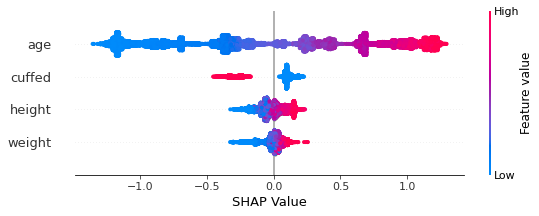

In [7]:
INPUT_VARS = ['age','weight','height', 'cuffed']

X_train = pd.DataFrame(x_train, columns=INPUT_VARS)

fig = plt.figure(figsize=(12,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
shap.summary_plot(shap_values, X_train, show=False)
ax.set_xlabel('SHAP Value')
#ax.set_title('SHAP Dot Plot', fontsize=20)
plt.savefig("figures/Fig4_a_size_SHAP.png", dpi=600)
plt.show()

In [ ]:
X_train = pd.DataFrame(x_train, columns=INPUT_VARS)
shap.summary_plot(shap_values, X_train, plot_type = 'bar')

In [ ]:
shap_interaction_values = explainer.shap_interaction_values(X_train)
shap.summary_plot(shap_interaction_values, X_train)

[Documentation of shap plot](https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/plots/scatter.html?highlight=scatter)

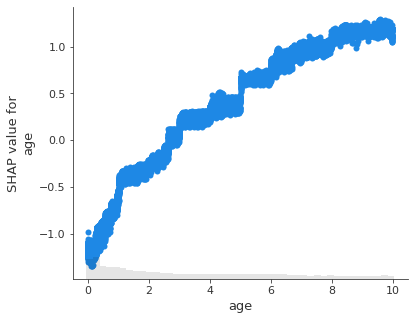

In [41]:
shap_xgb = explainer(X_train)
shap.plots.scatter(shap_xgb[:,'age'], dot_size = None, show=False)
#plt.rcParams['font.family'] = 'AvenirNextLTPro'
plt.savefig("figures/Fig5_a_age.png", dpi=600)

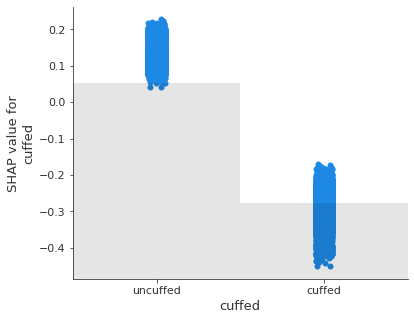

In [37]:
shap.plots.scatter(shap_xgb[:,'cuffed'], x_jitter=0.1, dot_size = None, show=False)
plt.xticks([0,1], ['uncuffed', 'cuffed'])
plt.savefig("figures/Fig5_d_cuffed.png", dpi=600)
plt.show()

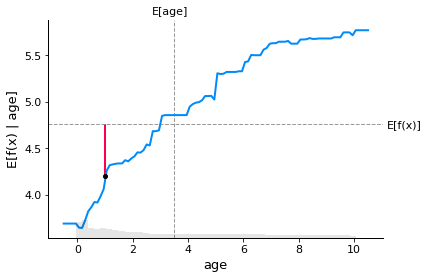

In [24]:
sample_ind = 20

fig,ax = shap.partial_dependence_plot(
    "age", xgbr.predict, X_train, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_xgb[sample_ind:sample_ind+1,:]
)